## 라이브러리

In [2]:
import os
import time
import copy
import math
import random
import argparse
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
from tqdm import tqdm
from scipy import sparse
import scipy.sparse as sp
import matplotlib.pyplot as plt

import torch
import torch_sparse
import torch.nn.functional as F

from torch import nn
from torch import Tensor
from torch.nn import Linear
import torch.optim as optim
from torch.optim import Adam
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, GATConv, SAGEConv, GINConv
from scipy.spatial.distance import jensenshannon
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import gaussian_kde, wasserstein_distance, pearsonr, spearmanr, entropy, ks_2samp, cramervonmises_2samp
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, f1_score, average_precision_score
from torch.nn.parameter import Parameter
from deeprobust.graph.defense.pgd import PGD, prox_operators

from typing import Optional, Tuple
from torch_sparse import SparseTensor, matmul
from torch_geometric.typing import Adj, OptTensor
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.utils import dropout_adj, convert

import ctypes
ctypes.cdll.LoadLibrary('caffe2_nvrtc.dll')

# import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)

# import dgl
# from dgl.nn.pytorch import GraphConv

<CDLL 'caffe2_nvrtc.dll', handle 7ff939870000 at 0x25eb9e80eb0>

In [3]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

## 함수

In [4]:
# 모델 관련 함수

class GCN_Body(nn.Module):
    def __init__(self, nfeat, nhid, dropout):
        super(GCN_Body, self).__init__()
        self.gc1 = GCNConv(nfeat, nhid)
        self.gc2 = GCNConv(nhid, nhid)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index):
        x = F.relu(self.gc1(x, edge_index))
        x = self.dropout(x)
        x = self.gc2(x, edge_index)
        return x  
    
class GCN(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout):
        super(GCN, self).__init__()
        self.body = GCN_Body(nfeat,nhid,dropout)
        self.fc = nn.Linear(nhid,nclass)

    def forward(self, x, edge_index):
        x = self.body(x, edge_index)
        x = self.fc(x)
        return x

class GCNLayer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_dim, out_dim)

    def forward(self, x, edge_index):
        row, col = edge_index
        deg = torch.bincount(row, minlength=x.size(0)).float().clamp(min=1)
        norm = 1.0 / deg[row].sqrt() / deg[col].sqrt()
        out = torch.zeros_like(x)
        out.index_add_(0, row, x[col] * norm.unsqueeze(1))
        return self.linear(out)
    
# 나중에 수정 필요함
class GAT_body(nn.Module):
    def __init__(self,
                 num_layers,
                 in_dim,
                 num_hidden,
                 heads,
                 feat_drop,
                 attn_drop,
                 negative_slope,
                 residual):
        super(GAT_body, self).__init__()
        self.num_layers = num_layers
        self.gat_layers = nn.ModuleList()
        self.activation = F.elu
        # input projection (no residual)
        self.gat_layers.append(GATConv(
            in_dim, num_hidden, heads[0],
            feat_drop, attn_drop, negative_slope, False, self.activation))
        
        # hidden layers
        for l in range(1, num_layers):
            # due to multi-head, the in_dim = num_hidden * num_heads
            self.gat_layers.append(GATConv(
                num_hidden * heads[l-1], num_hidden, heads[l],
                feat_drop, attn_drop, negative_slope, residual, self.activation))
        
        # output projection
        self.gat_layers.append(GATConv(
            num_hidden * heads[-2], num_hidden, heads[-1],
            feat_drop, attn_drop, negative_slope, residual, None))
    
    def forward(self, g, inputs):
        h = inputs
        for l in range(self.num_layers):
            h = self.gat_layers[l](g, h).flatten(1)
        
        # output projection
        logits = self.gat_layers[-1](g, h).mean(1)

        return logits

class GAT(nn.Module):
    def __init__(self,
                 num_layers,
                 in_dim,
                 num_hidden,
                 num_classes,
                 heads,
                 feat_drop,
                 attn_drop,
                 negative_slope,
                 residual):
        super(GAT, self).__init__()

        self.body = GAT_body(num_layers, in_dim, num_hidden, heads, feat_drop, attn_drop, negative_slope, residual)
        self.fc = nn.Linear(num_hidden,num_classes)
    
    def forward(self, g, inputs):
        logits = self.body(g,inputs)
        logits = self.fc(logits)

        return logits

def get_model(model, nfeat,
              num_hidden=64, dropout=0.5, num_heads=1, num_layers=1, num_out_heads=1, attn_drop=0.0, negative_slope=0.2, residual=False):
    if model == "GCN":
        model = GCN_Body(nfeat, num_hidden, dropout)
    elif model == "GAT":
        heads = ([num_heads] * num_layers) + [num_out_heads]
        model = GAT_body(num_layers, nfeat, num_hidden, heads, dropout, attn_drop, negative_slope, residual)
    else:
        raise ValueError("Model not implemented")
    return model
   
def str2bool(v):
    if v.lower() in ('yes', 'true', 't', 'y', '1'):
        return True
    elif v.lower() in ('no', 'false', 'f', 'n', '0'):
        return False
    else:
        raise argparse.ArgumentTypeError('Unsupported value encountered.')

def feature_norm(features):
    min_values = features.min(axis=0)[0]
    max_values = features.max(axis=0)[0]

    return 2*(features - min_values).div(max_values-min_values) - 1

def quantile_loss(y_true, y_pred, tau=0.9):
    error = y_true - y_pred
    return torch.mean(torch.max(tau * error, (tau - 1) * error))

def get_sen(sens, idx_sens_train):
    num_classes = 2  # binary sensitive attribute assumed
    one_hot = F.one_hot(sens.long(), num_classes=num_classes).float()  # (N, 2)

    # training 노드에 대해서만 정규화
    group_sums = one_hot[idx_sens_train].sum(dim=0, keepdim=True)  # (1, 2)
    group_sums[group_sums == 0] = 1  # 0으로 나누는 것 방지

    one_hot[idx_sens_train] = one_hot[idx_sens_train] / group_sums  # group-normalized

    return one_hot  # shape: (N, 2)

# def get_sen(sens, idx_sens_train):
#     sens_zeros = torch.zeros_like(sens)
#     sens_1 = sens 
#     sens_0 = (1 - sens) 
    
#     sens_1[idx_sens_train] = sens_1[idx_sens_train] / len(sens_1[idx_sens_train])
#     sens_0[idx_sens_train] = sens_0[idx_sens_train] / len(sens_0[idx_sens_train])

#     sens_zeros[idx_sens_train] = sens_1[idx_sens_train] - sens_0[idx_sens_train]
#     sen_mat = torch.unsqueeze(sens_zeros, dim=0)
#     return sen_mat

# def check_sen(edge_index, sen):
#     nnz = edge_index.nnz()
#     deg = torch.eye(edge_index.sizes()[0]).cuda()
#     adj = edge_index.to_dense()
#     lap = (sen.t() @ sen).to_dense()
#     lap2 = deg - adj
#     diff = torch.sum(torch.abs(lap2-lap)) / nnz
#     assert diff < 0.000001, f'error: {diff} need to make sure L=B^TB'


In [5]:
# 데이터셋 로드 함수

def feature_norm(features):
    min_values = features.min(axis=0)[0]
    max_values = features.max(axis=0)[0]
    return 2*(features - min_values).div(max_values-min_values) - 1

def load_dataset(dataset, sens_attr,predict_attr, path="./dataset/pokec/", 
               label_number=1000, sens_number=500, test_idx=False, seed=1127):
    """Load data"""
    print('Loading {} dataset from {}'.format(dataset,path))

    idx_features_labels = pd.read_csv(os.path.join(path,"{}.csv".format(dataset)))
    header = list(idx_features_labels.columns)
    header.remove("user_id")

    header.remove(sens_attr)
    header.remove(predict_attr)

    features = sp.csr_matrix(idx_features_labels[header], dtype=np.float32)
    labels = idx_features_labels[predict_attr].values
    
    # build graph
    idx = np.array(idx_features_labels["user_id"], dtype=int)
    idx_map = {j: i for i, j in enumerate(idx)}

    # edges_unordered = np.genfromtxt(os.path.join(path,"{}_relationship.txt".format(dataset)), dtype=int)
    edges_unordered = np.genfromtxt(os.path.join(path, f"{dataset}_relationship.txt"), dtype=np.int64)

    # edges = np.array(list(map(idx_map.get, edges_unordered.flatten())),
    #                  dtype=int).reshape(edges_unordered.shape)
    mapped_edges = []
    dropped = 0
    for u, v in edges_unordered:
        u_mapped = idx_map.get(u)
        v_mapped = idx_map.get(v)
        if u_mapped is not None and v_mapped is not None:
            mapped_edges.append((u_mapped, v_mapped))
        else:
            dropped += 1

    print(f"[INFO] 유효하지 않은 user_id로 인해 제거된 edge 수: {dropped}")
    edges = np.array(mapped_edges, dtype=int)

    adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                        shape=(labels.shape[0], labels.shape[0]),
                        dtype=np.float32)
    
    # build symmetric adjacency matrix
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

    # features = normalize(features)
    adj = adj + sp.eye(adj.shape[0])

    features = torch.FloatTensor(np.array(features.todense()))
    labels = torch.LongTensor(labels)
    # adj = sparse_mx_to_torch_sparse_tensor(adj)

    
    random.seed(seed)
    label_idx = np.where(labels>=0)[0]

    # random.shuffle(label_idx)
    # idx_train = label_idx[:min(int(0.5 * len(label_idx)),label_number)]
    # idx_val = label_idx[int(0.5 * len(label_idx)):int(0.75 * len(label_idx))]
    # if test_idx:
    #     idx_test = label_idx[label_number:]
    #     idx_val = idx_test
    # else:
    #     idx_test = label_idx[int(0.75 * len(label_idx)):]

    # sens = idx_features_labels[sens_attr].values
    # sens_idx = set(np.where(sens >= 0)[0])
    # idx_test = np.asarray(list(sens_idx & set(idx_test)))
    # sens = torch.FloatTensor(sens)
    # idx_sens_train = list(sens_idx - set(idx_val) - set(idx_test))
    # random.seed(seed)
    # random.shuffle(idx_sens_train)
    # idx_sens_train = torch.LongTensor(idx_sens_train[:sens_number])

    # idx_train = torch.LongTensor(idx_train)
    # idx_val = torch.LongTensor(idx_val)
    # idx_test = torch.LongTensor(idx_test)

    # stratified sampling
    sens_all = idx_features_labels[sens_attr].values
    labels_all = labels  # np.ndarray 혹은 torch.Tensor

    # 유효한 인덱스 (라벨, 민감 속성 모두 존재)
    valid_idx = np.where((labels_all >= 0) & (sens_all >= 0))[0]
    sens_valid = sens_all[valid_idx]

    # Stratified Split: Train (50%) / Temp (50%)
    sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=seed)
    train_part, temp_part = next(sss1.split(valid_idx, sens_valid))

    # Stratified Split: Val (25%) / Test (25%)
    sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=seed)
    val_part, test_part = next(sss2.split(temp_part, sens_valid[temp_part]))

    # 인덱스 최종화
    idx_train = torch.LongTensor(valid_idx[train_part])
    idx_val = torch.LongTensor(valid_idx[temp_part[val_part]])
    idx_test = torch.LongTensor(valid_idx[temp_part[test_part]])

    # 민감 속성 텐서
    sens = torch.FloatTensor(sens_all)

    # sens 학습 인덱스: val/test와 겹치지 않게 선택
    sens_idx = set(np.where(sens_all >= 0)[0])
    idx_sens_train_pool = list(sens_idx - set(idx_val.numpy()) - set(idx_test.numpy()))
    random.seed(seed)
    random.shuffle(idx_sens_train_pool)
    idx_sens_train = torch.LongTensor(idx_sens_train_pool[:sens_number])
    
    # random.shuffle(sens_idx)

    if dataset == 'nba':
        features = feature_norm(features)

    return adj, features, labels, idx_train, idx_val, idx_test, sens, idx_sens_train

def is_symmetric(m):
    '''
    Judge whether the matrix is symmetric or not.
    :param m: Adjacency matrix(Array)
    '''
    res = np.int64(np.triu(m).T == np.tril(m))
    # if np.where(res==0)[0] != []:
    if np.where(res == 0)[0].size > 0:
        raise ValueError("The matrix is not symmetric!")
    else:
        pass
    
def symetric_normalize(m, half: bool):
    '''
    Symmetrically normalization for adjacency matrix
    :param m: (Array) Adjacency matrix
    :param half: (bool) whether m is triu or full
    :return: (Array) An symmetric adjacency matrix
    '''
    if not half:
        is_symmetric(m)
    else:
        m = m + m.T - np.diag(np.diagonal(m))

    hat_m = m + np.eye(m.shape[0])
    D = np.sum(hat_m, axis=1)
    D = np.diag(D)

    # D = np.power(D, -0.5)
    with np.errstate(divide='ignore'):
        D = np.power(D, -0.5)
        D[np.isinf(D)] = 0

    D[np.isinf(D)] = 0
    sn_m = np.matmul(np.matmul(D, hat_m), D)
    return sn_m

def sp2sptensor(m):
    # sparse_m = sp.coo_matrix(m).astype(np.float)
    sparse_m = sp.coo_matrix(m).astype(np.float64)
    # indices = torch.from_numpy(np.vstack((sparse_m.row, sparse_m.col)).astype(int))
    indices = torch.from_numpy(np.vstack((sparse_m.row, sparse_m.col))).long()
    values = torch.from_numpy(sparse_m.data)
    shape = torch.Size(sparse_m.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

class German:
    def __init__(self, path):
        if not os.path.exists(path):
            raise ValueError("Data path doesn't exist!")
        else:
            self.data_path = path
        self.raw_data = self._node_process()
        self.A_tensor, self.A = self._edge_process()
        self.senIdx, self.sen_vals, self.trainIdxtensor, self.valIdxTensor, self.testIdxTensor, self.features, self.labels = self._split_data()

    def _node_process(self):
        filenames = os.listdir(self.data_path)

        for file in filenames:
            if os.path.splitext(file)[1] != '.csv':
                continue
            else:
                df_data = pd.read_csv(os.path.join(self.data_path, file))

                # modify str feature
                # df_data['GoodCustomer'].replace(-1, 0, inplace=True)
                df_data['GoodCustomer'] = df_data['GoodCustomer'].replace(-1, 0).astype(int)

                # df_data['Gender'].replace('Male', 1, inplace=True)
                # df_data['Gender'].replace('Female', 0, inplace=True)
                gender_map = {'Female': 0, 'Male': 1}
                df_data['Gender'] = df_data['Gender'].map(gender_map).astype(int)

                purposeList = list(df_data['PurposeOfLoan'])
                random.shuffle(purposeList)
                purposeDict = {}
                index = 0
                for pur in purposeList:
                    if purposeDict.get(pur, None) is None:
                        purposeDict[pur] = index
                        index += 1
                    else:
                        continue

                for key in purposeDict.keys():
                    # df_data['PurposeOfLoan'].replace(key, purposeDict[key], inplace=True)
                    df_data['PurposeOfLoan'] = df_data['PurposeOfLoan'].map(purposeDict).fillna(-1).astype(int)
                    
                return df_data

    def _edge_process(self):
        filenames = os.listdir(self.data_path)

        for file in filenames:
            if os.path.splitext(file)[1] != '.txt':
                continue
            else:
                edges = np.loadtxt(os.path.join(self.data_path, file)).astype(int)

                # Adjacency
                num_dim = len(self.raw_data)
                A = np.zeros((num_dim, num_dim))
                for i in range(len(edges)):
                    A[edges[i][0]][edges[i][1]] = 1
                    A[edges[i][1]][edges[i][0]] = 1
                sym_norm_A = symetric_normalize(A, half=False)
                syn_norm_A_tensor = sp2sptensor(sym_norm_A)
                return syn_norm_A_tensor, A

    def _split_data(self):
        pos_data = self.raw_data[self.raw_data['GoodCustomer']==1]
        pos_index = list(pos_data.index)
        neg_data = self.raw_data[self.raw_data['GoodCustomer']==0]
        neg_index = list(neg_data.index)

        # shuffle the index
        random.seed(20)
        random.shuffle(pos_index)
        random.shuffle(neg_index)

        # split the data
        train_pos_idx = pos_index[:int(0.5*len(pos_index))]
        train_neg_idx = neg_index[:int(0.5*len(neg_index))]
        val_pos_idx = pos_index[int(0.5*len(pos_index)): int(0.75*len(pos_index))]
        val_neg_idx = neg_index[int(0.5*len(neg_index)): int(0.75*len(neg_index))]
        test_pos_idx = pos_index[int(0.75*len(pos_index)):]
        test_neg_idx = neg_index[int(0.75*len(neg_index)):]

        trainIdx = train_pos_idx + train_neg_idx
        random.shuffle(trainIdx)
        valIdx = val_pos_idx + val_neg_idx
        random.shuffle(valIdx)
        testIdx = test_pos_idx + test_neg_idx
        random.shuffle(testIdx)

        assert len(trainIdx)+len(valIdx)+len(testIdx) == len(self.raw_data), "Missing data or leaking data!"

        feature_cols = list(self.raw_data.columns)
        feature_cols.remove('GoodCustomer')
        sen_idx = feature_cols.index('Gender')
        sen_vals = self.raw_data['Gender'].values.astype(int)
        feature_data = self.raw_data[feature_cols]
        labels = self.raw_data['GoodCustomer']

        # transform to tensor
        trainIdxTensor = torch.LongTensor(trainIdx)
        valIdxTensor = torch.LongTensor(valIdx)
        testIdxTensor = torch.LongTensor(testIdx)
        featuredata = torch.FloatTensor(np.array(feature_data))
        labels = torch.LongTensor(np.array(labels))

        return sen_idx, sen_vals, trainIdxTensor, valIdxTensor, testIdxTensor, featuredata, labels

    def get_index(self):
        return [self.trainIdxtensor, self.valIdxTensor, self.testIdxTensor]

    def get_raw_data(self):
        return [self.features, self.A_tensor, self.labels]

    def generate_counterfactual_perturbation(self, data):
        '''
        Generate counterfactual data by flipping sensitive attribute.
        :param data: Tensor
        :return: counterfactual data
        '''
        feature_data = copy.deepcopy(data)
        feature_data[:, self.senIdx] = 1 - feature_data[:, self.senIdx]
        return feature_data

    def generate_node_perturbation(self, prob: float, sen: bool = False):
        '''
        Perturbing node attributes, except for sensitive attributes.
        :param prob: portion of perturbed data
        :return: perturbed data
        '''
        feature_data = copy.deepcopy(self.features)
        r = np.random.binomial(n=1, p=prob, size=feature_data.numpy().shape)
        for i in range(len(feature_data)):
            r[i][self.senIdx] = 0
        noise = np.multiply(r, np.random.normal(0., 1., r.shape))
        noise_tensor = torch.FloatTensor(noise)
        x_hat = feature_data + noise_tensor

        if sen:
            x_hat = self.generate_counterfactual_perturbation(x_hat)
        return x_hat

    def generate_struc_perturbation(self, drop_prob: float, tensor: bool = True):
        A = copy.deepcopy(self.A)
        half_A = np.triu(A)
        row, col = np.nonzero(half_A)
        idx_perturb = np.random.binomial(n=1, p=1-drop_prob, size=row.shape)
        broken_edges = np.where(idx_perturb==0)[0]
        for idx in broken_edges:
            half_A[row[idx]][col[idx]] = 0
        new_A = symetric_normalize(half_A, half=True)
        if tensor:
            new_A = sp2sptensor(new_A)
        return new_A

def load_dataset_unified(dataset, sens_attr, predict_attr, path="./dataset/", 
                         label_number=1000, sens_number=500, test_idx=False, seed=1127):
    
    if dataset.lower() != 'german':
        full_path = path
        return load_dataset(dataset, sens_attr, predict_attr, full_path, label_number, sens_number, test_idx, seed)

    elif dataset.lower() == 'german':
        full_path = path
        print('Loading {} dataset from {}'.format(dataset, full_path))
        german_data = German(full_path)
        
        adj = german_data.A_tensor
        features = german_data.features
        labels = german_data.labels
        sens = torch.FloatTensor(german_data.sen_vals)
        # idx_train, idx_val, idx_test = german_data.get_index()

        # # 민감 속성 학습용 인덱스 (val/test 제외)
        # all_idx = set(range(len(sens)))
        # sens_idx = set(np.where(sens.numpy() >= 0)[0])
        # idx_sens_train = list(sens_idx - set(idx_val.numpy()) - set(idx_test.numpy()))
        # random.seed(seed)
        # random.shuffle(idx_sens_train)
        # idx_sens_train = torch.LongTensor(idx_sens_train[:sens_number])

        # Stratified split: 50/25/25
        total_idx = np.where((labels >= 0) & (sens >= 0))[0]
        sens_np = sens[total_idx].numpy()

        sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=seed)
        train_idx, temp_idx = next(sss1.split(total_idx, sens_np))
        sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=seed)
        val_idx, test_idx = next(sss2.split(temp_idx, sens_np[temp_idx]))

        idx_train = torch.LongTensor(total_idx[train_idx])
        idx_val = torch.LongTensor(total_idx[temp_idx[val_idx]])
        idx_test = torch.LongTensor(total_idx[temp_idx[test_idx]])

        sens_idx = set(np.where(sens.numpy() >= 0)[0])
        idx_sens_train = list(sens_idx - set(idx_val.numpy()) - set(idx_test.numpy()))
        random.seed(seed)
        random.shuffle(idx_sens_train)
        idx_sens_train = torch.LongTensor(idx_sens_train[:sens_number])

        return adj, features, labels, idx_train, idx_val, idx_test, sens, idx_sens_train
    else:
        raise ValueError(f"Unsupported dataset: {dataset}")

def load_and_prepare_dataset(dataset_config, config_name, seed=1127, normalize=True):
    
    cfg = dataset_config.get(config_name)
    
    if cfg is None:
        raise ValueError(f"Dataset '{config_name}' not found in dataset_config.")
    
    # 메타 정보
    path = cfg['path']
    dataset_name = cfg['dataset']
    predict_attr = cfg['predict_attr']
    sens_attr = cfg['sens_attr']
    label_number = cfg.get('label_number')
    sens_number = cfg.get('sens_number')
    test_idx = cfg.get('test_idx')
    # dn = cfg['dn']

    df = pd.read_csv(f"{path}/{dataset_name}.csv")

    # 그래프, 특성 등 로드
    adj, features, labels, idx_train, idx_val, idx_test, sens, idx_sens_train = load_dataset_unified(
        dataset_name, sens_attr, predict_attr, path, label_number, sens_number, test_idx, seed=seed
    )

    if sens_attr:
        sens[sens>0]=1
    print(f"[{dataset_name}] sens=0: {torch.sum(sens == 0).item()}, sens=1: {torch.sum(sens == 1).item()}")
    print('-' * 50)

    # 정규화
    x_scaler, y_scaler = None, None
    if normalize:
        # X 정규화
        x_scaler = StandardScaler()
        features = torch.tensor(x_scaler.fit_transform(features.cpu()), dtype=torch.float32)

        # Y 정규화
        y_scaler = StandardScaler()
        labels = torch.tensor(y_scaler.fit_transform(labels.cpu().reshape(-1, 1)), dtype=torch.float32).view(-1)

    # edge_index 구성
    if isinstance(adj, torch.Tensor):  # PyTorch sparse tensor
        edge_index = adj._indices()
        # g = dgl.graph((src, dst))
    else:  # Scipy sparse matrix
        # g = dgl.from_scipy(adj)
        adj_coo = adj.tocoo()
        edge_index = torch.tensor([adj_coo.row, adj_coo.col], dtype=torch.long)

    # PyG 데이터 객체 구성
    data = Data(
        x=features,
        edge_index=edge_index,
        y=labels.float(),
        sensitive_attr=sens,
        adj=adj
        # quantile_tau=torch.full((features.shape[0],), tau)
    )
    data.idx_train = idx_train
    data.idx_val = idx_val
    data.idx_test = idx_test
    data.idx_sens_train = idx_sens_train

    return data, df, cfg


In [6]:
# 지표 관련 함수

def fair_metric(output, labels, sens, idx):
    val_y = labels[idx].cpu().numpy()
    idx_s0 = sens.cpu().numpy()[idx.cpu().numpy()]==0
    idx_s1 = sens.cpu().numpy()[idx.cpu().numpy()]>0

    idx_s0_y1 = np.bitwise_and(idx_s0,val_y>0)
    idx_s1_y1 = np.bitwise_and(idx_s1,val_y>0)

    pred_y = (output[idx].squeeze()>0.5).type_as(labels).cpu().numpy()

    parity = abs(sum(pred_y[idx_s0])/sum(idx_s0)-sum(pred_y[idx_s1])/sum(idx_s1))
    equality = abs(sum(pred_y[idx_s0_y1])/sum(idx_s0_y1)-sum(pred_y[idx_s1_y1])/sum(idx_s1_y1))

    return parity, equality

def accuracy(output, labels):
    output = output.squeeze()
    preds = (output>0).type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    
    return correct / len(labels)

def fair_metric_regression(output, labels, sens):
    y_g0 = output[sens == 0]
    y_g1 = output[sens == 1]
    
    # 그룹별 MSE 차이
    mse_g0 = mean_squared_error(labels[sens == 0].cpu().numpy(), y_g0.cpu().numpy()) if len(y_g0) > 0 else 0.0
    mse_g1 = mean_squared_error(labels[sens == 1].cpu().numpy(), y_g1.cpu().numpy()) if len(y_g1) > 0 else 0.0
    mse_diff = abs(mse_g0 - mse_g1)

    # 그룹별 MAE 차이
    mae_g0 = mean_absolute_error(labels[sens == 0].cpu().numpy(), y_g0.cpu().numpy()) if len(y_g0) > 0 else 0.0
    mae_g1 = mean_absolute_error(labels[sens == 0].cpu().numpy(), y_g0.cpu().numpy()) if len(y_g0) > 0 else 0.0
    mae_diff = abs(mae_g0 - mae_g1)

    # 그룹별 평균 차이
    mean_g0 = y_g0.mean().item() if len(y_g0) > 0 else 0.0
    mean_g1 = y_g1.mean().item() if len(y_g1) > 0 else 0.0
    mean_diff = abs(mean_g0 - mean_g1)
    
    return mse_g0, mse_g1, mse_diff, mae_g0, mae_g1, mae_diff, mean_g0, mean_g1, mean_diff

def compute_graph_fairness_stats(data, edge_index):
    sens = data.sensitive_attr.cpu().numpy()
    labels = data.y.cpu().numpy()
    src, dst = edge_index[0].cpu().numpy(), edge_index[1].cpu().numpy()
    num_nodes = len(sens)

    print("========== Dataset Summary ==========")
    print(f"Total nodes: {num_nodes}")
    print(f"Total edges: {edge_index.shape[1]}")

    # 1. 민감 속성 분포
    g0, g1 = np.sum(sens == 0), np.sum(sens == 1)
    print("\n--- Sensitive Attribute Distribution ---")
    print(f"Group 0: {g0} ({g0/num_nodes:.2%})")
    print(f"Group 1: {g1} ({g1/num_nodes:.2%})")

    # 2. 예측값 분포
    print("\n--- Label Distribution ---")
    print(f"Overall: mean={labels.mean():.4f}, std={labels.std():.4f}")
    print(f"Group 0: mean={labels[sens==0].mean():.4f}, std={labels[sens==0].std():.4f}")
    print(f"Group 1: mean={labels[sens==1].mean():.4f}, std={labels[sens==1].std():.4f}")

    # 3. 상관관계
    pear, _ = pearsonr(sens, labels)
    spear, _ = spearmanr(sens, labels)
    print("\n--- Correlation (Sensitive vs Label) ---")
    print(f"Pearson:  {pear:.4f}")
    print(f"Spearman: {spear:.4f}")

    # 4. Homophily
    def homophily(attr):
        return np.mean(attr[src] == attr[dst])
    sens_hom = homophily(sens)
    label_hom = homophily(labels.round())  # 연속형 label인 경우 이진화
    print("\n--- Graph Homophily ---")
    print(f"Sensitive attribute homophily: {sens_hom:.4f}")
    print(f"Label homophily: {label_hom:.4f}")

    # 5. Group별 node degree
    degree = np.bincount(src, minlength=num_nodes)
    deg_g0 = degree[sens == 0]
    deg_g1 = degree[sens == 1]
    print("\n--- Node Degree (per group) ---")
    print(f"Group 0: mean={deg_g0.mean():.2f}, std={deg_g0.std():.2f}")
    print(f"Group 1: mean={deg_g1.mean():.2f}, std={deg_g1.std():.2f}")

    # 6. 이웃 구성 동질성 (각 노드 이웃 중 같은 그룹 비율 평균)
    same_group_ratios = []
    for i in range(num_nodes):
        neighbors = dst[src == i]
        if len(neighbors) > 0:
            same_ratio = np.mean(sens[neighbors] == sens[i])
            same_group_ratios.append(same_ratio)
    print("\n--- Neighborhood Composition ---")
    print(f"Average same-group neighbor ratio: {np.mean(same_group_ratios):.4f}")

def total_variation_distance(p, q):
    return 0.5 * np.sum(np.abs(p - q))

def kl_divergence(p, q):
    p = np.clip(p, 1e-10, 1)
    q = np.clip(q, 1e-10, 1)
    return entropy(p, q)

def js_divergence(p, q):
    return jensenshannon(p, q) ** 2

def eval_distribution_metrics(y_true_np, y_pred_np, bins=50, range=None):
    hist_true, _ = np.histogram(y_true_np, bins=bins, range=range, density=False)
    hist_pred, _ = np.histogram(y_pred_np, bins=bins, range=range, density=False)

    # Normalize and avoid zero
    hist_true = hist_true.astype(np.float64)
    hist_pred = hist_pred.astype(np.float64)

    hist_true += 1e-10
    hist_pred += 1e-10
    hist_true /= hist_true.sum()
    hist_pred /= hist_pred.sum()

    return {
        'wasserstein': wasserstein_distance(y_true_np, y_pred_np),
        'kl': kl_divergence(hist_true, hist_pred),
        'js': js_divergence(hist_true, hist_pred),
        'ks': ks_2samp(y_true_np, y_pred_np).statistic,
        'cvm': cramervonmises_2samp(y_true_np, y_pred_np).statistic,
        'tv': total_variation_distance(hist_true, hist_pred)
    }

def compare_groupwise_distribution(y_true_np, y_pred_np, sensitive_attr_np, bins=50, range=None):
    groups = np.unique(sensitive_attr_np.astype(int))
    if len(groups) != 2:
        raise ValueError(f"필요한 그룹(0, 1) 중 일부가 누락되었습니다. 존재하는 그룹: {groups}")

    results = {}
    metrics = ['wasserstein', 'kl', 'js', 'ks', 'cvm', 'tv']
    group_metrics = {}

    for g in groups:
        idx = sensitive_attr_np == g
        group_metrics[f"group_{g}"] = eval_distribution_metrics(
            y_true_np[idx], y_pred_np[idx], bins=bins, range=range
        )

    for m in metrics:
        try:
            diff = abs(group_metrics["group_0"][m] - group_metrics["group_1"][m])
            results[f"{m}_diff"] = diff
            results[f"{m}_g0"] = group_metrics["group_0"][m]
            results[f"{m}_g1"] = group_metrics["group_1"][m]
        except KeyError as e:
            raise KeyError(f"그룹별 지표 계산 중 '{e}' 누락. 현재 그룹들: {group_metrics.keys()}")

    return results



## 데이터셋 로드

In [7]:
# 데이터셋 설정
dataset_config = {
    'region_job_r': {
        'path': "./dataset/pokec",
        'dataset': 'region_job', # Pokec_z
        'predict_attr': 'completion_percentage',  # completion_percentage: 프로필을 얼마나 채웠는가 (%). 자발적 행동의 간접 지표.
        'sens_attr': 'region', # gender
        'label_number': 500,
        'sens_number': 200,
        'test_idx': False,
        'dn': 'Pokec_z_Region'
    },

    'region_job_g': {
        'path': "./dataset/pokec",
        'dataset': 'region_job',
        'predict_attr': 'completion_percentage',  # completion_percentage: 프로필을 얼마나 채웠는가 (%). 자발적 행동의 간접 지표.
        'sens_attr': 'gender', # gender
        'label_number': 500,
        'sens_number': 200,
        'test_idx': False,
        'dn': 'Pokec_z_Gender'
    },

    'region_job_2_r': {
        'path': "./dataset/pokec",
        'dataset': 'region_job_2',
        'predict_attr': 'completion_percentage',  # completion_percentage: 프로필을 얼마나 채웠는가 (%). 자발적 행동의 간접 지표.
        'sens_attr': 'region', # gender
        'label_number': 500,
        'sens_number': 200,
        'test_idx': False,
        'dn': 'Pokec_n_Region'
    },

    'region_job_2_g': {
        'path': "./dataset/pokec",
        'dataset': 'region_job_2',
        'predict_attr': 'completion_percentage',  # completion_percentage: 프로필을 얼마나 채웠는가 (%). 자발적 행동의 간접 지표.
        'sens_attr': 'gender', # gender
        'label_number': 500,
        'sens_number': 200,
        'test_idx': False,
        'dn': 'Pokec_n_Gender'
    },

    'nba_p': {
        'path': "./dataset/NBA",
        'dataset': 'nba',
        # PIE (Player Impact Estimate): 통합 퍼포먼스 지표, 퍼포먼스에 대한 차별 여부 확인 가능
        # MPG (Minutes Per Game): 출전 시간 → 팀의 코치 결정, 제도적 편향 가능성
        'predict_attr': 'PIE',
        'sens_attr': 'country',  # AGE, palyer_height, player_weight
        'label_number': 100,
        'sens_number': 50,
        'test_idx': True,
        'dn': 'NBA(PIE)_Country'
    },

    'nba_m': {
        'path': "./dataset/NBA",
        'dataset': 'nba',
        'predict_attr': 'MPG',
        'sens_attr': 'country',
        'label_number': 100,
        'sens_number': 50,
        'test_idx': True,
        'dn': 'NBA(MPG)_Country'
    },

    'german_g': {
        'path': './dataset/NIFTY',
        'dataset': 'german',
        'predict_attr': 'LoanAmount', # LoanAmount(대출 금액), LoanRateAsPercentOfIncome(소득대비상환비율), YearsAtCurrentHome(거주연수)
        'sens_attr': 'Gender', # Gender, ForeignWorker, Single(독신여부), HasTelephone(전화기보유여부), OwnsHouse(주택소유여부), Unemployed(실직상태여부) Age(고령자로 나눠서 가능) 등등등..
        'label_number': None,
        'sens_number': None,
        'test_idx': None,
        'dn': 'German_Gender'
    },

    'german_f': {
        'path': './dataset/NIFTY',
        'dataset': 'german',
        'predict_attr': 'LoanAmount',
        'sens_attr': 'ForeignWorker',
        'label_number': None,
        'sens_number': None,
        'test_idx': None,
        'dn': 'German_ForeignWorker'
    },

    'german_s': {
        'path': './dataset/NIFTY',
        'dataset': 'german',
        'predict_attr': 'LoanAmount', 
        'sens_attr': 'Single', 
        'label_number': None,
        'sens_number': None,
        'test_idx': None,
        'dn': 'German_Single'
    },

    'german_t': {
        'path': './dataset/NIFTY',
        'dataset': 'german',
        'predict_attr': 'LoanAmount', 
        'sens_attr': 'HasTelephone', 
        'label_number': None,
        'sens_number': None,
        'test_idx': None,
        'dn': 'German_HasTelephone'
    },

    'german_h': {
        'path': './dataset/NIFTY',
        'dataset': 'german',
        'predict_attr': 'LoanAmount', 
        'sens_attr': 'OwnsHouse', 
        'label_number': None,
        'sens_number': None,
        'test_idx': None,
        'dn': 'German_OwnsHouse'
    },

    'german_e': {
        'path': './dataset/NIFTY',
        'dataset': 'german',
        'predict_attr': 'LoanAmount', 
        'sens_attr': 'Unemployed', 
        'label_number': None,
        'sens_number': None,
        'test_idx': None,
        'dn': 'German_Unemployed'
    }
}

# 전체 데이터셋 로드
datasets = ['region_job_r', 'region_job_g', 'region_job_2_r', 'region_job_2_g', 'nba_p', 'nba_m', 'german_g', 'german_f', 'german_s', 'german_t', 'german_h', 'german_e']

all_data = {}
for ds in datasets:
    data, df, cfg = load_and_prepare_dataset(dataset_config, config_name=ds)
    all_data[ds] = {
        'data': data,
        'df': df,
        'cfg': cfg
    }


Loading region_job dataset from ./dataset/pokec
[INFO] 유효하지 않은 user_id로 인해 제거된 edge 수: 0
[region_job] sens=0: 43962, sens=1: 23834
--------------------------------------------------


C:\Users\user\AppData\Local\Temp\ipykernel_40236\4268627356.py:420: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:278.)
  edge_index = torch.tensor([adj_coo.row, adj_coo.col], dtype=torch.long)


Loading region_job dataset from ./dataset/pokec
[INFO] 유효하지 않은 user_id로 인해 제거된 edge 수: 0
[region_job] sens=0: 34308, sens=1: 33488
--------------------------------------------------
Loading region_job_2 dataset from ./dataset/pokec
[INFO] 유효하지 않은 user_id로 인해 제거된 edge 수: 0
[region_job_2] sens=0: 47338, sens=1: 19231
--------------------------------------------------
Loading region_job_2 dataset from ./dataset/pokec
[INFO] 유효하지 않은 user_id로 인해 제거된 edge 수: 0
[region_job_2] sens=0: 34125, sens=1: 32444
--------------------------------------------------
Loading nba dataset from ./dataset/NBA
[INFO] 유효하지 않은 user_id로 인해 제거된 edge 수: 1641
[nba] sens=0: 296, sens=1: 107
--------------------------------------------------
Loading nba dataset from ./dataset/NBA
[INFO] 유효하지 않은 user_id로 인해 제거된 edge 수: 1641
[nba] sens=0: 296, sens=1: 107
--------------------------------------------------
Loading german dataset from ./dataset/NIFTY


C:\Users\user\AppData\Local\Temp\ipykernel_40236\4268627356.py:167: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:620.)
  return torch.sparse.FloatTensor(indices, values, shape)


[german] sens=0: 310, sens=1: 690
--------------------------------------------------
Loading german dataset from ./dataset/NIFTY
[german] sens=0: 310, sens=1: 690
--------------------------------------------------
Loading german dataset from ./dataset/NIFTY
[german] sens=0: 310, sens=1: 690
--------------------------------------------------
Loading german dataset from ./dataset/NIFTY
[german] sens=0: 310, sens=1: 690
--------------------------------------------------
Loading german dataset from ./dataset/NIFTY
[german] sens=0: 310, sens=1: 690
--------------------------------------------------
Loading german dataset from ./dataset/NIFTY
[german] sens=0: 310, sens=1: 690
--------------------------------------------------


In [8]:
# 데이터 로드 확인용
def print_sensitive_attr_distribution(data_dict):
    sens = data_dict['sensitive_attr']  # torch.FloatTensor
    for split in ['idx_train', 'idx_val', 'idx_test']:
        idx = data_dict[split]
        values = sens[idx].numpy()
        unique, counts = np.unique(values, return_counts=True)
        total = len(values)
        print(f"[{split}] 총 {total}개")
        for u, c in zip(unique, counts):
            print(f"  민감속성 {int(u)}: {c}개 ({c/total:.1%})")
        print("-" * 30)

# Train/Val/Test 민감속성 비율 동일하게 설정정
print_sensitive_attr_distribution(all_data['region_job_g']['data'])


[idx_train] 총 33898개
  민감속성 0: 17154개 (50.6%)
  민감속성 1: 16744개 (49.4%)
------------------------------
[idx_val] 총 16949개
  민감속성 0: 8577개 (50.6%)
  민감속성 1: 8372개 (49.4%)
------------------------------
[idx_test] 총 16949개
  민감속성 0: 8577개 (50.6%)
  민감속성 1: 8372개 (49.4%)
------------------------------


## 데이터 분석

In [ ]:
# # 수치 분석
# print(f"Dataset: {dn}")
# print(f"Total nodes: {features.shape[0]}")
# print(f"Total edges: {edge_index.shape[1]}")

# ### 1. 민감 속성 분포
# sens_np = sens.cpu().numpy()
# sens0_cnt = np.sum(sens_np == 0)
# sens1_cnt = np.sum(sens_np == 1)
# total = len(sens_np)
# print(f"Sensitive Attribute Distribution:")
# print(f" - Group 0 (A=0): {sens0_cnt} ({sens0_cnt / total:.2%})")
# print(f" - Group 1 (A=1): {sens1_cnt} ({sens1_cnt / total:.2%})")

# ### 2. 예측 대상 분포
# labels_np = labels.cpu().numpy()
# print(f"Predict Attribute Summary:")
# print(f" - Overall: mean={labels_np.mean():.4f}, std={labels_np.std():.4f}")
# print(f" - Group 0: mean={labels_np[sens_np==0].mean():.4f}, std={labels_np[sens_np==0].std():.4f}")
# print(f" - Group 1: mean={labels_np[sens_np==1].mean():.4f}, std={labels_np[sens_np==1].std():.4f}")

# # plt.figure(figsize=(6, 3))
# # sns.kdeplot(labels_np[sens_np == 0], label='Group 0')
# # sns.kdeplot(labels_np[sens_np == 1], label='Group 1')
# # plt.title(f"{dn} Dataset: Distribution by Sensitive Group")
# # plt.xlabel("Label Value")
# # plt.legend()
# # plt.grid(True)
# # plt.show()

# ### 3. 상관계수
# pear_corr, _ = pearsonr(sens_np, labels_np)
# spear_corr, _ = spearmanr(sens_np, labels_np)
# print(f"Correlation (Sensitive vs Label):")
# print(f" - Pearson:  {pear_corr:.4f}")
# print(f" - Spearman: {spear_corr:.4f}")

# ### 4. Homophily 분석
# def compute_homophily(attr_tensor, edge_index):
#     attr = attr_tensor.cpu().numpy()
#     src, dst = edge_index[0].cpu().numpy(), edge_index[1].cpu().numpy()
#     matches = (attr[src] == attr[dst])
#     return np.mean(matches)

# sens_homophily = compute_homophily(sens, edge_index)
# label_homophily = compute_homophily(labels, edge_index)

# print(f"Graph Homophily:")
# print(f" - Sensitive attribute homophily: {sens_homophily:.4f}")
# print(f" - Label homophily: {label_homophily:.4f}")

# # 함수 계산
# compute_graph_fairness_stats(data, edge_index)


In [ ]:
# 데이터 로드

# pokec
df_p = pd.read_csv('./dataset/pokec/region_job_2.csv')
# df = pd.read_csv('/home/sypark/CIKM/dataset/pokec/region_job_2.csv')
col_p = 'completion_percentage' 
sen_p = 'gender' # region, gender 

# nba
df_n = pd.read_csv('./dataset/NBA/nba.csv')
col_n = 'PIE'  # PIE, MPG 
sen_n = 'country' # country

# german
df_g = pd.read_csv('./dataset/NIFTY/german.csv')
col_g = 'LoanAmount' # LoanAmount
sen_g = 'Unemployed' # Gender, ForeignWorker, Single, HasTelephone, OwnsHouse, Unemployed

In [ ]:
# 시각화

# print(df_p[col_p].describe())
# print(df_p[col_p].value_counts())

fig, axes = plt.subplots(1, 3, figsize=(15, 3))  # 1행 3열
sns.kdeplot(data=df_p, x=col_p, fill=True, ax=axes[0], color='gray')
axes[0].set_title(f'Overall KDE of {col_p}')
axes[0].set_xlabel(col_p)
axes[0].set_ylabel('Density')
axes[0].grid(True)

sns.kdeplot(data=df_p, x=col_p, hue=sen_p, fill=True, ax=axes[1])
axes[1].set_title(f'KDE of {col_p} by {sen_p}')
axes[1].set_xlabel(col_p)
axes[1].set_ylabel('Density')
axes[1].grid(True)

group_vals = df_p[sen_p].unique()
group1 = df_p[df_p[sen_p] == group_vals[0]][col_p]
group2 = df_p[df_p[sen_p] == group_vals[1]][col_p]
kde1 = gaussian_kde(group1)
kde2 = gaussian_kde(group2)
x_range = np.linspace(min(df_p[col_p]), max(df_p[col_p]), 1000)
y1 = kde1(x_range)
y2 = kde2(x_range)

axes[2].plot(x_range, y1, label=f'{sen_p} = {group_vals[0]}')
axes[2].plot(x_range, y2, label=f'{sen_p} = {group_vals[1]}')
axes[2].fill_between(x_range, y1, y2, where=(y1 > y2), color='blue', alpha=0.3, label='More in group 0')
axes[2].fill_between(x_range, y1, y2, where=(y1 < y2), color='red', alpha=0.3, label='More in group 1')
axes[2].set_title(f'Density Difference: {col_p} by {sen_p}')
axes[2].set_xlabel(col_p)
axes[2].set_ylabel('Density')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

# print(df_n[col_n].describe())
# print(df_n[col_n].value_counts())

fig, axes = plt.subplots(1, 3, figsize=(15, 3))  # 1행 3열
sns.kdeplot(data=df_n, x=col_n, fill=True, ax=axes[0], color='gray')
axes[0].set_title(f'Overall KDE of {col_n}')
axes[0].set_xlabel(col_n)
axes[0].set_ylabel('Density')
axes[0].grid(True)

sns.kdeplot(data=df_n, x=col_n, hue=sen_n, fill=True, ax=axes[1])
axes[1].set_title(f'KDE of {col_n} by {sen_n}')
axes[1].set_xlabel(col_n)
axes[1].set_ylabel('Density')
axes[1].grid(True)

group_vals = df_n[sen_n].unique()
group1 = df_n[df_n[sen_n] == group_vals[0]][col_n]
group2 = df_n[df_n[sen_n] == group_vals[1]][col_n]
kde1 = gaussian_kde(group1)
kde2 = gaussian_kde(group2)
x_range = np.linspace(min(df_n[col_n]), max(df_n[col_n]), 1000)
y1 = kde1(x_range)
y2 = kde2(x_range)

axes[2].plot(x_range, y1, label=f'{sen_n} = {group_vals[0]}')
axes[2].plot(x_range, y2, label=f'{sen_n} = {group_vals[1]}')
axes[2].fill_between(x_range, y1, y2, where=(y1 > y2), color='blue', alpha=0.3, label='More in group 0')
axes[2].fill_between(x_range, y1, y2, where=(y1 < y2), color='red', alpha=0.3, label='More in group 1')
axes[2].set_title(f'Density Difference: {col_n} by {sen_n}')
axes[2].set_xlabel(col_n)
axes[2].set_ylabel('Density')
axes[2].legend(loc='best')
axes[2].grid(True)

plt.tight_layout()
plt.show()

# print(df_g[col_g].describe())
# print(df_g[col_g].value_counts())

fig, axes = plt.subplots(1, 3, figsize=(15, 3))  # 1행 3열
sns.kdeplot(data=df_g, x=col_g, fill=True, ax=axes[0], color='gray')
axes[0].set_title(f'Overall KDE of {col_g}')
axes[0].set_xlabel(col_g)
axes[0].set_ylabel('Density')
axes[0].grid(True)

sns.kdeplot(data=df_g, x=col_g, hue=sen_g, fill=True, ax=axes[1])
axes[1].set_title(f'KDE of {col_g} by {sen_g}')
axes[1].set_xlabel(col_g)
axes[1].set_ylabel('Density')
axes[1].grid(True)

group_vals = df_g[sen_g].unique()
group1 = df_g[df_g[sen_g] == group_vals[0]][col_g]
group2 = df_g[df_g[sen_g] == group_vals[1]][col_g]
kde1 = gaussian_kde(group1)
kde2 = gaussian_kde(group2)
x_range = np.linspace(min(df_g[col_g]), max(df_g[col_g]), 1000)
y1 = kde1(x_range)
y2 = kde2(x_range)

axes[2].plot(x_range, y1, label=f'{sen_g} = {group_vals[0]}')
axes[2].plot(x_range, y2, label=f'{sen_g} = {group_vals[1]}')
axes[2].fill_between(x_range, y1, y2, where=(y1 > y2), color='blue', alpha=0.3, label='More in group 0')
axes[2].fill_between(x_range, y1, y2, where=(y1 < y2), color='red', alpha=0.3, label='More in group 1')
axes[2].set_title(f'Density Difference: {col_g} by {sen_g}')
axes[2].set_xlabel(col_g)
axes[2].set_ylabel('Density')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

In [29]:
# 이웃 효과 분석
## 민감 속성에 따른 노드의 degree와 clustering coefficient를 비교해 그래프 구조적 편향을 정량화

# 구적 편향 분석
## 민감 속성별 예측 오차와 그래프 구조 간 상관관계를 분석해 편향의 영향을 평가

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, levene, ks_2samp
from torch_geometric.utils import degree

def analyze_structural_bias_with_tests(data, df, sens_attr='sens', y_col='y', y_pred_col='y_pred'):
    # 스타일 설정
    sns.set(style="whitegrid", font_scale=1.1)
    
    # 차수 계산
    df['degree'] = degree(data.edge_index[0], num_nodes=data.num_nodes).cpu().numpy()
    
    # 예측 오차
    df['error'] = np.abs(df[y_col] - df[y_pred_col])

    # 그룹 통계 요약
    summary = df.groupby(sens_attr).agg({
        'degree': ['mean', 'std'],
        'error': ['mean', 'std'],
        y_pred_col: ['var']
    }).round(3)

    print("[그룹별 구조 및 예측 요약 통계]")
    print(summary)

    # 통계 검정
    g0 = df[df[sens_attr] == 0]
    g1 = df[df[sens_attr] == 1]

    t_stat, p_ttest = ttest_ind(g0['error'], g1['error'], equal_var=False)
    w_stat, p_levene = levene(g0['error'], g1['error'])
    ks_stat, p_ks = ks_2samp(g0[y_pred_col], g1[y_pred_col])

    print("[통계 검정 결과]")
    print(f"  • t-test (오차 평균 차이):        p = {p_ttest:.4f}")
    print(f"  • Levene test (오차 분산 차이):   p = {p_levene:.4f}")
    print(f"  • KS test (예측 분포 차이):       p = {p_ks:.4f}")

    # # 시각화 (3개 subplot으로)
    # fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    # palette = {0: "#1f77b4", 1: "#ff7f0e"}  # 그룹별 색상

    # # plot 1: Degree
    # sns.boxplot(x=sens_attr, y='degree', data=df, ax=axes[0],
    #             hue=sens_attr, palette=palette, dodge=False, legend=False)
    # axes[0].set_title('Degree by Sensitive Attribute')
    # axes[0].set_xlabel('Sensitive Attribute')
    # axes[0].set_ylabel('Node Degree')

    # # plot 2: Error
    # sns.boxplot(x=sens_attr, y='error', data=df, ax=axes[1],
    #             hue=sens_attr, palette=palette, dodge=False, legend=False)
    # axes[1].set_title('Prediction Error by Sensitive Attribute')
    # axes[1].set_xlabel('Sensitive Attribute')
    # axes[1].set_ylabel('Absolute Error')

    # # plot 3: Prediction distribution
    # sns.violinplot(x=sens_attr, y=y_pred_col, data=df, ax=axes[2],
    #             hue=sens_attr, palette=palette, inner='quartile', dodge=False, legend=False)
    # axes[2].set_title('Prediction Distribution by Sensitive Attribute')
    # axes[2].set_xlabel('Sensitive Attribute')
    # axes[2].set_ylabel('Predicted Value')

    # # 🎨 공통 legend (오른쪽 마지막 plot에만 추가)
    # from matplotlib.lines import Line2D
    # handles = [
    #     Line2D([0], [0], color=palette[0], lw=6, label='Group 0'),
    #     Line2D([0], [0], color=palette[1], lw=6, label='Group 1')
    # ]
    # axes[2].legend(handles=handles, title='Group', loc='upper right')

    # plt.tight_layout()
    # plt.show()


    return {
        'summary': summary,
        'p_ttest_error_mean': p_ttest,
        'p_levene_error_var': p_levene,
        'p_ks_pred_dist': p_ks
    }

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.utils import degree
import pandas as pd
import numpy as np

class GCNRegressor(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels=64):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, 1)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = self.conv3(x, edge_index)
        return x.squeeze()
    

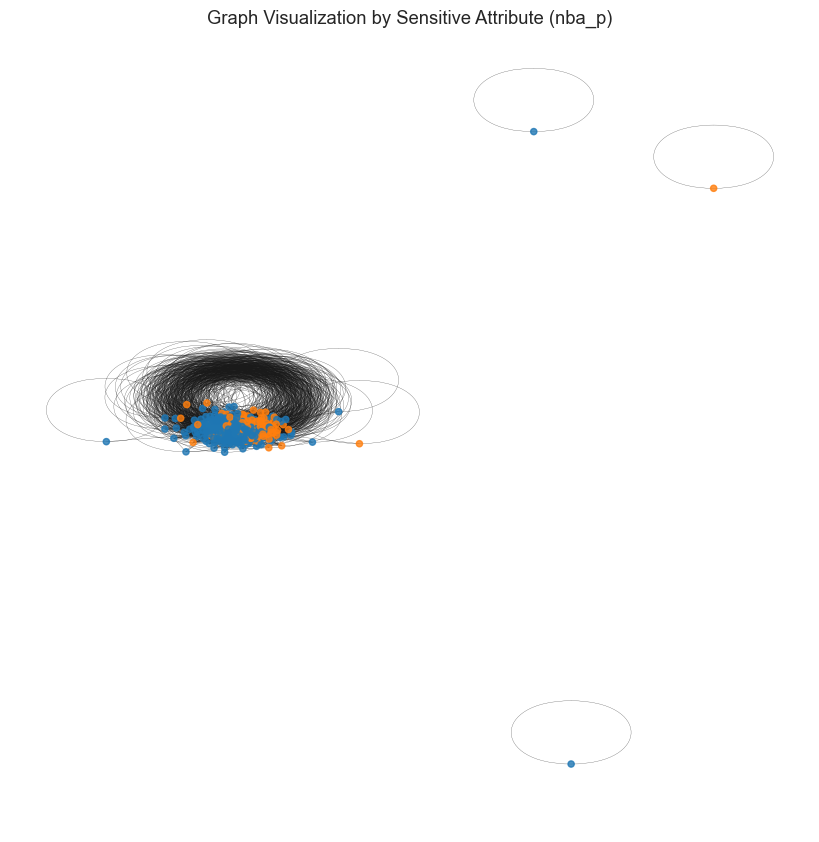

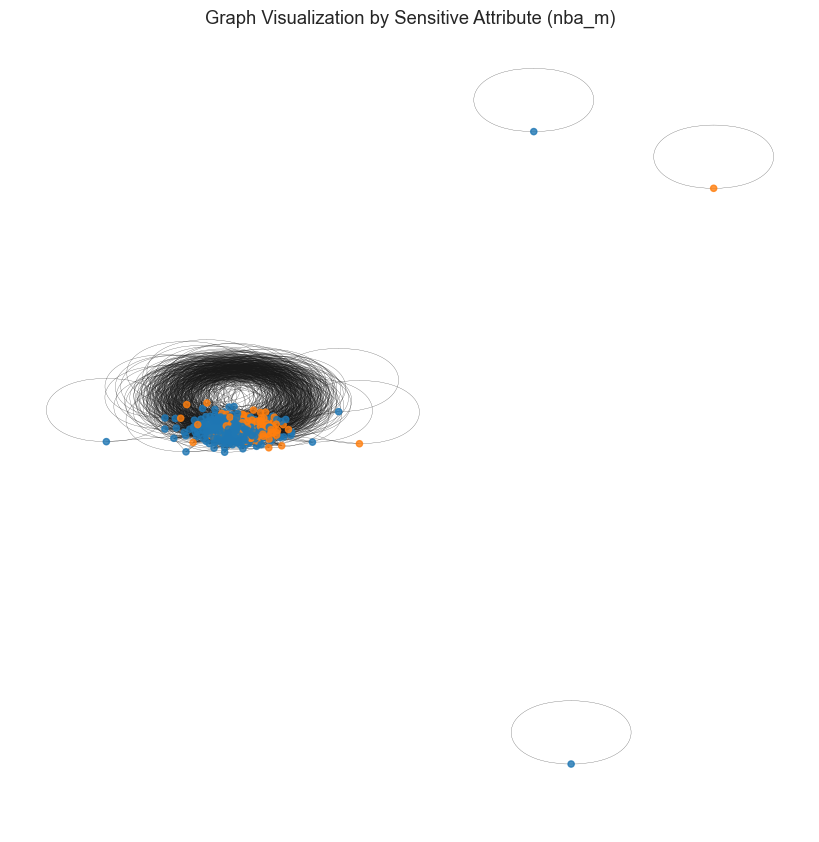

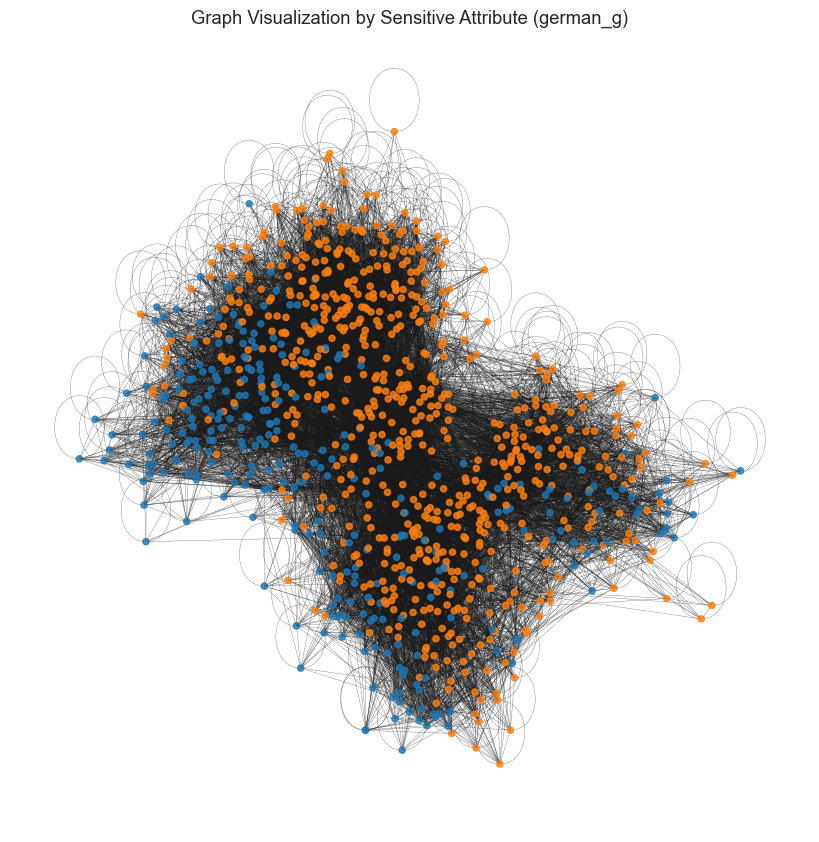

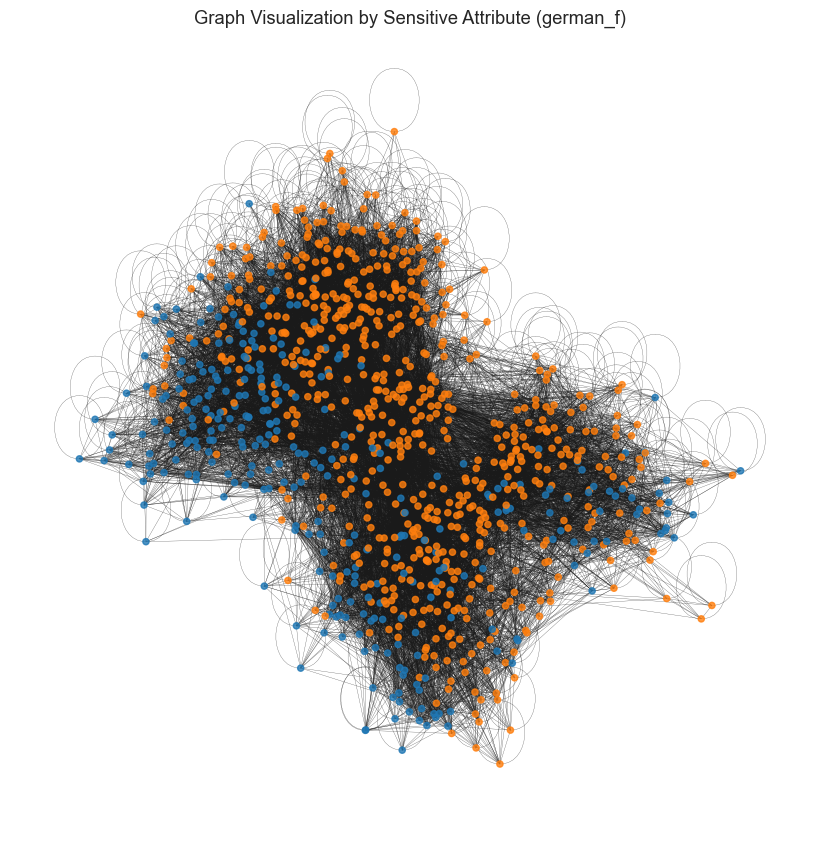

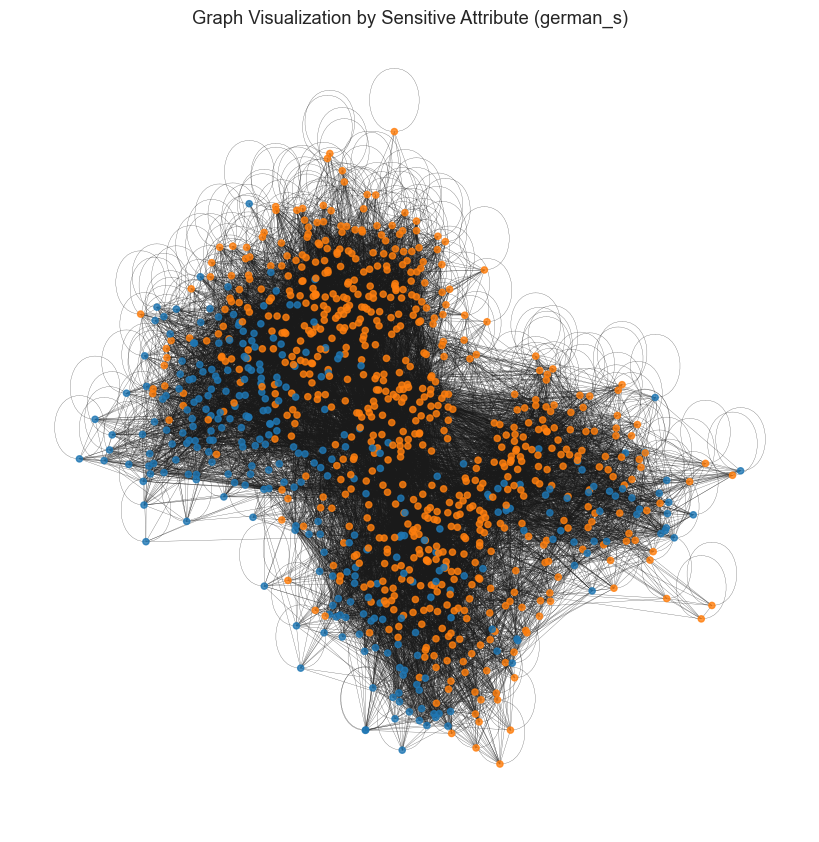

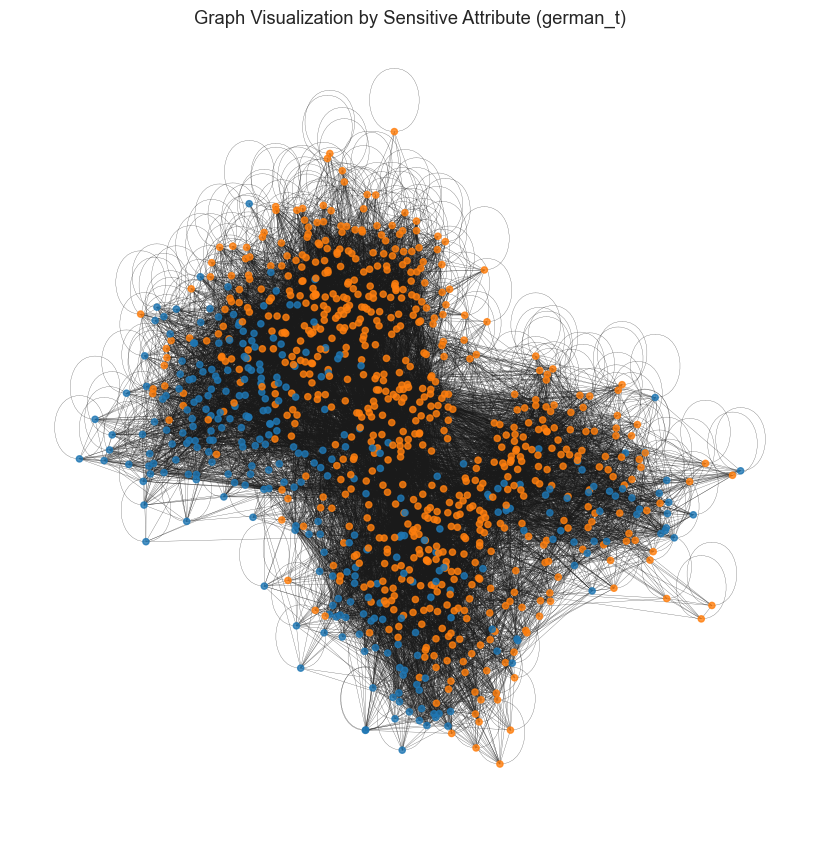

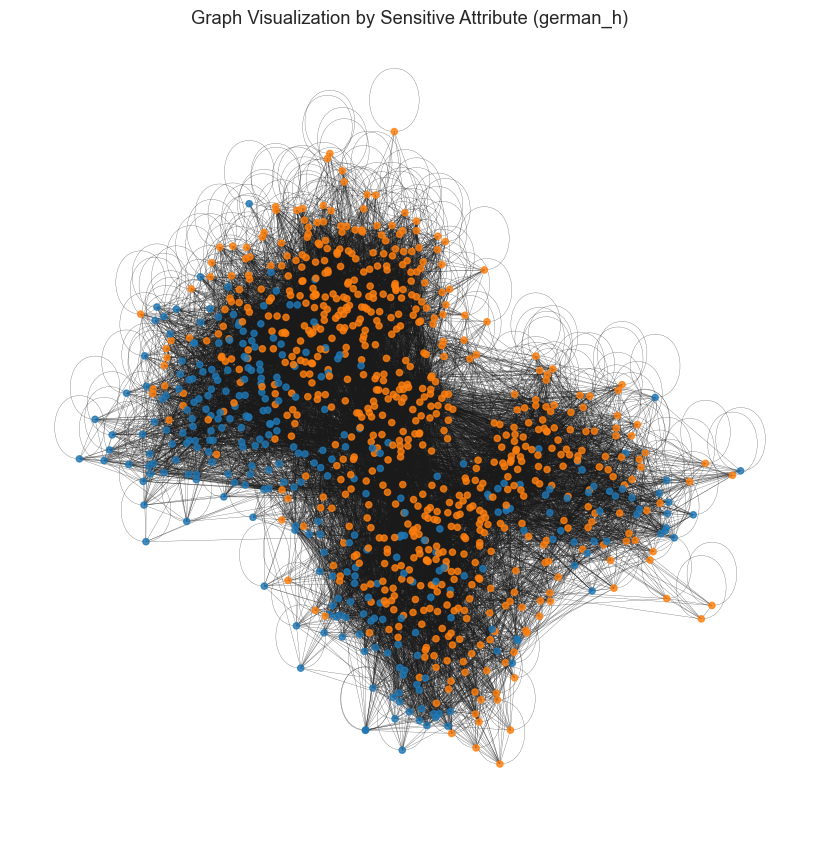

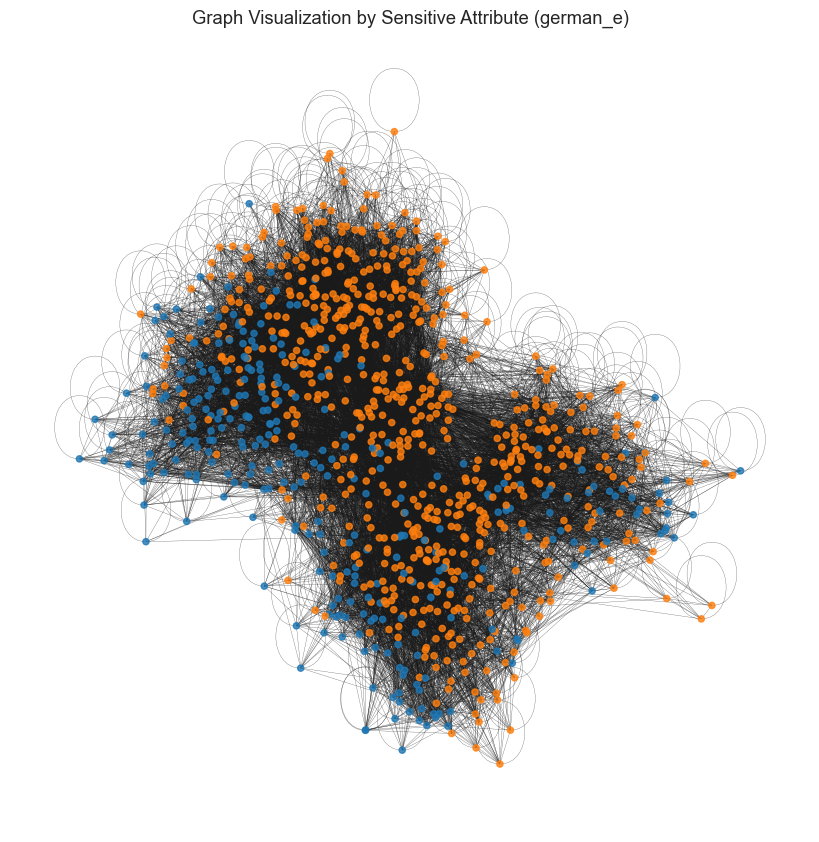

KeyboardInterrupt: 

<Figure size 800x800 with 0 Axes>

In [33]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

def draw_graph_by_sens(data, dataset_name=''):
    # PyG → NetworkX 그래프 변환
    G = to_networkx(data, to_undirected=True)
    sens = data.sensitive_attr.cpu().numpy()

    # 색상: 민감 속성에 따라 구분
    color_map = ['#1f77b4' if s == 0 else '#ff7f0e' for s in sens]

    # 그래프 시각화
    plt.figure(figsize=(8, 8))
    nx.draw(
        G, 
        node_color=color_map,
        node_size=20,
        width=0.2,
        alpha=0.8,
        with_labels=False,
        pos=nx.spring_layout(G, seed=42)  # layout은 고정 가능
    )
    plt.title(f"Graph Visualization by Sensitive Attribute ({dataset_name})")
    plt.axis('off')
    plt.show()

datasets = [
            'nba_p', 'nba_m', 
            'german_g', 'german_f', 'german_s', 'german_t', 'german_h', 'german_e'
            ,
            'region_job_r', 'region_job_g', 'region_job_2_r', 'region_job_2_g'
            ]
for ds in datasets:
    draw_graph_by_sens(data=all_data[ds]['data'], dataset_name=ds)

In [31]:
from tqdm import trange
datasets = [
            # 'nba_p', 'nba_m', 
            # 'german_g', 'german_f', 'german_s', 'german_t', 'german_h', 'german_e'
            # ,
            'region_job_r', 'region_job_g', 'region_job_2_r', 'region_job_2_g'
            ]

results = {}
for ds in datasets:
    data = all_data[ds]['data']
    df = all_data[ds]['df']
    
    model = GCNRegressor(in_channels=data.x.shape[1])
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    loss_fn = torch.nn.MSELoss()

    for epoch in trange(500, desc=f"Training {ds}"):
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = loss_fn(out[data.idx_train], data.y[data.idx_train])
        loss.backward()
        optimizer.step()
        
    model.eval()
    with torch.no_grad():
        y_pred = model(data.x, data.edge_index)
        
    df['y_pred'] = y_pred.cpu().numpy()
    df['sens'] = data.sensitive_attr.cpu().numpy()
    df['y'] = data.y.cpu().numpy()
    df['error'] = np.abs(df['y'] - df['y_pred'])
    df['degree'] = degree(data.edge_index[0], num_nodes=data.num_nodes).cpu().numpy()

    result = analyze_structural_bias_with_tests(data, df, sens_attr='sens', y_col='y', y_pred_col='y_pred')
    results[ds] = result

Training region_job_r: 100%|██████████| 500/500 [11:17<00:00,  1.36s/it]


[그룹별 구조 및 예측 요약 통계]
         degree             error        y_pred
           mean        std   mean    std    var
sens                                           
0.0   18.076000  23.427000  0.629  0.482   0.51
1.0   21.358999  26.044001  0.648  0.467   0.44
[통계 검정 결과]
  • t-test (오차 평균 차이):        p = 0.0000
  • Levene test (오차 분산 차이):   p = 0.1373
  • KS test (예측 분포 차이):       p = 0.0000


Training region_job_g: 100%|██████████| 500/500 [11:06<00:00,  1.33s/it]


[그룹별 구조 및 예측 요약 통계]
         degree             error        y_pred
           mean        std   mean    std    var
sens                                           
0.0   19.686001  24.688999  0.631  0.494  0.577
1.0   18.763000  24.150999  0.633  0.482  0.528
[통계 검정 결과]
  • t-test (오차 평균 차이):        p = 0.5768
  • Levene test (오차 분산 차이):   p = 0.0034
  • KS test (예측 분포 차이):       p = 0.0000


Training region_job_2_r: 100%|██████████| 500/500 [09:42<00:00,  1.16s/it]


[그룹별 구조 및 예측 요약 통계]
         degree          error        y_pred
           mean     std   mean    std    var
sens                                        
0.0   15.985000  21.136  0.617  0.491  0.569
1.0   17.886999  21.105  0.638  0.489  0.553
[통계 검정 결과]
  • t-test (오차 평균 차이):        p = 0.0000
  • Levene test (오차 분산 차이):   p = 0.6127
  • KS test (예측 분포 차이):       p = 0.0000


Training region_job_2_g: 100%|██████████| 500/500 [08:00<00:00,  1.04it/s]


[그룹별 구조 및 예측 요약 통계]
      degree          error        y_pred
        mean     std   mean    std    var
sens                                     
0.0   16.362  20.789  0.625  0.501  0.591
1.0   16.715  21.510  0.619  0.488  0.552
[통계 검정 결과]
  • t-test (오차 평균 차이):        p = 0.1676
  • Levene test (오차 분산 차이):   p = 0.0102
  • KS test (예측 분포 차이):       p = 0.0000


[idx_train] 총 33898개
  민감속성 0: 17154개 (50.6%)
  민감속성 1: 16744개 (49.4%)
------------------------------
[idx_val] 총 16949개
  민감속성 0: 8577개 (50.6%)
  민감속성 1: 8372개 (49.4%)
------------------------------
[idx_test] 총 16949개
  민감속성 0: 8577개 (50.6%)
  민감속성 1: 8372개 (49.4%)
------------------------------


## 제안 모델 구현

### 학습 전 데이터셋 평가

In [128]:
import torch
import numpy as np
import pandas as pd
import networkx as nx
import scipy.sparse as sp
from sklearn.metrics import mean_squared_error
from scipy.stats import wasserstein_distance
from torch_geometric.utils import to_networkx, to_scipy_sparse_matrix

def homophily_ratio(edge_index, sensitive_attr):
    edge_index = edge_index.cpu().numpy()
    sens = sensitive_attr.cpu().numpy()
    same = sum(sens[u] == sens[v] for u, v in zip(*edge_index))
    return same / edge_index.shape[1]

def assortativity_coefficient(data):
    G = to_networkx(data, to_undirected=True)
    nx.set_node_attributes(G, {i: int(data.sensitive_attr[i]) for i in range(data.num_nodes)}, "sensitive")
    return nx.attribute_assortativity_coefficient(G, "sensitive")

def local_neighborhood_fairness(edge_index, sensitive_attr):
    edge_index = edge_index.cpu().numpy()
    sens = sensitive_attr.cpu().numpy()
    diffs = []
    for node in range(len(sens)):
        neighbors = edge_index[1][edge_index[0] == node]
        if len(neighbors) > 0:
            local = sens[neighbors].mean()
            global_ = sens.mean()
            diffs.append(abs(local - global_))
    return np.mean(diffs)

def degree_balance(edge_index, sensitive_attr):
    num_nodes = sensitive_attr.size(0)
    degrees = np.bincount(edge_index[0].cpu().numpy(), minlength=num_nodes)
    sens = sensitive_attr.cpu().numpy()

    group0_degrees = degrees[sens == 0]
    group1_degrees = degrees[sens == 1]

    return abs(group0_degrees.mean() - group1_degrees.mean())

def normalize(mx):
    rowsum = np.array(mx.sum(1)).flatten()
    r_inv = np.power(rowsum, -1.0, where=rowsum != 0)
    r_mat_inv = sp.diags(r_inv)
    return r_mat_inv.dot(mx)

def structural_bias(features, edge_index, sens, num_hops=2, alpha=0.9):
    adj = to_scipy_sparse_matrix(edge_index, num_nodes=features.size(0)).tocsr()
    adj = adj + sp.eye(adj.shape[0])
    adj = normalize(adj)
    feat = features.cpu().numpy()
    feat_smooth = feat.copy()
    for _ in range(num_hops):
        feat_smooth = alpha * adj.dot(feat_smooth) + (1 - alpha) * feat
    sens = sens.cpu().numpy()
    s0 = feat_smooth[sens == 0]
    s1 = feat_smooth[sens == 1]
    emd = np.mean([wasserstein_distance(s0[:, i], s1[:, i]) for i in range(s0.shape[1])])
    return emd


In [129]:
# 결과 저장
results = {}

for ds in datasets:
    data = all_data[ds]['data']
    features = data.x
    edge_index = data.edge_index
    sens = data.sensitive_attr

    results[ds] = {
        "Homophily Ratio": homophily_ratio(edge_index, sensitive_attr),
        "Assortativity Coefficient": assortativity_coefficient(data),
        "Local Neighborhood Fairness": local_neighborhood_fairness(edge_index, sensitive_attr),
        "Degree Balance": degree_balance(edge_index, sensitive_attr),
        'Structural Bias': structural_bias(features, edge_index, sens)
    }

# 결과 출력
results_df = pd.DataFrame(results).T
print(results_df)

                Homophily Ratio  Assortativity Coefficient  \
german_e               0.680245                   0.536039   
german_f               0.680245                   0.536039   
german_g               0.680245                   0.536039   
german_h               0.680245                   0.536039   
german_s               0.680245                   0.536039   
german_t               0.680245                   0.536039   
nba_m                  0.656042                   0.232719   
nba_p                  0.656042                   0.232719   
region_job_2_g         0.571860                  -0.022346   
region_job_2_r         0.571860                   0.897273   
region_job_g           0.953181                  -0.042879   
region_job_r           0.953181                   0.901644   

                Local Neighborhood Fairness  Degree Balance  Structural Bias  
german_e                           0.150468        0.423652         0.174177  
german_f                           

In [ ]:
# Germans: 노드 간 군집 구조와 연결 밀도 차이가 존재하여, GNN 학습 시 민감 속성 그룹 간 표현 학습 차이가 발생할 가능성이 큽니다.
# → 공정성 문제는 그래프 구조 그 자체에서 유발될 수 있으므로, 구조적 보정이 필요합니다.

# NBA: NBA 데이터는 **연결 수 편향(degree imbalance)**이 심각하며, 민감 속성에 따른 정보 접근성 격차가 나타날 수 있음.
# → 특정 그룹은 학습 과정에서 메시지 전달의 중심에서 소외될 가능성.
# → Fair message passing 혹은 degree-aware 구조 보정이 필요함.

# Pokec: 
# 지역(region)이라는 속성이 그래프 구조 전반을 지배함.
# → GNN이 학습하는 표현은 거의 전적으로 지역 기반 편향을 내포하게 됨.
# → 지역 기준으로는 공정한 학습이 거의 불가능, 성별 기준이 상대적으로 구조 중립적.

# 성별은 구조적으로 중립, GNN이 민감 속성 정보를 구조적으로 학습하지 않게 설계 가능.
# → 성별 기준 학습 시 공정성 보장이 훨씬 쉬움.
# → 이 데이터셋에서는 민감 속성 선택 자체가 학습 공정성에 결정적 영향을 미침.

### 실험 평가

In [ ]:
# 평가 지표
# 회귀 모델의 공정성을 다차원적으로 분석

# 1. prediction-level: error gap
def error_gap(y_pred, y_true, sensitive_attr):
    """
    y_pred: Tensor[N]
    y_true: Tensor[N]
    sensitive_attr: Tensor[N] (binary: 0 or 1)
    """
    mask_0 = sensitive_attr == 0
    mask_1 = sensitive_attr == 1
    mae_0 = torch.abs(y_pred[mask_0] - y_true[mask_0]).mean()
    mae_1 = torch.abs(y_pred[mask_1] - y_true[mask_1]).mean()
    return torch.abs(mae_0 - mae_1).item()


# 2. distribution-level: wasserstein distance
# 예측값 분포의 전체 구조 차이를 직관적으로 수치화
# 평균적으로 얼마나 다른가라는 질문에 답함
def wasserstein_gap(y_pred, sensitive_attr):
    """
    y_pred: numpy array [N] or [N,1]
    sensitive_attr: numpy array [N]
    """
    y_pred = y_pred.squeeze()  # flatten to [N]
    pred_0 = y_pred[sensitive_attr == 0]
    pred_1 = y_pred[sensitive_attr == 1]
    return wasserstein_distance(pred_0, pred_1)

# 3. embedding-level: maximum mean discrepancy
# 민감 속성에 따라 임베딩 분포가 달라지는지를 정량적으로 비교
def gaussian_kernel(x, y, sigma=1.0):
    x = x.unsqueeze(1)  # [N,1,D]
    y = y.unsqueeze(0)  # [1,M,D]
    dist = ((x - y) ** 2).sum(2)
    return torch.exp(-dist / (2 * sigma ** 2))

def mmd_loss(x1, x2, sigma=1.0):
    Kxx = gaussian_kernel(x1, x1, sigma).mean()
    Kyy = gaussian_kernel(x2, x2, sigma).mean()
    Kxy = gaussian_kernel(x1, x2, sigma).mean()
    return Kxx + Kyy - 2 * Kxy

def compute_embedding_mmd(embedding, sensitive_attr):
    x1 = embedding[sensitive_attr == 0]
    x2 = embedding[sensitive_attr == 1]
    return mmd_loss(x1, x2)


# 4. neighborhood-level: graph consistency
# 연결된 노드는 예측값이 비슷해야 함
def neighborhood_consistency(y_pred, edge_index):
    """
    y_pred: Tensor[N]
    edge_index: Tensor[2, E] (edge list: [source, target])
    """
    src, tgt = edge_index
    diff = torch.abs(y_pred[src] - y_pred[tgt])
    return diff.mean().item()

def mean_gap(pred, sensitive_attr):
    """민감 그룹 간 예측값 평균 차이 계산"""
    mask_0 = (sensitive_attr == 0)
    mask_1 = (sensitive_attr == 1)
    pred_0 = pred[mask_0]
    pred_1 = pred[mask_1]
    return torch.abs(pred_0.mean() - pred_1.mean()) if pred_0.numel() > 0 and pred_1.numel() > 0 else torch.tensor(0.0, device=pred.device)

def mse_gap(pred, true, sensitive_attr):
    """민감 그룹 간 MSE 차이 계산"""
    mask_0 = (sensitive_attr == 0)
    mask_1 = (sensitive_attr == 1)
    pred_0, true_0 = pred[mask_0], true[mask_0]
    pred_1, true_1 = pred[mask_1], true[mask_1]
    mse_0 = mean_squared_error(true_0.cpu().numpy(), pred_0.cpu().numpy()) if true_0.numel() > 0 else 0
    mse_1 = mean_squared_error(true_1.cpu().numpy(), pred_1.cpu().numpy()) if true_1.numel() > 0 else 0
    return abs(mse_0 - mse_1)

def mae_gap(pred, true, sensitive_attr):
    """민감 그룹 간 MAE 차이 계산"""
    mask_0 = (sensitive_attr == 0)
    mask_1 = (sensitive_attr == 1)
    pred_0, true_0 = pred[mask_0], true[mask_0]
    pred_1, true_1 = pred[mask_1], true[mask_1]
    mae_0 = mean_absolute_error(true_0.cpu().numpy(), pred_0.cpu().numpy()) if true_0.numel() > 0 else 0
    mae_1 = mean_absolute_error(true_1.cpu().numpy(), pred_1.cpu().numpy()) if true_1.numel() > 0 else 0
    return abs(mae_0 - mae_1)

def variance_gap(pred, sensitive_attr):
    """민감 그룹 간 예측값 분산 차이 계산"""
    mask_0 = (sensitive_attr == 0)
    mask_1 = (sensitive_attr == 1)
    pred_0 = pred[mask_0]
    pred_1 = pred[mask_1]
    var_0 = torch.var(pred_0) if pred_0.numel() > 1 else torch.tensor(0.0, device=pred.device)
    var_1 = torch.var(pred_1) if pred_1.numel() > 1 else torch.tensor(0.0, device=pred.device)
    return torch.abs(var_0 - var_1)

def ks_gap(pred_np, sens_np):
    """민감 그룹 간 KS 통계량 계산"""
    pred_0 = pred_np[sens_np == 0]
    pred_1 = pred_np[sens_np == 1]
    return ks_2samp(pred_0, pred_1).statistic if len(pred_0) > 0 and len(pred_1) > 0 else 0.0

In [ ]:
# 모델 비교 평가
model_names = ['FairRegGNN', 'FairGNN', 'FMP', 'GMMD', 'EDITS',
               'MLPRegressor', 'GCNRegressor', 'GATRegressor', 'GraphSAGERegressor', 'GINRegressor']
model_folder_map = {
    'FairRegGNN': 'fairreggnn',
    'FairGNN': 'fairgnn',
    'FMP': 'fmp',
    'EDTIS': 'edits', 
    'GMMD': 'gmmd',
    'MLPRegressor': 'mlp',
    'GCNRegressor': 'gcn',
    'GATRegressor': 'gat',
    'GraphSAGERegressor': 'sage',
    'GINRegressor': 'gin'
}


for model_name in model_names:
    print(f'\n>>> Evaluating model: {model_name}')
    results[model_name] = {}

    for ds in datasets:
        data = all_data[ds]['data']
        cfg = all_data[ds]['cfg']
        data = data.to(device)
        dn = cfg['dn']

        model_path = f'./model/{model_folder_map[model_name]}/{dn}_md.pth'
        print(f'  Dataset: {ds}, loading from: {model_path}')

        performances = []
        for run in range(runs):
            # 모델 정의
            if model_name == 'FairRegGNN':
                model = FairRegGNN(
                        nfeat=data.x.size(1), hidden_dim=hidden_dim, dropout=dropout,
                        lambda2=lambda2, lambda_dist=lambda_dist, alpha=alpha, lr=lr
                    ).to(device)
            elif model_name == 'FairGNN':
                model = FairGNN(
                    nfeat=data.x.size(1), 
                    hidden_dim=fair_hidden_dim, 
                    model=fair_model, 
                    dropout=fair_dropout, 
                    hidden=fair_hidden, 
                    lr=lr, 
                    weight_decay=weight_decay, 
                    alpha=fair_alpha, 
                    beta=fair_beta
                ).to(device)
            elif model_name == 'FMP':
                model = fmp_model(
                    data, fmp_num_layers, fmp_lambda1, fmp_lambda2, 
                    fmp_L2, fmp_hidden_dim, fmp_num_gnn_layer, 
                    fmp_n_classes, fmp_dropout, fmp_cached
                ).to(device)                
            elif model_name == 'GMMD':
                model = GMMDNet(in_channels=data.num_features,
                        hidden_channels=64,
                        out_channels=1).to(device)
            elif model_name == 'EDITS':
                model = EDITS(nfeat=data.x.size(1), 
                              node_num=data.x.size(0), nfeat_out=int(data.x.size(0) / 10), 
                              adj_lambda=1e-1, nclass=1, lr=0.003, weight_decay=1e-7, 
                              layer_threshold=2, dropout=0.2).to(device)
            elif model_name == 'MLPRegressor':
                model = MLPRegressor(in_dim=data.x.size(1)).to(device)
            elif model_name == 'GCNRegressor':
                model = GCNRegressor(in_dim=data.x.size(1)).to(device)
            elif model_name == 'GATRegressor':
                model = GATRegressor(in_dim=data.x.size(1)).to(device)
            elif model_name == 'GraphSAGERegressor':
                model = GraphSAGERegressor(in_dim=data.x.size(1)).to(device)
            elif model_name == 'GINRegressor':
                model = GINRegressor(in_dim=data.x.size(1)).to(device)

            # 파라미터 로딩 및 평가
            model.load_state_dict(torch.load(model_path))
            model.eval()

            with torch.no_grad():
                if model_name == 'FairRegGNN':
                    raw_output = model(data.x, data.edge_index, data.sensitive_attr)
                elif model_name == 'GMMD':
                    raw_output, _ = model(data)
                elif model_name == 'EDITS':
                    _, _, raw_output, _, _ = model(data.adj, data.features)
                else:
                    raw_output = model(data)

                # 예측값과 임베딩 분리
                if isinstance(raw_output, tuple):
                    embedding, output = raw_output
                elif isinstance(raw_output, dict):
                    output = raw_output['pred']
                    embedding = raw_output.get('embedding', None)
                else:
                    output = raw_output
                    embedding = getattr(model, 'embedding', None)

                output = output.squeeze()  # 예측값이 (N,1)인 경우 대비

                # 전체 output 기준으로 graph-level 평가 먼저 수행
                neighbor_cons = neighborhood_consistency(output, data.edge_index)

                # 나머지는 test set 기준
                idx_test = data.idx_test.to(torch.long)
                y_true = data.y
                sensitive_attr = data.sensitive_attr

                pred_test = output[idx_test]
                true_test = y_true[idx_test]
                sens_test = sensitive_attr[idx_test]

                # 1. Error Gap (prediction-level)
                err_gap = error_gap(pred_test, true_test, sens_test)

                # 2. Wasserstein Gap (distribution-level)
                pred_np = pred_test.cpu().numpy().squeeze()
                sens_np = sens_test.cpu().numpy()
                wass_gap = wasserstein_gap(pred_np, sens_np)

                # 3. 추가 메트릭
                mean_gap_val = mean_gap(pred_test, sens_test).item()
                mse_gap_val = mse_gap(pred_test, true_test, sens_test)
                mae_gap_val = mae_gap(pred_test, true_test, sens_test)
                var_gap_val = variance_gap(pred_test, sens_test).item()
                ks_gap_val = ks_gap(pred_np, sens_np)

                overall_mse = mean_squared_error(true_test.cpu().numpy(), pred_test.cpu().numpy())

                # 결과 출력 (또는 저장)
                metrics = [overall_mse, neighbor_cons, err_gap, wass_gap, mean_gap_val, mse_gap_val, mae_gap_val, var_gap_val, ks_gap_val]

        results[model_name][ds] = metrics

# 성능 지표 이름
metric_names = ['MSE', 'Neighborhood Consistency', 'Error Gap', 'Wasserstein Gap',
    'Mean Gap', 'MSE Gap', 'MAE Gap', 'Var Gap', 'KS Gap'
]

# 데이터를 저장할 리스트
rows = []

# 반복
for model_name, datasets_result in results.items():
    for ds_name, metric_values in datasets_result.items():
        metric_list = list(metric_values)  # set -> list
        metric_list.sort()  # 정렬: 지표 순서가 고정되어 있다고 가정

        # 지표 수와 불일치하면 경고
        if len(metric_list) != len(metric_names):
            print(f"[경고] {model_name} - {ds_name}: 지표 수 불일치 ({len(metric_list)} vs {len(metric_names)})")
            continue

        # 결과 저장
        for i, metric_name in enumerate(metric_names):
            value = metric_list[i]
            rows.append({
                'Model': model_name,
                'Dataset': ds_name,
                'Metric': metric_name,
                'Mean': value,
                'Std': 0.0  # 현재 set 값은 단일 run 결과이므로 std 없음
            })

# 데이터프레임 생성
df = pd.DataFrame(rows)
df = df.sort_values(by=['Metric', 'Dataset', 'Model']).reset_index(drop=True)


In [ ]:
# 성능 결과 출력
for ds in datasets:
    filtered_df = df[(df['Dataset'] == ds) & (df['Model'].isin(['FMP', 'FairGNN', 'FairRegGNN', 'GMMD']))]
    print(filtered_df)


In [19]:
from scipy.stats import wasserstein_distance
from scipy.spatial.distance import jensenshannon
from sklearn.metrics import mutual_info_score

def mmd(x0, x1, alpha=1.0):
    def rbf_kernel(x, y):
        dists = ((x[:, None] - y[None, :]) ** 2).sum(-1)
        return np.exp(-alpha * dists)
    return rbf_kernel(x0, x0).mean() + rbf_kernel(x1, x1).mean() - 2 * rbf_kernel(x0, x1).mean()

def mmd_sampled(x0, x1, sample_size=500, alpha=1.0):
    import numpy as np
    if len(x0) > sample_size:
        idx0 = np.random.choice(len(x0), sample_size, replace=False)
        x0 = x0[idx0]
    if len(x1) > sample_size:
        idx1 = np.random.choice(len(x1), sample_size, replace=False)
        x1 = x1[idx1]
    return mmd(x0, x1, alpha)

def representation_bias_score(embedding, sens):
    return mutual_info_score(sens.cpu().numpy(), embedding.argmax(dim=1).cpu().numpy())

def output_fairness(preds, sens):
    p0 = preds[sens == 0].cpu().numpy()
    p1 = preds[sens == 1].cpu().numpy()
    return {
        "mean_diff": abs(p0.mean() - p1.mean()),
        "mae_gap": abs(np.mean(abs(p0 - p0.mean())) - np.mean(abs(p1 - p1.mean()))),
        "mse_gap": abs(np.mean((p0 - p0.mean()) ** 2) - np.mean((p1 - p1.mean()) ** 2)),
        "wasserstein": wasserstein_distance(p0, p1),
        "js_divergence": jensenshannon(np.histogram(p0, bins=30, density=True)[0] + 1e-10,
                                       np.histogram(p1, bins=30, density=True)[0] + 1e-10)
    }

def heterophilic_edge_ratio(edge_index, sensitive_attr):
    edge_index = edge_index.cpu().numpy()
    sens = sensitive_attr.cpu().numpy()
    hetero_edges = sum(sens[u] != sens[v] for u, v in zip(*edge_index))
    return hetero_edges / edge_index.shape[1]

In [21]:
from torch_geometric.utils import to_scipy_sparse_matrix, from_scipy_sparse_matrix
import torch
import scipy.sparse as sp
import torch

def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """scipy sparse matrix -> torch sparse tensor"""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)


In [22]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import torch

def visualize_embedding(embedding, sens_attr, method='tsne', title='Embedding Visualization', save_path=None):
    """
    Parameters:
        embedding: torch.Tensor or np.ndarray, shape [N, d]
        sens_attr: torch.Tensor or np.ndarray, shape [N], 0/1 등으로 구분
        method: 'tsne' or 'pca'
        title: plot title
        save_path: 저장할 경로 (None이면 show)
    """
    embedding = embedding.detach().cpu().numpy() if isinstance(embedding, torch.Tensor) else embedding
    sens_attr = sens_attr.detach().cpu().numpy() if isinstance(sens_attr, torch.Tensor) else sens_attr

    if method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42, perplexity=30)
    elif method == 'pca':
        reducer = PCA(n_components=2)
    else:
        raise ValueError("method must be 'tsne' or 'pca'")

    reduced = reducer.fit_transform(embedding)

    plt.figure(figsize=(7, 6))
    for label in np.unique(sens_attr):
        plt.scatter(
            reduced[sens_attr == label, 0],
            reduced[sens_attr == label, 1],
            label=f'Sensitive={label}',
            alpha=0.6
        )
    plt.legend()
    plt.title(title)
    plt.xlabel('Dim 1')
    plt.ylabel('Dim 2')
    plt.grid(True)

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    else:
        plt.show()


# 예: 학습된 임베딩, 민감 속성 사용
# visualize_embedding(
#     embedding=embedding,  # torch.Tensor shape [N, d]
#     sens_attr=data.sensitive_attr,
#     method='tsne',
#     title=f'{model_name} on {ds}'
# )

In [23]:
# 모델 비교 평가
model_names = [
    'FairRegGNN', 'FairGNN', 'FMP', 'GMMD', 'EDITS',
    'MLPRegressor', 'GCNRegressor', 'GATRegressor', 'GraphSAGERegressor', 'GINRegressor'
    ]
model_folder_map = {
    'FairRegGNN': 'fairreggnn',
    'FairGNN': 'fairgnn',
    'FMP': 'fmp',
    'EDITS': 'edits', 
    'GMMD': 'gmmd',
    'MLPRegressor': 'mlp',
    'GCNRegressor': 'gcn',
    'GATRegressor': 'gat',
    'GraphSAGERegressor': 'sage',
    'GINRegressor': 'gin'
}

datasets = [
    'region_job_r', 'region_job_g', 'region_job_2_r', 'region_job_2_g', 
            'nba_p', 'nba_m', 'german_g', 'german_f', 'german_s', 'german_t', 'german_h', 'german_e']

# 결과 저장
results = []

for model_name in model_names:
    print(f'\n>>> Evaluating model: {model_name}')
    for ds in datasets:
        data = all_data[ds]['data']
        cfg = all_data[ds]['cfg']
        data = data.to(device)
        model_dir = model_folder_map[model_name]
        dn = cfg['dn']

        if model_dir is None:
            print(f"  [SKIP] No model directory for: {model_name}")
            continue

        model_path = f'./model/{model_dir}/{dn}_md.pth'
        if not os.path.exists(model_path):
            print(f"  [SKIP] Model checkpoint not found: {model_path}")
            continue
        print(f'  Dataset: {ds}, loading from: {model_path}')

        if model_name == 'FairRegGNN':
            model = FairRegGNN(
                    nfeat=data.x.size(1), hidden_dim=hidden_dim, dropout=dropout,
                    lambda2=lambda2, lambda_dist=lambda_dist, alpha=alpha, lr=lr
                ).to(device)
        elif model_name == 'FairGNN':
            model = FairGNN(
                nfeat=data.x.size(1), 
                hidden_dim=fair_hidden_dim, 
                model=fair_model, 
                dropout=fair_dropout, 
                hidden=fair_hidden, 
                lr=lr, 
                weight_decay=weight_decay, 
                alpha=fair_alpha, 
                beta=fair_beta
            ).to(device)
        elif model_name == 'FMP':
            model = fmp_model(
                data, fmp_num_layers, fmp_lambda1, fmp_lambda2, 
                fmp_L2, fmp_hidden_dim, fmp_num_gnn_layer, 
                fmp_n_classes, fmp_dropout, fmp_cached
            ).to(device)                
        elif model_name == 'GMMD':
            model = GMMDNet(in_channels=data.num_features,
                    hidden_channels=64,
                    out_channels=1).to(device)
        elif model_name == 'EDITS':
            model = EDITS(nfeat=data.x.size(1), 
                            node_num=data.x.size(0), nfeat_out=int(data.x.size(0) / 10), 
                            adj_lambda=1e-1, nclass=1, lr=0.003, weight_decay=1e-7, 
                            layer_threshold=2, dropout=0.2).to(device)
        elif model_name == 'MLPRegressor':
            model = MLPRegressor(in_dim=data.x.size(1)).to(device)
        elif model_name == 'GCNRegressor':
            model = GCNRegressor(in_dim=data.x.size(1)).to(device)
        elif model_name == 'GATRegressor':
            model = GATRegressor(in_dim=data.x.size(1)).to(device)
        elif model_name == 'GraphSAGERegressor':
            model = GraphSAGERegressor(in_dim=data.x.size(1)).to(device)
        elif model_name == 'GINRegressor':
            model = GINRegressor(in_dim=data.x.size(1)).to(device)

        model.load_state_dict(torch.load(model_path), strict=False)

        model.eval()

        with torch.no_grad():
            if model_name == 'FairRegGNN':
                raw_output = model(data.x, data.edge_index, data.sensitive_attr)
            elif model_name == 'GMMD':
                raw_output, _ = model(data)
            elif model_name == 'EDITS':
                adj_sparse = to_scipy_sparse_matrix(data.edge_index).tocoo()
                adj = sparse_mx_to_torch_sparse_tensor(adj_sparse).to(device)
                features = data.x
                if not hasattr(model.adj_renew, "estimator"):
                    model.adj_renew.fit(adj, lr=0.003)
                raw_output = model(adj, features)[2]
            else:
                raw_output = model(data)

            if isinstance(raw_output, tuple):
                embedding, output = raw_output
            elif isinstance(raw_output, dict):
                output = raw_output['pred']
                embedding = raw_output.get('embedding', None)
            else:
                output = raw_output
                embedding = getattr(model, 'embedding', None)

            output = output.squeeze()
            idx_test = data.idx_test.long()
            pred_test = output[idx_test]
            y_true = data.y[idx_test]
            sens = data.sensitive_attr[idx_test]

            # Output Fairness
            fair = output_fairness(pred_test, sens)

            # Representation Fairness (on all)
            # rep_mmd = mmd(
            #     embedding[data.sensitive_attr == 0].cpu().numpy(),
            #     embedding[data.sensitive_attr == 1].cpu().numpy()
            # ) if embedding is not None else None

            rep_mmd = mmd_sampled(
                embedding[data.sensitive_attr == 0].cpu().numpy(),
                embedding[data.sensitive_attr == 1].cpu().numpy()
            ) if embedding is not None else None

            rep_bias = representation_bias_score(embedding, data.sensitive_attr) if embedding is not None else None

            # 저장
            results.append({
                "Model": model_name,
                "Dataset": ds,
                "MMD": rep_mmd,
                "RepBias": rep_bias,
                "MeanDiff": fair["mean_diff"],
                "MAE Gap": fair["mae_gap"],
                "MSE Gap": fair["mse_gap"],
                "Wasserstein": fair["wasserstein"],
                "JS Divergence": fair["js_divergence"]
            })


>>> Evaluating model: FairRegGNN
  Dataset: region_job_r, loading from: ./model/fairreggnn/Pokec_z_Region_md.pth
  Dataset: region_job_g, loading from: ./model/fairreggnn/Pokec_z_Gender_md.pth
  Dataset: region_job_2_r, loading from: ./model/fairreggnn/Pokec_n_Region_md.pth
  Dataset: region_job_2_g, loading from: ./model/fairreggnn/Pokec_n_Gender_md.pth
  Dataset: nba_p, loading from: ./model/fairreggnn/NBA(PIE)_Country_md.pth
  Dataset: nba_m, loading from: ./model/fairreggnn/NBA(MPG)_Country_md.pth
  Dataset: german_g, loading from: ./model/fairreggnn/German_Gender_md.pth
  Dataset: german_f, loading from: ./model/fairreggnn/German_ForeignWorker_md.pth
  Dataset: german_s, loading from: ./model/fairreggnn/German_Single_md.pth
  Dataset: german_t, loading from: ./model/fairreggnn/German_HasTelephone_md.pth
  Dataset: german_h, loading from: ./model/fairreggnn/German_OwnsHouse_md.pth
  Dataset: german_e, loading from: ./model/fairreggnn/German_Unemployed_md.pth

>>> Evaluating model:

In [24]:
df = pd.DataFrame(results)
df = df.sort_values(by=["Dataset", "Model"]).reset_index(drop=True)
df

Model       Dataset       MMD   RepBias   MeanDiff  \
0                 EDITS      german_e       NaN       NaN  32.747822   
1                   FMP      german_e       NaN       NaN   0.194678   
2               FairGNN      german_e  0.011616  0.000000   0.008976   
3            FairRegGNN      german_e  0.081427  0.137839   0.006628   
4          GATRegressor      german_e       NaN       NaN   0.235950   
..                  ...           ...       ...       ...        ...   
111        GCNRegressor  region_job_r       NaN       NaN   0.067776   
112        GINRegressor  region_job_r       NaN       NaN   0.099459   
113                GMMD  region_job_r       NaN       NaN   0.074819   
114  GraphSAGERegressor  region_job_r       NaN       NaN   0.081828   
115        MLPRegressor  region_job_r       NaN       NaN   0.077692   

      MAE Gap     MSE Gap  Wasserstein  JS Divergence  
0    3.363049  821.775757    33.139840       0.353844  
1    0.074347    0.048968     0.194941       0.377871  
2    0.001671    0.000014     0.009102       0.375738  
3    0.005616    0.000541     0.009653       0.299543  
4    0.098849    0.084302     0.245566       0.283365  
..        ...         ...          ...            ...  
111  0.042245    0.064154     0.081996       0.313836  
112  0.023076    0.021043     0.099744       0.697223  
113  0.013625    0.015847     0.076001       0.108748  
114  0.011237    0.010258     0.082661       0.105434  
115  0.014191    0.016368     0.078543       0.063166  

[116 rows x 9 columns]

In [25]:
df.to_csv('250528.csv')

In [ ]:
# 성능 결과 출력
for ds in datasets:
    print(df)

                  Model       Dataset       MMD   RepBias   MeanDiff  \
0                 EDITS      german_e       NaN       NaN  32.747822   
1                   FMP      german_e       NaN       NaN   0.194678   
2               FairGNN      german_e  0.006350  0.000000   0.008976   
3            FairRegGNN      german_e  0.081398  0.137839   0.006628   
4          GATRegressor      german_e       NaN       NaN   0.235950   
..                  ...           ...       ...       ...        ...   
111        GCNRegressor  region_job_r       NaN       NaN   0.067776   
112        GINRegressor  region_job_r       NaN       NaN   0.099459   
113                GMMD  region_job_r       NaN       NaN   0.074819   
114  GraphSAGERegressor  region_job_r       NaN       NaN   0.081828   
115        MLPRegressor  region_job_r       NaN       NaN   0.077692   

      MAE Gap     MSE Gap  Wasserstein  JS Divergence  
0    3.363049  821.775757    33.139840       0.353844  
1    0.074347    0.0489

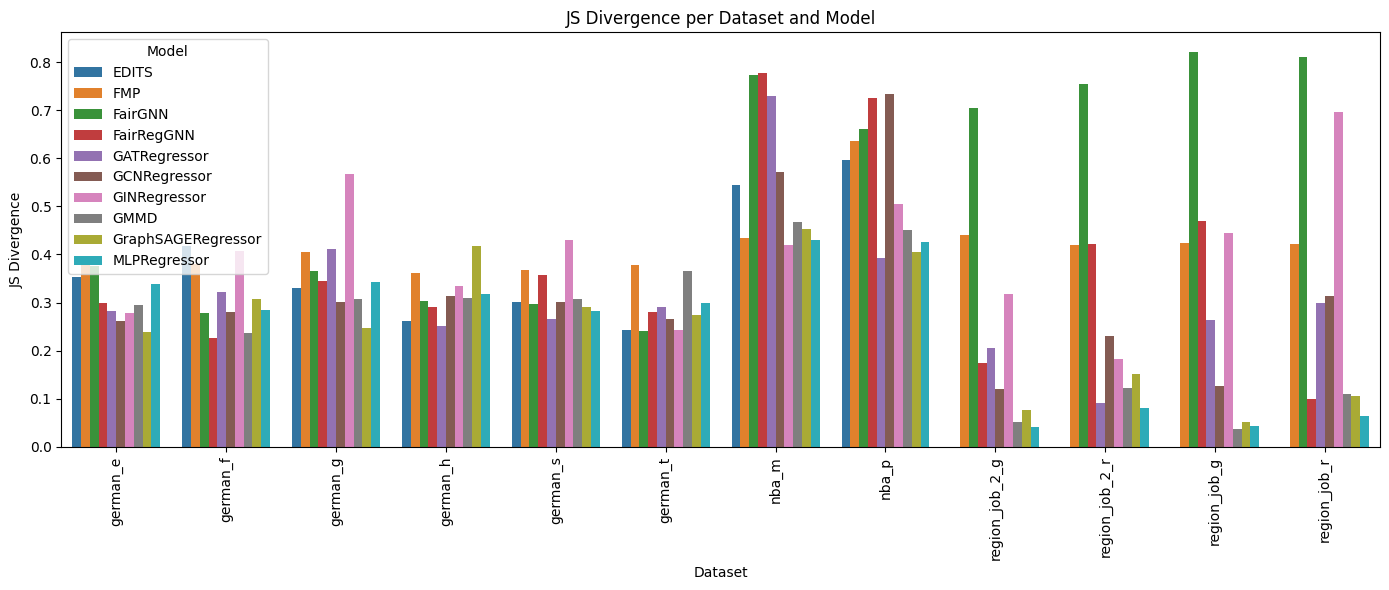

In [170]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
sns.barplot(data=df, x='Dataset', y='JS Divergence', hue='Model')
plt.xticks(rotation=90)
plt.title('JS Divergence per Dataset and Model')
plt.tight_layout()
plt.show()


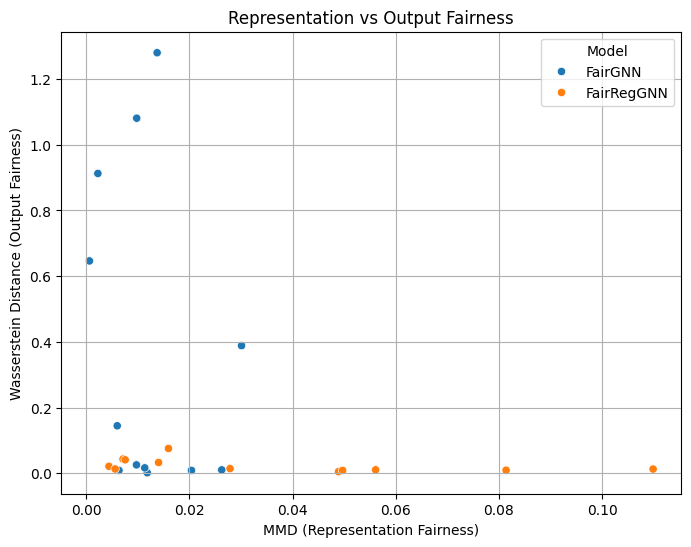

In [171]:
plt.figure(figsize=(8, 6))
subset = df.dropna(subset=['MMD', 'Wasserstein'])
sns.scatterplot(data=subset, x='MMD', y='Wasserstein', hue='Model')
plt.title('Representation vs Output Fairness')
plt.xlabel('MMD (Representation Fairness)')
plt.ylabel('Wasserstein Distance (Output Fairness)')
plt.grid(True)
plt.show()


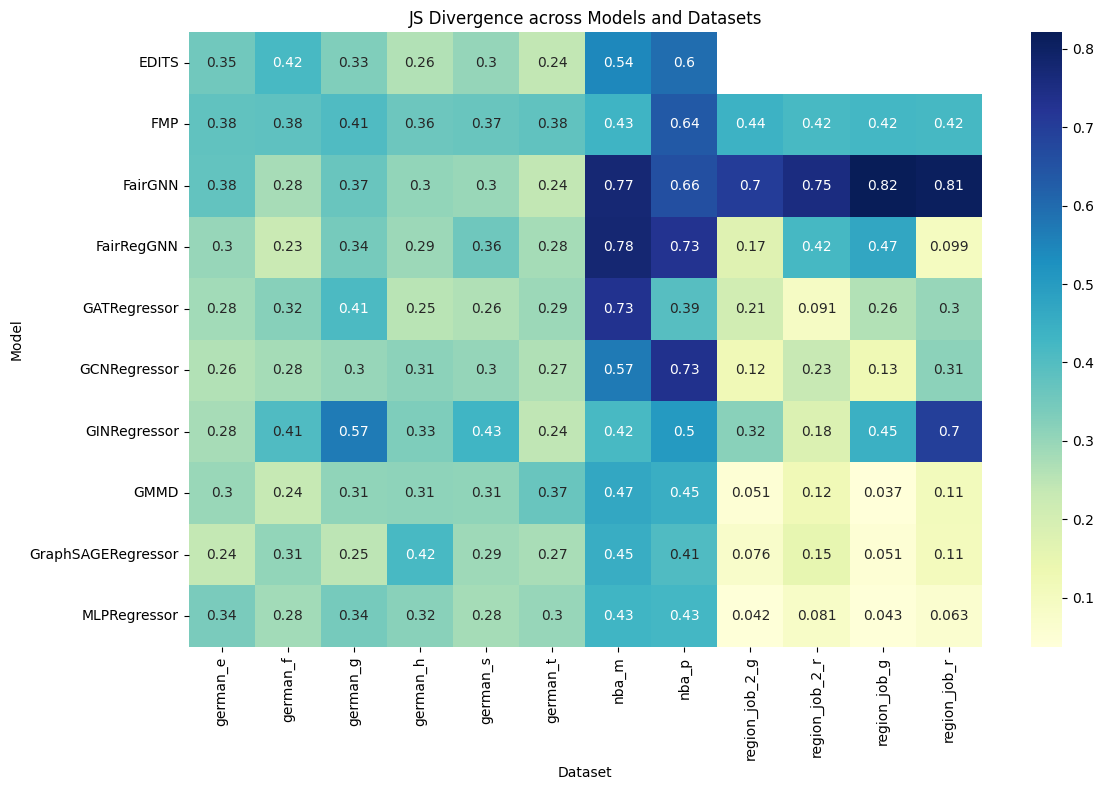

In [ ]:
heat_data = df.pivot_table(index='Model', columns='Dataset', values='JS Divergence')
plt.figure(figsize=(12, 8))
sns.heatmap(heat_data, annot=`True, cmap='YlGnBu')
plt.title("JS Divergence across Models and Datasets")
plt.tight_layout()
plt.show()


### 학습

In [16]:
# 비교 모델
class MLPRegressor(nn.Module):
    def __init__(self, in_dim, hidden_dim=64):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, 1)

    def forward(self, data):
        x = data.x  # edge_index 무시
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.out(x).squeeze(-1)

class GCNRegressor(nn.Module):
    def __init__(self, in_dim, hidden_dim=64):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, 1)  # 단일 회귀 출력

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        return self.fc(x).squeeze(-1)  # [N] 형태

class GATRegressor(nn.Module):
    def __init__(self, in_dim, hidden_dim=64, heads=1):
        super().__init__()
        self.gat1 = GATConv(in_dim, hidden_dim, heads=heads)
        self.gat2 = GATConv(hidden_dim * heads, hidden_dim, heads=1)
        self.out = nn.Linear(hidden_dim, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.elu(self.gat1(x, edge_index))
        x = F.elu(self.gat2(x, edge_index))
        return self.out(x).squeeze(-1)

class GraphSAGERegressor(nn.Module):
    def __init__(self, in_dim, hidden_dim=64):
        super().__init__()
        self.sage1 = SAGEConv(in_dim, hidden_dim)
        self.sage2 = SAGEConv(hidden_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.sage1(x, edge_index))
        x = F.relu(self.sage2(x, edge_index))
        return self.out(x).squeeze(-1)

class GINRegressor(nn.Module):
    def __init__(self, in_dim, hidden_dim=64):
        super().__init__()
        nn1 = nn.Sequential(nn.Linear(in_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, hidden_dim))
        nn2 = nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, hidden_dim))
        self.gin1 = GINConv(nn1)
        self.gin2 = GINConv(nn2)
        self.out = nn.Linear(hidden_dim, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.gin1(x, edge_index)
        x = self.gin2(x, edge_index)
        return self.out(x).squeeze(-1)

In [17]:
# 학습 설정
runs=1
epochs = 500

lr=0.001
weight_decay=1e-5

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

seed=1127
cuda=torch.cuda.is_available()
np.random.seed(seed)
torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)

datasets = ['region_job_r', 'region_job_g', 'region_job_2_r', 'region_job_2_g', 
            'nba_p', 'nba_m', 
            'german_g', 'german_f', 'german_s', 'german_t', 'german_h', 'german_e']

# 모델별 학습 설정

# FairGNN 모델 설정
fair_alpha=4
fair_beta=0.01
fair_hidden=128
fair_dropout=0.5
fair_hidden_dim=64
fair_model='GCN'
fair_fastmode=False

# FMP 모델 설정
fmp_lambda1=3
fmp_lambda2=3
fmp_n_classes=1  
fmp_dropout=0.5
fmp_num_layers=5
fmp_hidden_dim=64
fmp_num_gnn_layer=2
fmp_L2=True
fmp_cached=False

hidden_dim=64
dropout=0.5 
lambda2=3
lambda_dist=1
alpha=4
fair_weight=0.5
w_mse_diff=0.5
w_mean_diff=0.5
w_wasserstein=0.5

Using device: cuda:0


In [18]:
class GroupWiseNorm(nn.Module):
    def __init__(self):
        super(GroupWiseNorm, self).__init__()

    def forward(self, pred, sensitive_attr):
        # 민감 속성 그룹 간 분포가 다르다는 것은 bias가 있을 수 있다는 뜻이고, 이를 fairness 관점에서 줄이려는 것
        # 두 그룹의 representation의 분포를 가깝게
        mask_0 = (sensitive_attr == 0).squeeze()
        mask_1 = (sensitive_attr == 1).squeeze()
        pred_0 = pred[mask_0]
        pred_1 = pred[mask_1]
        mean_diff = torch.abs(pred_0.mean() - pred_1.mean()) if pred_0.numel() > 0 and pred_1.numel() > 0 else 0
        var_diff = torch.abs(pred_0.var() - pred_1.var()) if pred_0.numel() > 0 and pred_1.numel() > 0 else 0
        return mean_diff + var_diff

class FairRegGNN(nn.Module):
    def __init__(self, nfeat, hidden_dim=64, dropout=0.5, lr=0.001, weight_decay=1e-5, 
                 lambda2=3, lambda_dist=1, alpha=4, mmd_sample_size=500):
        super(FairRegGNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.dropout = dropout
        self.lambda2 = lambda2
        self.lambda_dist = lambda_dist
        self.alpha = alpha
        self.mmd_sample_size = mmd_sample_size

        self.gcn1 = GCNConv(nfeat, hidden_dim)
        self.gcn2 = GCNConv(hidden_dim, hidden_dim)
        self.classifier = nn.Linear(hidden_dim, 1)

        self.group_norm = GroupWiseNorm()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)
        self.criterion = nn.MSELoss()

    def compute_mmd(self, h, sensitive_attr):
        # adversarial loss 없이도 직접적인 distance loss로 추가 가능
        # 단점: 해당 속성이 뭔지 명확할 때만 쓸 수 있음. 즉, 민감 속성 라벨이 없는 경우에는 직접 쓰기 힘듦
        # 두 확률 분포 간의 평균 임베딩 차이를 측정해 그룹 간 분포가 비슷해지도록 압력
        # In-processing fairness constraints in model training: 목적: 모델이 학습 중에 민감 그룹 간 차이를 덜 반영하도록 압력 주고 싶다
        # 필요한 이유: fairness constraint를 soft하게 걸 수 있는 방법이 필요할 때, MMD는 differentiable하면서도 샘플 기반이라 유연하고 강력한 도구가 됨.
        mask_0 = (sensitive_attr == 0).squeeze()
        mask_1 = (sensitive_attr == 1).squeeze()
        h_0 = h[mask_0]
        h_1 = h[mask_1]
        
        if h_0.size(0) > self.mmd_sample_size:
            idx_0 = torch.randperm(h_0.size(0), device=h.device)[:self.mmd_sample_size]
            h_0 = h_0[idx_0]
        if h_1.size(0) > self.mmd_sample_size:
            idx_1 = torch.randperm(h_1.size(0), device=h.device)[:self.mmd_sample_size]
            h_1 = h_1[idx_1]
        
        if h_0.numel() == 0 or h_1.numel() == 0:
            return torch.tensor(0.0, device=h.device)
        
        sigma = 1.0
        xx = torch.exp(-torch.cdist(h_0, h_0) / (2 * sigma**2)).mean()
        yy = torch.exp(-torch.cdist(h_1, h_1) / (2 * sigma**2)).mean()
        xy = torch.exp(-torch.cdist(h_0, h_1) / (2 * sigma**2)).mean()
        return xx + yy - 2 * xy

    def forward(self, x, edge_index, sensitive_attr):
        num_edges = edge_index.size(1)
        edge_weight = torch.ones(num_edges, device=x.device)
        sen_diff = sensitive_attr[edge_index[0]] != sensitive_attr[edge_index[1]]
        edge_weight[sen_diff] *= 0.5  # 민감 속성 다른 엣지 가중치 감소

        h = self.gcn1(x, edge_index, edge_weight=edge_weight)
        h = F.relu(h)
        h = F.dropout(h, self.dropout, training=self.training)
        h = self.gcn2(h, edge_index, edge_weight=edge_weight)
        h = F.relu(h)
        h = F.dropout(h, self.dropout, training=self.training)
        y = self.classifier(h)
        return h, y

    def optimize(self, data):
        x, edge_index, labels, idx_train, sensitive_attr = (
            data.x, data.edge_index, data.y, data.idx_train, data.sensitive_attr
        )
        self.train()
        self.optimizer.zero_grad()
        
        h, y = self.forward(x, edge_index, sensitive_attr)
        task_loss = self.criterion(y[idx_train], labels[idx_train].unsqueeze(1).float())  # mse
        mmd_loss = self.compute_mmd(h, sensitive_attr)  # mmd
        dist_loss = self.group_norm(y, sensitive_attr)  # mean + var diff
        
        total_loss = task_loss + self.lambda2 * mmd_loss + self.lambda_dist * dist_loss
        total_loss.backward()
        self.optimizer.step()
        return total_loss.item()

In [ ]:
# 비교 모델 학습
results = {}

for ds in datasets:
    data = all_data[ds]['data']
    cfg = all_data[ds]['cfg']
    data = data.to(device)
    dn = cfg['dn']
    os.makedirs('./model/gin', exist_ok=True) 
    model_path = f'./model/gin/{dn}_md.pth'
    
    print(f'Train Model dataset from {ds}')
    
    performances = []
    for run in range(runs):
        model = GINRegressor(in_dim = data.x.size(1)).to(device)
        optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        criterion = torch.nn.MSELoss()

        t_total = time.time()
        best_mse = float('inf')
        best_result = {}

        for epoch in range(epochs):
            t = time.time()

            model.train()
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output[data.idx_train], data.y[data.idx_train].squeeze())
            loss.backward()
            optimizer.step()

            # validation
            model.eval()
            with torch.no_grad():
                output = model(data)
                y_true, idx_val, sensitive_attr = data.y, data.idx_val, data.sensitive_attr

                mse_val = mean_squared_error(y_true[idx_val].cpu(), output[idx_val].cpu())
                mae_val = mean_absolute_error(y_true[idx_val].cpu(), output[idx_val].cpu())
                mse_g0, mse_g1, mse_diff, mae_g0, mae_g1, mae_diff, mean_g0, mean_g1, mean_diff = fair_metric_regression(output[idx_val].cpu(), y_true[idx_val].cpu(), sensitive_attr[idx_val].cpu())
                dist_val = compare_groupwise_distribution(y_true[idx_val].cpu().numpy().squeeze(), output[idx_val].cpu().numpy().squeeze(), sensitive_attr[idx_val].cpu().numpy())

                if mse_val < best_mse:
                    best_mse = mse_val
                    best_model_state = copy.deepcopy(model.state_dict())
                    torch.save(best_model_state, model_path)   # 모델 저장
                
                if epoch % 50 == 0:
                    print(f"[PGNN] Run {run+1}, Epoch {epoch} | "
                          f"Val MSE: {mse_val:.4f}, MAE: {mae_val:.4f}, \n"
                          f"MSE Diff: {mse_diff:.4f}, MAE Diff: {mae_diff:.4f}, MEAN Diff: {mean_diff:.4f}, "
                          f"Wasserstein Diff: {dist_val['wasserstein_diff']:.4f}, JS Diff: {dist_val['js_diff']:.4f}"
                    )

        # Test
        model.load_state_dict(best_model_state)
        model.eval()
        with torch.no_grad():
            output = model(data)
            y_true, idx_test, sensitive_attr = data.y, data.idx_test, data.sensitive_attr
            mse_test = mean_squared_error(y_true[idx_test].cpu(), output[idx_test].cpu())
            mae_test = mean_absolute_error(y_true[idx_test].cpu(), output[idx_test].cpu())
            mse_g0, mse_g1, mse_diff, mae_g0, mae_g1, mae_diff, mean_g0, mean_g1, mean_diff = fair_metric_regression(output[idx_test].cpu(), y_true[idx_test].cpu(), sensitive_attr[idx_test].cpu())
            dist_test = compare_groupwise_distribution(y_true[idx_test].cpu().numpy().squeeze(), output[idx_test].cpu().numpy().squeeze(), sensitive_attr[idx_test].cpu().numpy())

        performances.append([
            mse_test, mae_test, 
            mse_g0, mse_g1, mse_diff, mae_g0, mae_g1, mae_diff, mean_g0, mean_g1, mean_diff,
            dist_test
        ])

    results[ds] = performances

In [66]:
# 제안 모델 학습
datasets = ['region_job_r', 'region_job_g', 'region_job_2_r', 'region_job_2_g', 
            'nba_p', 'nba_m', 
            'german_g', 'german_f', 'german_s', 'german_t', 'german_h', 'german_e']
results = {}

for ds in datasets:
    data = all_data[ds]['data'].to(device)
    cfg = all_data[ds]['cfg']
    dn = cfg['dn']
    os.makedirs('./model/fairreggnn', exist_ok=True)
    model_path = f'./model/fairreggnn/{dn}_md.pth'
    
    print(f'Train FairRegGNN Model dataset from {ds}')
    
    performances = []
    for run in range(runs):
        model = FairRegGNN(
            nfeat=data.x.size(1), hidden_dim=hidden_dim, dropout=dropout,
            lambda2=lambda2, lambda_dist=lambda_dist, alpha=alpha, lr=lr
        ).to(device)
        
        best_score = float('inf')
        best_model_state = None
        
        for epoch in range(epochs):
            loss = model.optimize(data)
            
            if epoch % 10 == 0:  # 10 epoch마다 validation
                model.eval()
                with torch.no_grad():
                    h, output = model(data.x, data.edge_index, data.sensitive_attr)
                    y_true, idx_val, sensitive_attr = data.y, data.idx_val, data.sensitive_attr
                    
                    mse_val = mean_squared_error(y_true[idx_val].cpu(), output[idx_val].cpu())
                    mean_diff = torch.abs(output[idx_val][sensitive_attr[idx_val] == 0].mean() - 
                                            output[idx_val][sensitive_attr[idx_val] == 1].mean()).item()
                    
                    composite_score = mse_val + 0.5 * mean_diff
                    
                    if composite_score < best_score:
                        best_score = composite_score
                        best_model_state = copy.deepcopy(model.state_dict())
                        torch.save(best_model_state, model_path)
                    
                    if epoch % 50 == 0:
                        print(f"[FairRegGNN] Run {run+1}, Epoch {epoch} | "
                                f"MSE: {mse_val:.4f}, Mean Diff: {mean_diff:.4f}, Score: {composite_score:.4f}")
                        
        # 테스트
            model.load_state_dict(best_model_state)
            model.eval()
            with torch.no_grad():
                h, output = model(data.x, data.edge_index, data.sensitive_attr)
                y_true, idx_test, sensitive_attr = data.y, data.idx_test, data.sensitive_attr
                mse_test = mean_squared_error(y_true[idx_test].cpu(), output[idx_test].cpu())
                mean_diff = torch.abs(output[idx_test][sensitive_attr[idx_test] == 0].mean() - 
                                     output[idx_test][sensitive_attr[idx_test] == 1].mean()).item()
            
            performances.append([mse_test, mean_diff])
        
        results[ds] = performances
    
    results[ds] = performances

Train FairRegGNN Model dataset from region_job_r
[FairRegGNN] Run 1, Epoch 0 | MSE: 0.9311, Mean Diff: 0.0011, Score: 0.9316
[FairRegGNN] Run 1, Epoch 50 | MSE: 0.7560, Mean Diff: 0.0239, Score: 0.7679
[FairRegGNN] Run 1, Epoch 100 | MSE: 0.7008, Mean Diff: 0.0187, Score: 0.7102
[FairRegGNN] Run 1, Epoch 150 | MSE: 0.6617, Mean Diff: 0.0208, Score: 0.6721
[FairRegGNN] Run 1, Epoch 200 | MSE: 0.6660, Mean Diff: 0.0108, Score: 0.6714
[FairRegGNN] Run 1, Epoch 250 | MSE: 0.6659, Mean Diff: 0.0107, Score: 0.6712
[FairRegGNN] Run 1, Epoch 300 | MSE: 0.6659, Mean Diff: 0.0107, Score: 0.6712
[FairRegGNN] Run 1, Epoch 350 | MSE: 0.6653, Mean Diff: 0.0107, Score: 0.6707
[FairRegGNN] Run 1, Epoch 400 | MSE: 0.6662, Mean Diff: 0.0104, Score: 0.6714
[FairRegGNN] Run 1, Epoch 450 | MSE: 0.6664, Mean Diff: 0.0102, Score: 0.6715
Train FairRegGNN Model dataset from region_job_g
[FairRegGNN] Run 1, Epoch 0 | MSE: 0.9460, Mean Diff: 0.0018, Score: 0.9469
[FairRegGNN] Run 1, Epoch 50 | MSE: 0.7733, Mean 

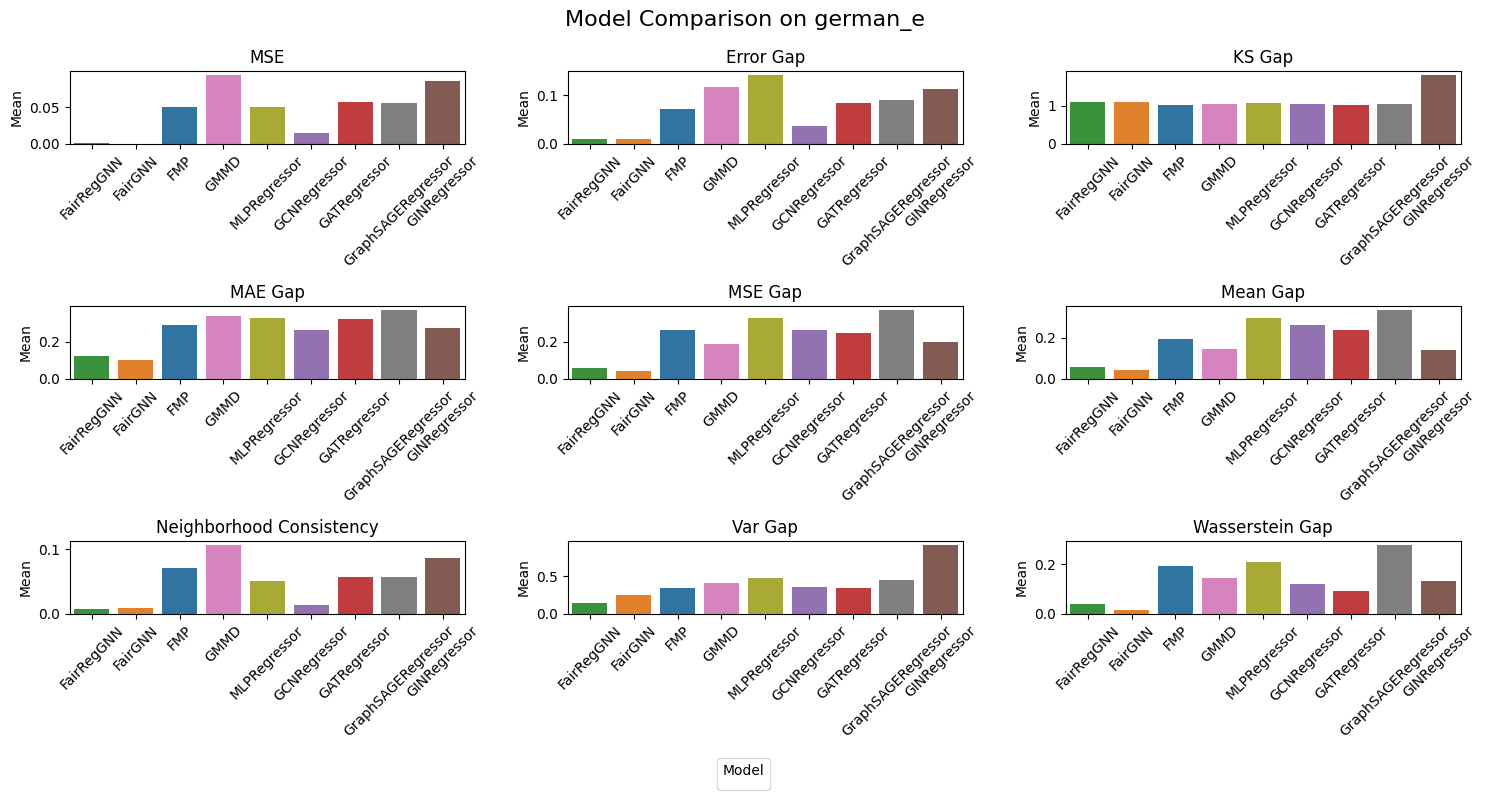

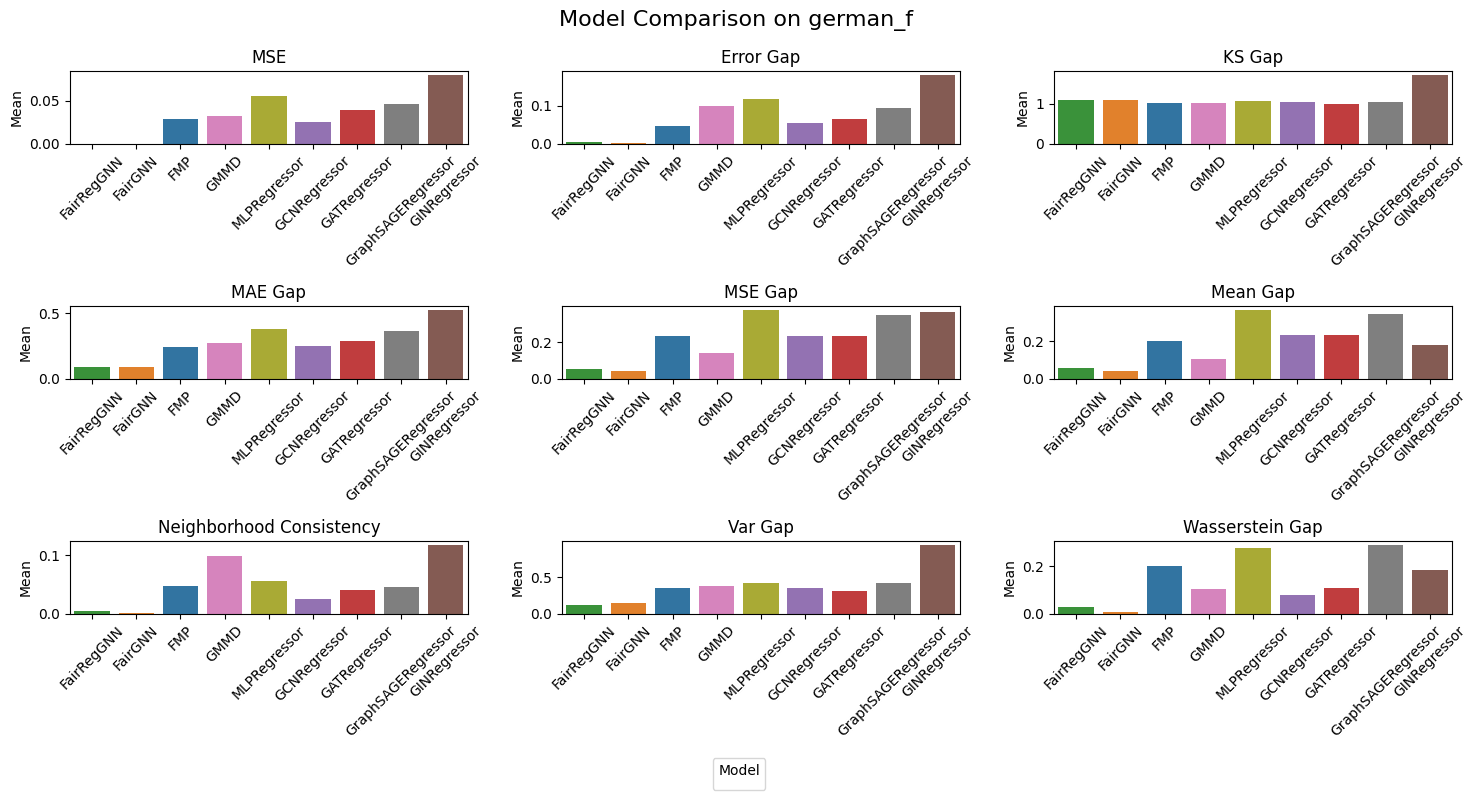

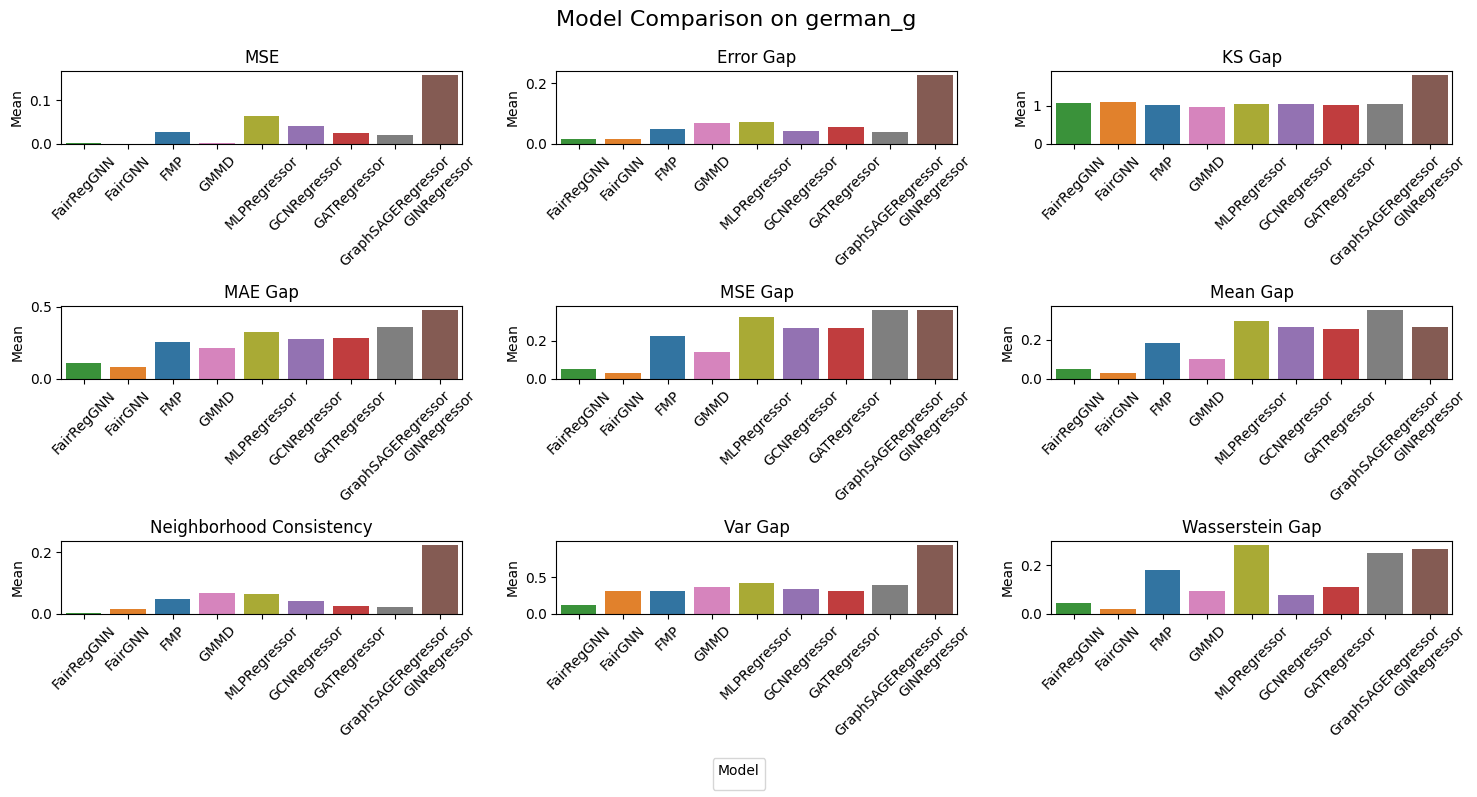

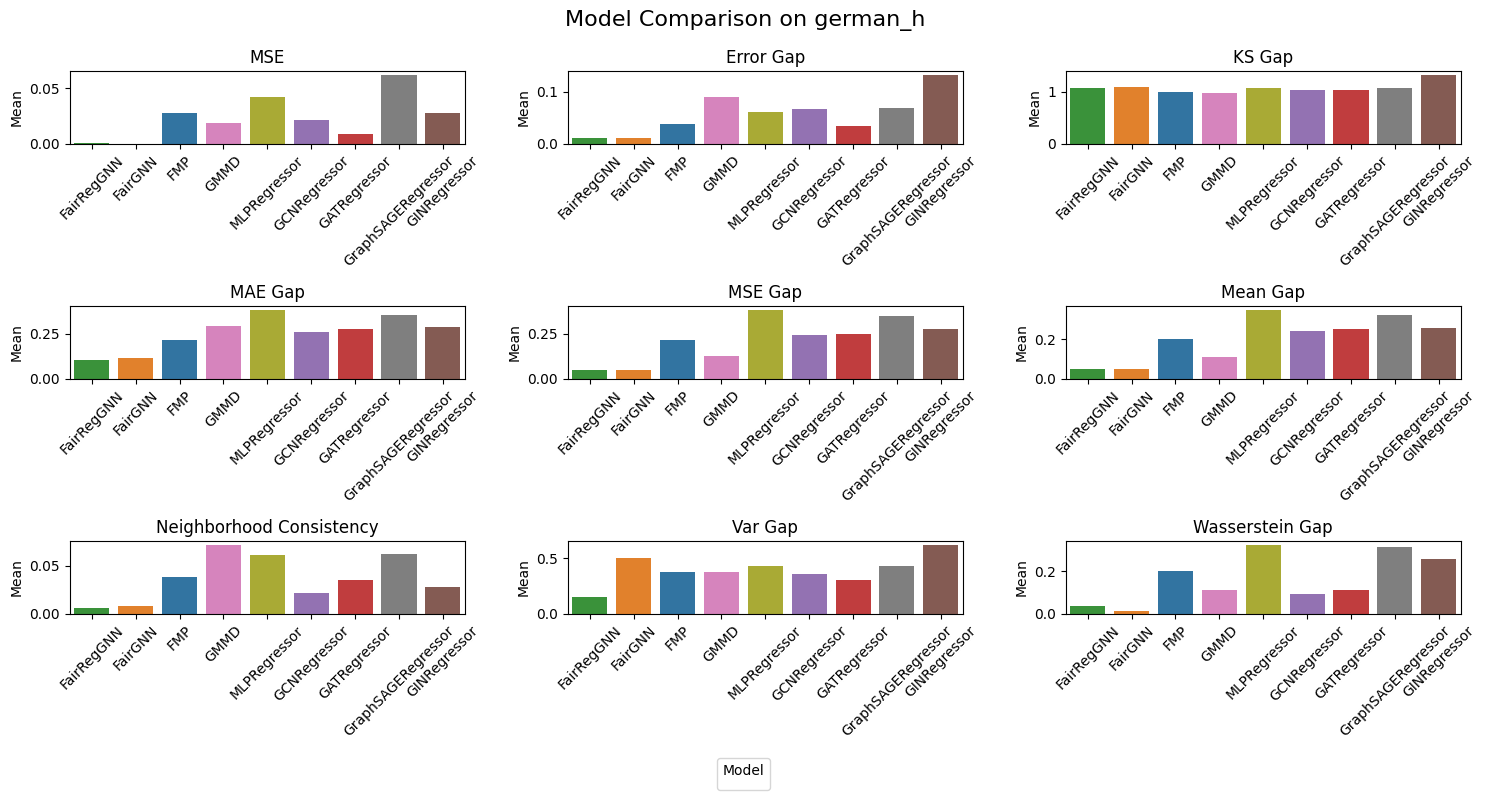

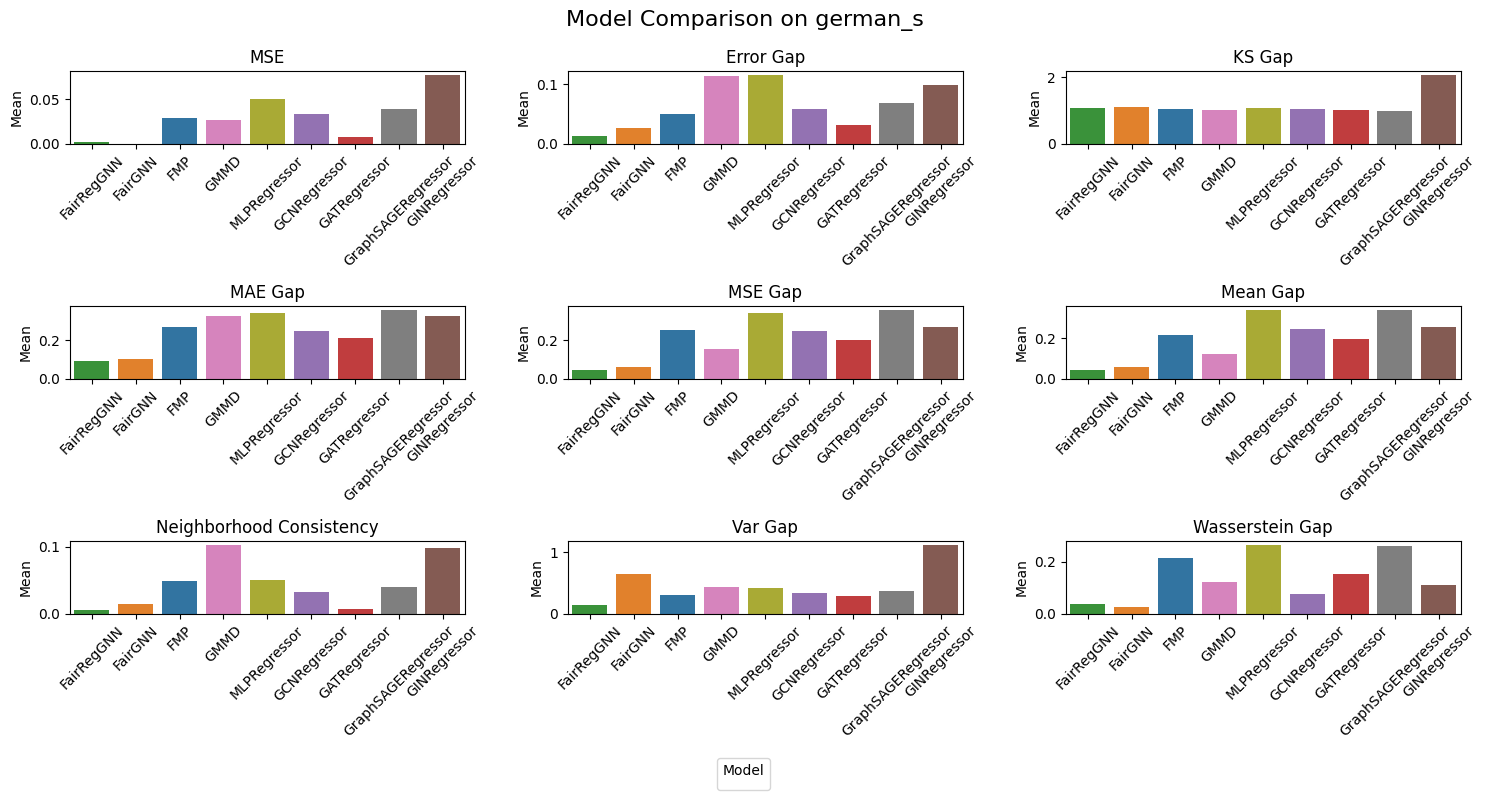

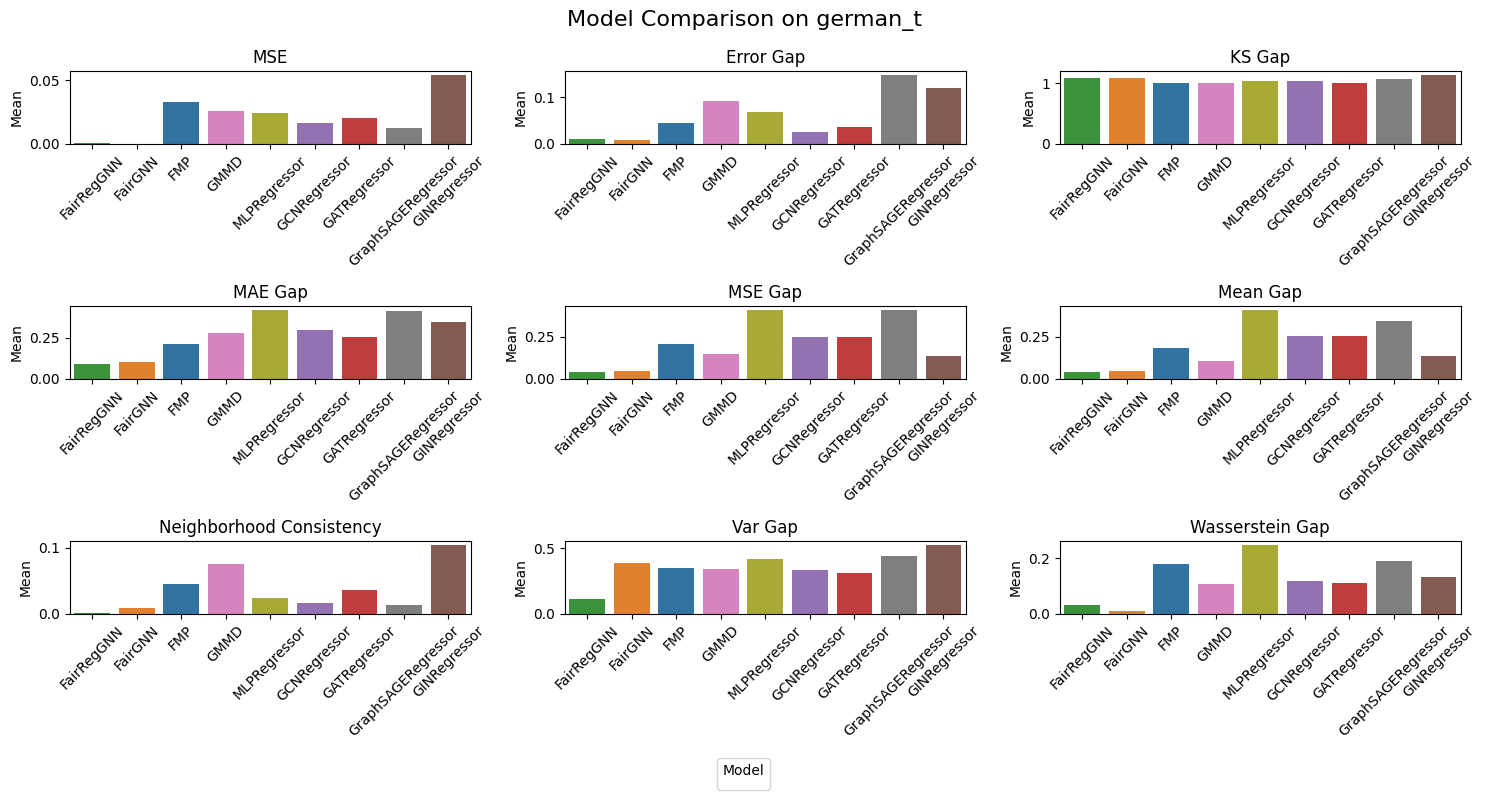

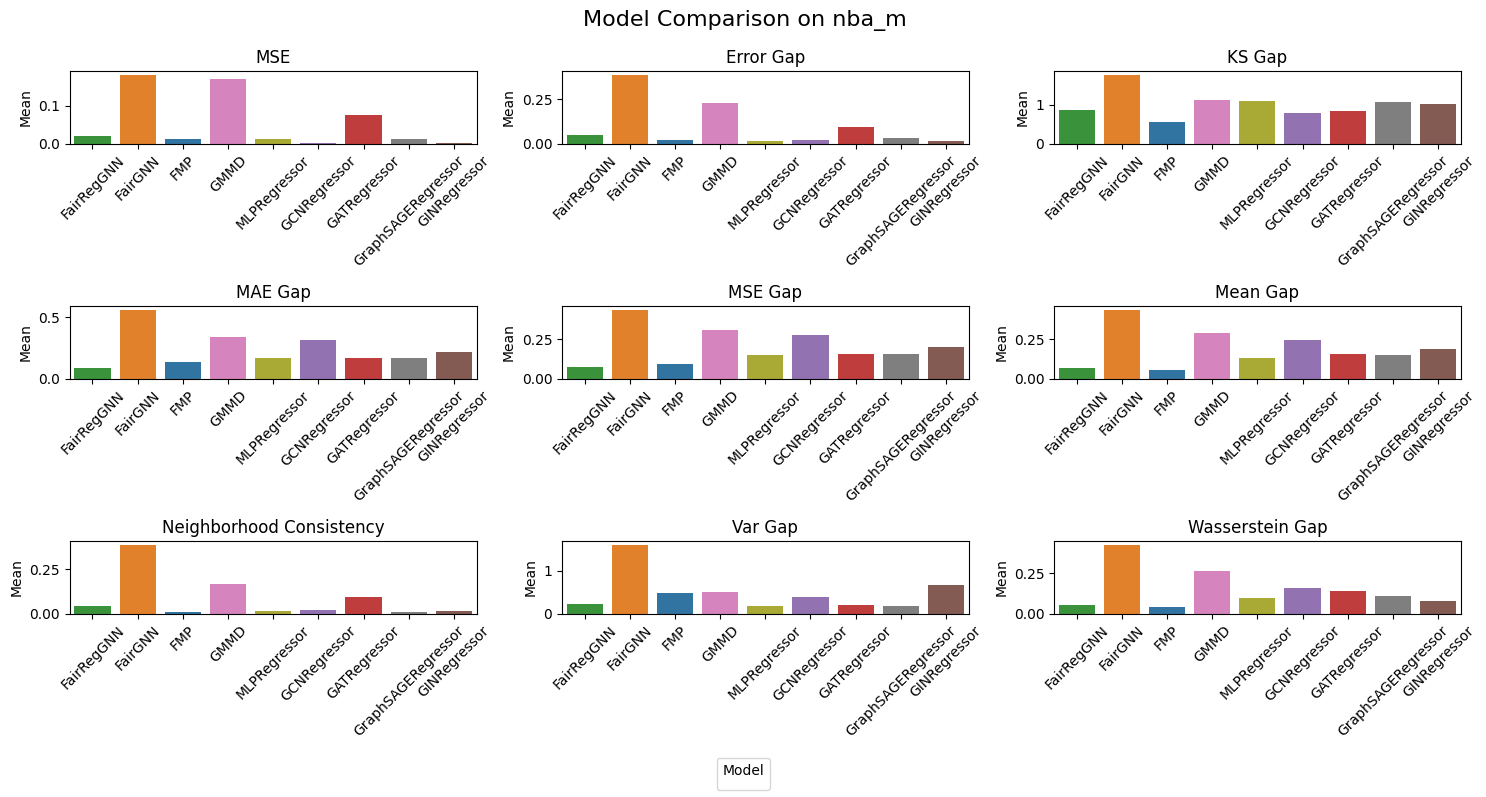

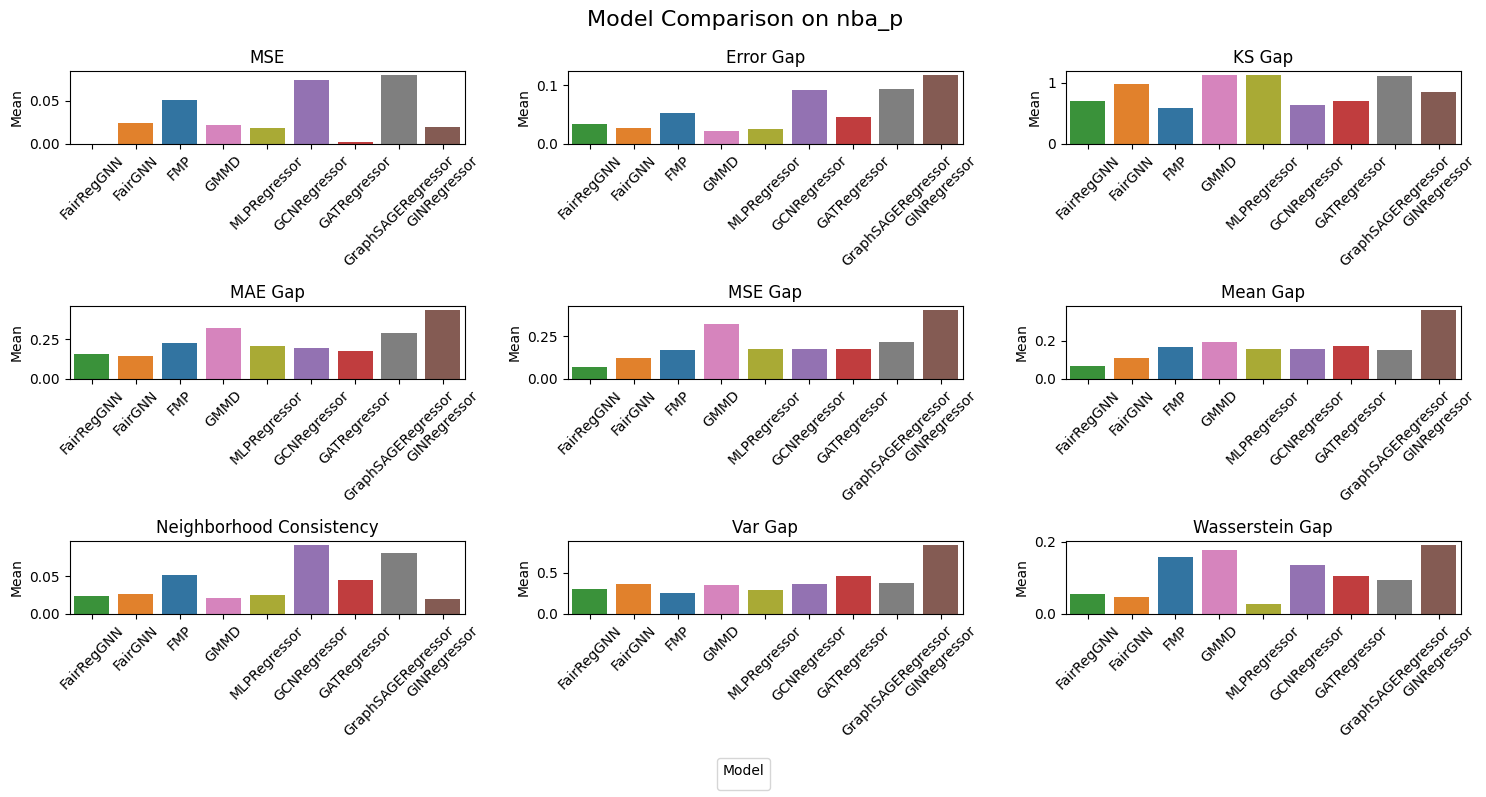

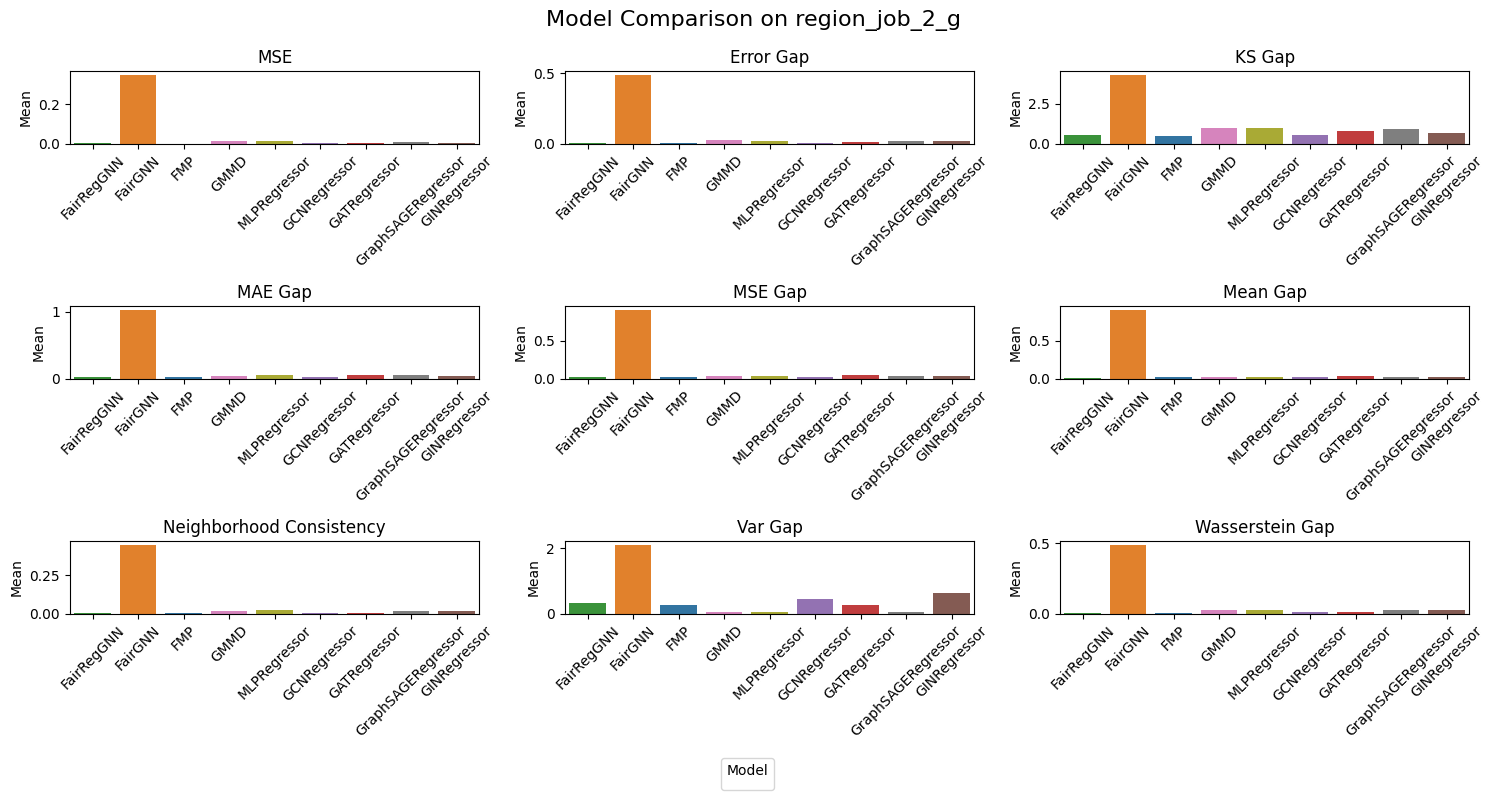

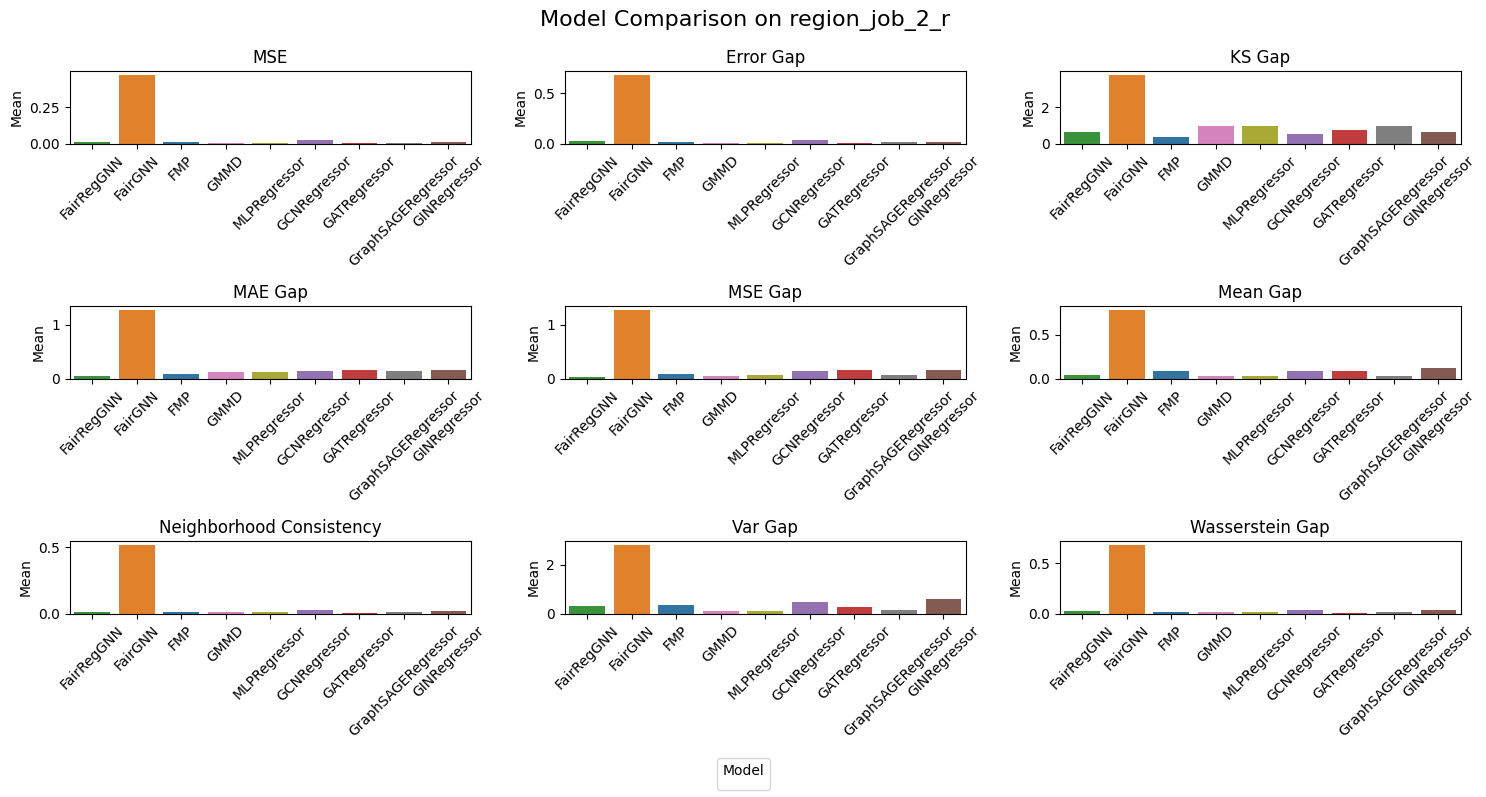

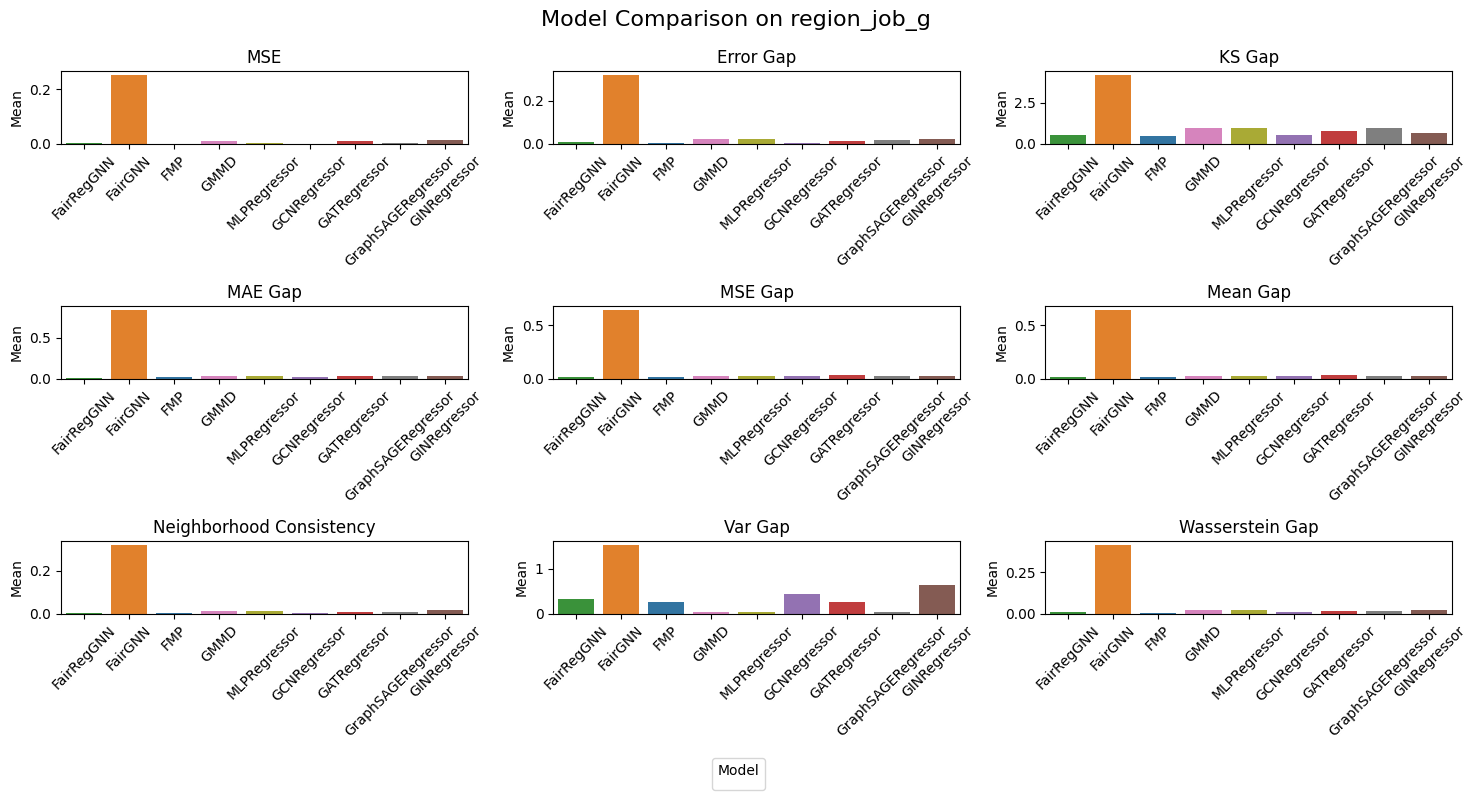

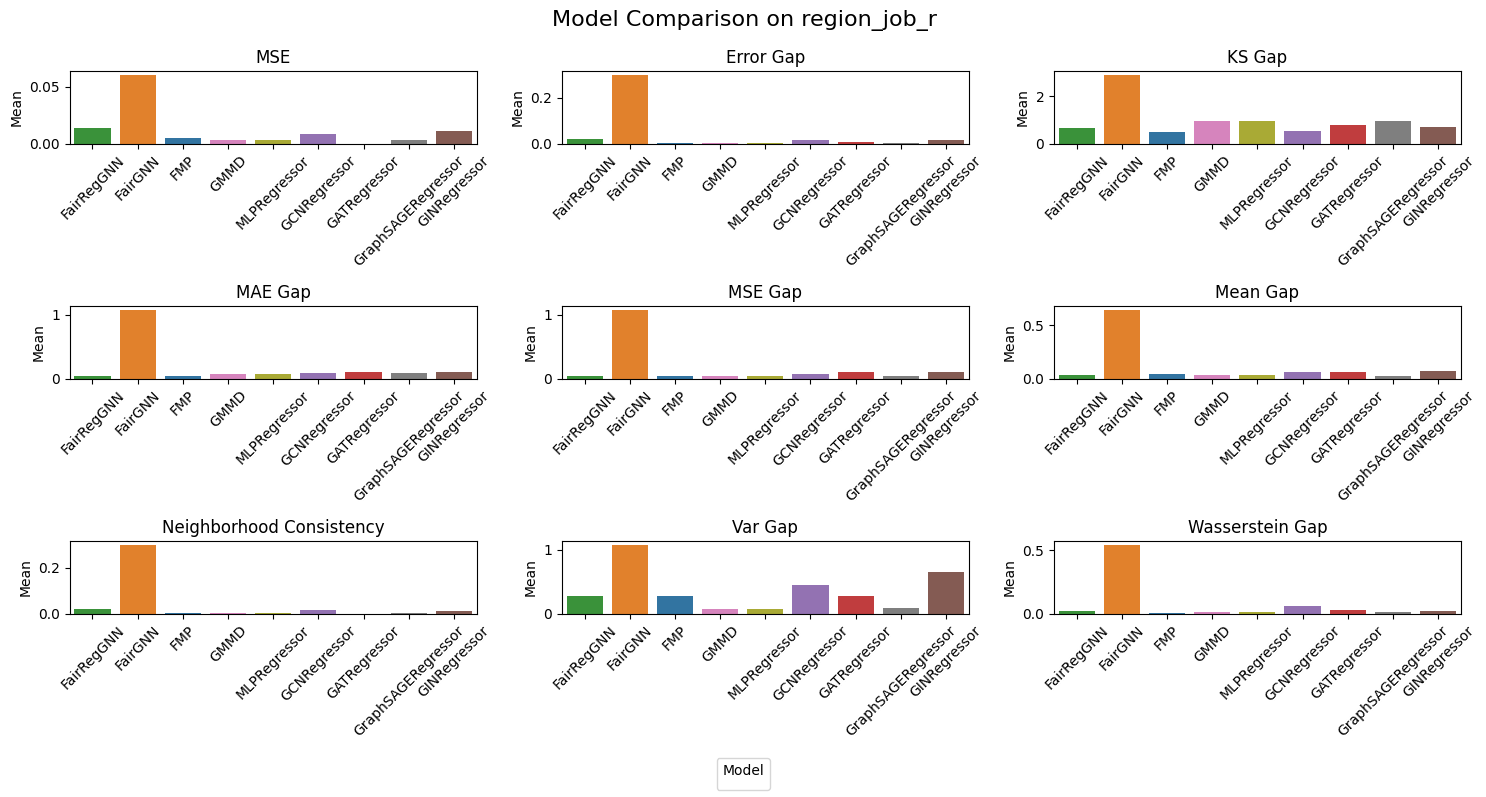

In [93]:
# Metric 목록
metrics = ['MSE', 'Error Gap', 'KS Gap', 'MAE Gap', 'MSE Gap',
           'Mean Gap', 'Neighborhood Consistency', 'Var Gap', 'Wasserstein Gap']

model_order = ['FairRegGNN', 'FairGNN', 'FMP', 'GMMD', 'MLPRegressor',
               'GCNRegressor', 'GATRegressor', 'GraphSAGERegressor', 'GINRegressor']

palette = 'tab10'
datasets = df['Dataset'].unique()

for dataset in datasets:
    fig, axes = plt.subplots(3, 3, figsize=(15, 8))
    axes = axes.flatten()

    for i, metric in enumerate(metrics):
        ax = axes[i]
        subset = df[(df['Dataset'] == dataset) & (df['Metric'] == metric)]

        sns.barplot(
            data=subset,
            x='Model',
            y='Mean',
            hue='Model',
            dodge=False,
            palette=palette,
            order=model_order,
            ax=ax
        )

        ax.set_title(metric, fontsize=12)
        ax.set_xlabel('')
        ax.set_ylabel('Mean')
        ax.tick_params(axis='x', rotation=45)

        # ❗ 안전하게 범례 제거
        if i != 0:
            legend = ax.get_legend()
            if legend is not None:
                legend.remove()

    # 첫 번째 축에서만 범례 추출
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=len(model_order), title='Model')

    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.suptitle(f'Model Comparison on {dataset}', fontsize=16)
    plt.show()


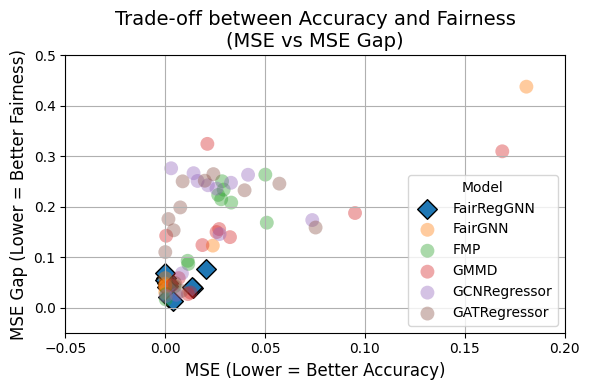

In [94]:
# 주요 설정
our_model = 'FairRegGNN'
accuracy_metric = 'MSE'
fairness_metric = 'MSE Gap'

model_order = ['FairRegGNN', 'FairGNN', 'FMP', 'GMMD',
            #    'MLPRegressor',
               'GCNRegressor', 'GATRegressor'
            #    , 'GraphSAGERegressor', 'GINRegressor'
               ]
palette = sns.color_palette('tab10', n_colors=len(model_order))
base_colors = dict(zip(model_order, palette))

# 색상 & 마커 스타일 지정
model_colors = {model: (base_colors[model] if model == our_model else tuple(list(base_colors[model]) + [0.4]))  # 투명도 조정
                for model in model_order}
model_markers = {model: ('D' if model == our_model else 'o') for model in model_order}

# 데이터 필터링
acc_df = df[df['Metric'] == accuracy_metric][['Model', 'Dataset', 'Mean']]
fair_df = df[df['Metric'] == fairness_metric][['Model', 'Dataset', 'Mean']]
merged_df = acc_df.merge(fair_df, on=['Model', 'Dataset'], suffixes=('_acc', '_fair'))

# 시각화
plt.figure(figsize=(6, 4))

for model in model_order:
    data = merged_df[merged_df['Model'] == model]
    plt.scatter(
        data['Mean_acc'], data['Mean_fair'],
        label=model,
        color=model_colors[model],
        marker=model_markers[model],
        s=100,
        edgecolor='black' if model == our_model else 'none'
    )

plt.xlabel(f'{accuracy_metric} (Lower = Better Accuracy)', fontsize=12)
plt.ylabel(f'{fairness_metric} (Lower = Better Fairness)', fontsize=12)
plt.xlim(-0.05, 0.2)
plt.ylim(-0.05, 0.5)
plt.title(f'Trade-off between Accuracy and Fairness\n({accuracy_metric} vs {fairness_metric})', fontsize=14)
plt.grid(True)
plt.legend(title='Model', loc='lower right')
plt.tight_layout()
plt.show()


## 모델 구현

### EDITS

In [13]:
def feature_norm(features):
    min_values = features.min(axis=0)[0]
    max_values = features.max(axis=0)[0]
    return 2*(features - min_values).div(max_values-min_values) - 1

def normalize_scipy(mx):
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -0.5).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx).dot(r_mat_inv)
    return mx

def binarize(A_debiased, adj_ori, threshold_proportion):
    the_con1 = (A_debiased - adj_ori).A
    the_con1 = np.where(the_con1 > np.max(the_con1) * threshold_proportion, 1 + the_con1 * 0, the_con1)
    the_con1 = np.where(the_con1 < np.min(the_con1) * threshold_proportion, -1 + the_con1 * 0, the_con1)
    the_con1 = np.where(np.abs(the_con1) == 1, the_con1, the_con1 * 0)
    A_debiased = adj_ori + sp.coo_matrix(the_con1)
    assert A_debiased.max() == 1
    assert A_debiased.min() == 0
    A_debiased = normalize_scipy(A_debiased)
    return A_debiased

def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

def fair_metric(pred, labels, sens):
    idx_s0 = sens==0
    idx_s1 = sens==1
    idx_s0_y1 = np.bitwise_and(idx_s0, labels==1)
    idx_s1_y1 = np.bitwise_and(idx_s1, labels==1)
    parity = abs(sum(pred[idx_s0])/sum(idx_s0)-sum(pred[idx_s1])/sum(idx_s1))
    equality = abs(sum(pred[idx_s0_y1])/sum(idx_s0_y1)-sum(pred[idx_s1_y1])/sum(idx_s1_y1))
    return parity.item(), equality.item()

def metric_wd(feature, adj_norm, flag, weakening_factor, max_hop):

    feature = (feature / feature.norm(dim=0)).detach().cpu().numpy()
    adj_norm = (0.5 * adj_norm + 0.5 * sparse.eye(adj_norm.shape[0])).toarray()  # lambda_{max} = 2
    emd_distances = []
    cumulation = np.zeros_like(feature)

    if max_hop == 0:
        cumulation = feature
    else:
        for i in range(max_hop):
            cumulation += pow(weakening_factor, i) * adj_norm.dot(feature)

    for i in range(feature.shape[1]):
        class_1 = cumulation[torch.eq(flag, 0), i]
        class_2 = cumulation[torch.eq(flag, 1), i]
        emd = wasserstein_distance(class_1, class_2)
        emd_distances.append(emd)

    emd_distances = [0 if math.isnan(x) else x for x in emd_distances]

    if max_hop == 0:
        print('Attribute bias : ')
    else:
        print('Structural bias : ')

    print("Sum of all Wasserstein distance value across feature dimensions: " + str(sum(emd_distances)))
    print("Average of all Wasserstein distance value across feature dimensions: " + str(np.mean(np.array(emd_distances))))

    sns.distplot(np.array(emd_distances).squeeze(), rug=True, hist=True, label='EMD value distribution')
    plt.legend()
    # plt.show()

    num_list1 = emd_distances
    x = range(len(num_list1))

    plt.bar(x, height=num_list1, width=0.4, alpha=0.8, label="Wasserstein distance on reachability")
    plt.ylabel("Wasserstein distance")
    plt.legend()
    # plt.show()
    return emd_distances

class GCN_edit(nn.Module):
    # 회귀로 수정정
    def __init__(self, nfeat, nhid, dropout):
        super(GCN, self).__init__()
        self.body = GCN_Body(nfeat,nhid,dropout)
        self.fc = nn.Linear(nhid, 1)

        for m in self.modules():
            self.weights_init(m)

    def weights_init(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight.data)
            if m.bias is not None:
                m.bias.data.fill_(0.0)

    def forward(self, x, edge_index):
        x = self.body(x, edge_index)
        # x = self.fc(x)
        # return x

        # 회귀로 수정
        out = self.regressor(x)  # activation 없음 (linear output)
        return out.squeeze()     # [N, 1] → [N]

# class GCN_Body(nn.Module):
#     def __init__(self, nfeat, nhid, dropout):
#         super(GCN_Body, self).__init__()
#         self.gc1 = GCNConv(nfeat, nhid)

#     def forward(self, x, edge_index):
#         x = self.gc1(x, edge_index)
#         return x    

class GCNBody_edit(nn.Module):
    def __init__(self, nfeat, nhid, dropout=0.5):
        super(GCNBody_edit, self).__init__()
        self.gc1 = GCNConv(nfeat, nhid)
        self.dropout = nn.Dropout(p=dropout)
        self.activation = nn.ReLU()

    def forward(self, x, edge_index):
        x = self.gc1(x, edge_index)
        x = self.activation(x)
        x = self.dropout(x)
        return x

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.parameter import Parameter
import copy
from deeprobust.graph.defense.pgd import PGD, prox_operators

class X_debaising(nn.Module):
    def __init__(self, in_features):
        super(X_debaising, self).__init__()
        self.in_features = in_features
        self.s = Parameter(torch.FloatTensor(in_features), requires_grad=True)
        self.reset_parameters()

    def reset_parameters(self):
        self.s.data.uniform_(1, 1)

    def forward(self, feature):
        return torch.mm(feature, torch.diag(self.s))


class EstimateAdj(nn.Module):
    def __init__(self, adj, symmetric=False, device='cpu'):
        super(EstimateAdj, self).__init__()
        n = len(adj)
        self.estimated_adj = nn.Parameter(torch.FloatTensor(n, n), requires_grad=True)
        self._init_estimation(adj)
        self.symmetric = symmetric
        self.device = device

    def _init_estimation(self, adj):
        with torch.no_grad():
            adj = adj.to_dense().to(torch.float32)
            self.estimated_adj.data.copy_(adj)

    def forward(self):
        return self.estimated_adj


class Adj_renew(nn.Module):
    def __init__(self, node_num, nfeat, nfeat_out, adj_lambda):
        super(Adj_renew, self).__init__()
        self.node_num = node_num
        self.nfeat = nfeat
        self.nfeat_out = nfeat_out
        self.adj_lambda = adj_lambda
        self.reset_parameters()

    def reset_parameters(self):
        pass

    def fit(self, adj, lr):
        estimator = EstimateAdj(adj, symmetric=False, device='cuda').to('cuda').float()
        self.estimator = estimator
        self.optimizer_adj = optim.SGD(estimator.parameters(), momentum=0.9, lr=lr)
        self.optimizer_l1 = PGD(estimator.parameters(), proxs=[prox_operators.prox_l1], lr=lr, alphas=[5e-4])
        self.optimizer_nuclear = PGD(estimator.parameters(), proxs=[prox_operators.prox_nuclear], lr=lr, alphas=[1.5])

    def the_norm(self):
        return self.estimator._normalize(self.estimator.estimated_adj)

    def forward(self):
        return self.estimator.estimated_adj

    def feature_smoothing(self, adj, X):
        adj = (adj.t() + adj) / 2
        rowsum = adj.sum(1)
        r_inv = rowsum.flatten()
        D = torch.diag(r_inv)
        L = D - adj

        r_inv = r_inv + 1e-3
        r_inv = r_inv.pow(-1/2).flatten()
        r_inv[torch.isinf(r_inv)] = 0.
        r_mat_inv = torch.diag(r_inv)
        L = r_mat_inv @ L @ r_mat_inv

        XLXT = torch.matmul(torch.matmul(X.t(), L), X)
        return torch.trace(XLXT)

    def train_adj(self, features, adj, adv_loss, epoch, lr):
        for param_group in self.optimizer_adj.param_groups:
            param_group["lr"] = lr

        estimator = self.estimator
        estimator.train()
        self.optimizer_adj.zero_grad()

        delta = estimator.estimated_adj - adj
        loss_fro = torch.sum(delta.mul(delta))
        loss_diffiential = 1 * loss_fro + 15 * adv_loss
        loss_diffiential.backward()
        self.optimizer_adj.step()

        self.optimizer_l1.zero_grad()
        self.optimizer_l1.step()

        with torch.no_grad():
            estimator.estimated_adj.data.clamp_(0, 1)
            estimator.estimated_adj.data.copy_(
                (estimator.estimated_adj.data + estimator.estimated_adj.data.transpose(0, 1)) / 2
            )

        return estimator.estimated_adj


class EDITS(nn.Module):
    def __init__(self, nfeat, node_num, nclass, nfeat_out, adj_lambda, lr, weight_decay, layer_threshold=2, dropout=0.1):
        super(EDITS, self).__init__()
        self.x_debaising = X_debaising(nfeat)
        self.layer_threshold = layer_threshold
        self.adj_renew = Adj_renew(node_num, nfeat, nfeat_out, adj_lambda)
        self.fc = nn.Linear(nfeat * (layer_threshold + 1), 1)
        self.lr = lr

        self.optimizer_feature_l1 = PGD(self.x_debaising.parameters(), proxs=[prox_operators.prox_l1], lr=self.lr, alphas=[5e-6])
        G_params = list(self.x_debaising.parameters())
        self.optimizer_G = optim.RMSprop(G_params, lr=self.lr, eps=1e-04, weight_decay=weight_decay)
        self.optimizer_A = optim.RMSprop(self.fc.parameters(), lr=self.lr, eps=1e-04, weight_decay=weight_decay)
        self.dropout = nn.Dropout(dropout)

    def propagation_cat_new_filter(self, X_de, A_norm, layer_threshold):
        A_norm = A_norm.float()
        X_de = X_de.float()
        X_agg = X_de
        for _ in range(layer_threshold):
            X_de = A_norm.mm(X_de)
            X_agg = torch.cat((X_agg, X_de), dim=1)
        return X_agg

    def forward(self, A, X):
        X = X.float()
        A = A.float()
        X_de = self.x_debaising(X)
        adj_new = self.adj_renew()
        agg_con = self.propagation_cat_new_filter(X_de, adj_new, self.layer_threshold)
        D_pre = self.fc(agg_con)
        D_pre = self.dropout(D_pre)
        return adj_new, X_de, D_pre, D_pre, agg_con

    def optimize(self, adj, features, idx_train, sens, epoch, lr):
        self.lr = lr
        for param_group in self.optimizer_G.param_groups:
            param_group["lr"] = lr
        for param_group in self.optimizer_A.param_groups:
            param_group["lr"] = lr

        self.train()
        self.optimizer_G.zero_grad()
        self.fc.requires_grad_(False)

        if epoch == 0:
            self.adj_renew.fit(adj, self.lr)

        _, X_debiased, predictor_sens, _, _ = self.forward(adj, features)
        pos = torch.masked_select(predictor_sens[idx_train].squeeze(), sens[idx_train] > 0)
        neg = torch.masked_select(predictor_sens[idx_train].squeeze(), sens[idx_train] <= 0)
        adv_loss = - (torch.mean(pos) - torch.mean(neg))
        loss_train = 3e-2 * (X_debiased - features).norm(2) + adv_loss
        loss_train.backward()
        self.optimizer_G.step()
        self.optimizer_feature_l1.zero_grad()
        self.optimizer_feature_l1.step()

        _, X_debiased, predictor_sens, _, _ = self.forward(adj, features)
        pos = torch.masked_select(predictor_sens[idx_train].squeeze(), sens[idx_train] > 0)
        neg = torch.masked_select(predictor_sens[idx_train].squeeze(), sens[idx_train] <= 0)
        adv_loss = - (torch.mean(pos) - torch.mean(neg))
        self.adj_renew.train_adj(X_debiased, adj, adv_loss, epoch, lr)

        with torch.no_grad():
            param = self.state_dict()
            param["x_debaising.s"] = torch.clamp(param["x_debaising.s"], 0, 1)
            self.load_state_dict(param)

        for _ in range(8):
            self.fc.requires_grad_(True)
            self.optimizer_A.zero_grad()
            _, _, predictor_sens, _, _ = self.forward(adj, features)
            pos = torch.masked_select(predictor_sens[idx_train].squeeze(), sens[idx_train] > 0)
            neg = torch.masked_select(predictor_sens[idx_train].squeeze(), sens[idx_train] <= 0)
            loss_train = torch.abs(torch.mean(pos) - torch.mean(neg))
            loss_train.backward()
            self.optimizer_A.step()
            for p in self.fc.parameters():
                p.data.clamp_(-0.02, 0.02)

        return 0


In [145]:
results = {}

for ds in datasets:
    data = all_data[ds]['data']
    cfg = all_data[ds]['cfg']
    data = data.to(device)
    dn = cfg['dn']
    os.makedirs('./model/edits', exist_ok=True)
    model_path = f'./model/edits/{dn}_md.pth'

    print(f"[EDITS] Train Model on dataset: {ds}")

    performances = []
    for run in range(runs):
        model = EDITS(
            nfeat=data.x.size(1),
            node_num=data.x.size(0),
            nfeat_out=int(data.x.size(0) / 10),
            adj_lambda=1e-1,
            nclass=1,
            lr=0.003,
            weight_decay=1e-7,
            layer_threshold=2,
            dropout=0.2
        ).to(device)

        features = data.x.to(device).to(torch.float32)
        labels = data.y.to(device).to(torch.float32)
        sens = data.sensitive_attr.to(device).to(torch.float32)

        # adj 처리
        adj = data.adj
        if isinstance(adj, torch.Tensor):
            adj = adj.to(device).to(torch.float32)
        else:
            adj = torch.FloatTensor(adj.toarray()).to(device).to(torch.float32)

        print("adj shape:", adj.shape)
        print("adj dtype:", adj.dtype)

        idx_train = data.idx_train
        idx_val = data.idx_val
        idx_test = data.idx_test

        best_mse = float('inf')
        best_model_state = None

        for epoch in range(epochs):
            lr = 0.001 if epoch > 400 else 0.003
            model.train()
            model.optimize(adj, features, idx_train, sens, epoch, lr)

            model.eval()
            with torch.no_grad():
                _, _, output, _, _ = model(adj, features)
                preds = output.squeeze()

                mse_val = mean_squared_error(labels[idx_val].cpu(), preds[idx_val].cpu())
                mae_val = mean_absolute_error(labels[idx_val].cpu(), preds[idx_val].cpu())
                mse_g0, mse_g1, mse_diff, mae_g0, mae_g1, mae_diff, mean_g0, mean_g1, mean_diff = fair_metric_regression(
                    preds[idx_val].cpu(), labels[idx_val].cpu(), sens[idx_val].cpu())
                dist_val = compare_groupwise_distribution(
                    labels[idx_val].cpu().numpy().squeeze(),
                    preds[idx_val].cpu().numpy().squeeze(),
                    sens[idx_val].cpu().numpy())

                if mse_val < best_mse:
                    best_mse = mse_val
                    best_model_state = copy.deepcopy(model.state_dict())
                    torch.save(best_model_state, model_path)

                if epoch % 50 == 0:
                    print(f"[EDITS] Run {run+1}, Epoch {epoch} | "
                          f"Val MSE: {mse_val:.4f}, MAE: {mae_val:.4f}, \n"
                          f"MSE Diff: {mse_diff:.4f}, MAE Diff: {mae_diff:.4f}, MEAN Diff: {mean_diff:.4f}, "
                          f"Wasserstein Diff: {dist_val['wasserstein_diff']:.4f}, JS Diff: {dist_val['js_diff']:.4f}")

        # Test
        model.load_state_dict(best_model_state)
        model.eval()
        with torch.no_grad():
            _, _, output, _, _ = model(adj, features)
            preds = output.squeeze()
            mse_test = mean_squared_error(labels[idx_test].cpu(), preds[idx_test].cpu())
            mae_test = mean_absolute_error(labels[idx_test].cpu(), preds[idx_test].cpu())
            mse_g0, mse_g1, mse_diff, mae_g0, mae_g1, mae_diff, mean_g0, mean_g1, mean_diff = fair_metric_regression(
                preds[idx_test].cpu(), labels[idx_test].cpu(), sens[idx_test].cpu())
            dist_test = compare_groupwise_distribution(
                labels[idx_test].cpu().numpy().squeeze(),
                preds[idx_test].cpu().numpy().squeeze(),
                sens[idx_test].cpu().numpy())

        performances.append([
            mse_test, mae_test,
            mse_g0, mse_g1, mse_diff,
            mae_g0, mae_g1, mae_diff,
            mean_g0, mean_g1, mean_diff,
            dist_test
        ])

    results[ds] = performances

[EDITS] Train Model on dataset: german_e
adj shape: torch.Size([1000, 1000])
adj dtype: torch.float32
[EDITS] Run 1, Epoch 0 | Val MSE: 0.9877, MAE: 0.9044, 
MSE Diff: 0.1306, MAE Diff: 0.0000, MEAN Diff: 0.0984, Wasserstein Diff: 0.0137, JS Diff: 0.0367
[EDITS] Run 1, Epoch 50 | Val MSE: 0.9563, MAE: 0.8894, 
MSE Diff: 0.1074, MAE Diff: 0.0000, MEAN Diff: 0.0394, Wasserstein Diff: 0.0399, JS Diff: 0.0281
[EDITS] Run 1, Epoch 100 | Val MSE: 0.9683, MAE: 0.9082, 
MSE Diff: 0.0893, MAE Diff: 0.0000, MEAN Diff: 0.0375, Wasserstein Diff: 0.0308, JS Diff: 0.0281
[EDITS] Run 1, Epoch 150 | Val MSE: 0.9436, MAE: 0.8861, 
MSE Diff: 0.1251, MAE Diff: 0.0000, MEAN Diff: 0.0645, Wasserstein Diff: 0.0299, JS Diff: 0.0281
[EDITS] Run 1, Epoch 200 | Val MSE: 0.9749, MAE: 0.9099, 
MSE Diff: 0.0866, MAE Diff: 0.0000, MEAN Diff: 0.0486, Wasserstein Diff: 0.0269, JS Diff: 0.0281
[EDITS] Run 1, Epoch 250 | Val MSE: 0.9883, MAE: 0.9047, 
MSE Diff: 0.1446, MAE Diff: 0.0000, MEAN Diff: 0.0432, Wasserstein D

OutOfMemoryError: CUDA out of memory. Tried to allocate 16.51 GiB. GPU 0 has a total capacity of 11.99 GiB of which 0 bytes is free. Of the allocated memory 16.92 GiB is allocated by PyTorch, and 426.46 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

### GMMD

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import MSELoss

def compute_mmd(x0, x1, alpha=1.0, sample_size=256):
    def rbf_kernel(x, y, alpha):
        dist = ((x.unsqueeze(1) - y.unsqueeze(0)) ** 2).sum(2)
        return torch.exp(-alpha * dist)

    # 샘플링 (메모리 절약)
    if x0.size(0) > sample_size:
        idx = torch.randperm(x0.size(0), device=x0.device)[:sample_size]
        x0 = x0[idx]
    if x1.size(0) > sample_size:
        idx = torch.randperm(x1.size(0), device=x1.device)[:sample_size]
        x1 = x1[idx]

    Kxx = rbf_kernel(x0, x0, alpha)
    Kyy = rbf_kernel(x1, x1, alpha)
    Kxy = rbf_kernel(x0, x1, alpha)
    return Kxx.mean() + Kyy.mean() - 2 * Kxy.mean()


class GMMDLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GMMDLayer, self).__init__()
        self.linear = nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index, sens):
        x = self.linear(x)

        group_0 = x[sens == 0]
        group_1 = x[sens == 1]

        if group_0.size(0) > 1 and group_1.size(0) > 1:
            mmd = compute_mmd(group_0, group_1)
        else:
            mmd = torch.tensor(0.0, device=x.device)

        return x, mmd

class GMMDNet(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GMMDNet, self).__init__()
        self.gmmd1 = GMMDLayer(in_channels, hidden_channels)
        self.gmmd2 = GMMDLayer(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index, sens = data.x, data.edge_index, data.sensitive_attr
        x, mmd1 = self.gmmd1(x, edge_index, sens)
        x = F.relu(x)
        x, mmd2 = self.gmmd2(x, edge_index, sens)
        return x.squeeze(), mmd1 + mmd2


In [49]:
results = {}

for ds in datasets:
    data = all_data[ds]['data']
    cfg = all_data[ds]['cfg']
    data = data.to(device)
    dn = cfg['dn']
    os.makedirs('./model/gmmd', exist_ok=True)
    model_path = f'./model/gmmd/{dn}_md.pth'

    print(f'Train GMMD Model on dataset {ds}')
    performances = []

    for run in range(runs):
        model = GMMDNet(in_channels=data.num_features,
                        hidden_channels=64,
                        out_channels=1).to(device)
        optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        criterion = MSELoss()

        best_mse = float('inf')
        best_model_state = None

        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()
            pred, mmd_loss = model(data)
            pred = pred.squeeze()
            loss = criterion(pred[data.idx_train], data.y[data.idx_train].squeeze()) + mmd_loss
            loss.backward()
            optimizer.step()

            # Validation
            model.eval()
            with torch.no_grad():
                pred, _ = model(data)
                y_true, idx_val, sensitive_attr = data.y, data.idx_val, data.sensitive_attr

                mse_val = mean_squared_error(y_true[idx_val].cpu(), pred[idx_val].cpu())
                mae_val = mean_absolute_error(y_true[idx_val].cpu(), pred[idx_val].cpu())
                fair_metrics = fair_metric_regression(pred[idx_val].cpu(), y_true[idx_val].cpu(), sensitive_attr[idx_val].cpu())
                dist_val = compare_groupwise_distribution(
                    y_true[idx_val].cpu().numpy().squeeze(),
                    pred[idx_val].cpu().numpy().squeeze(),
                    sensitive_attr[idx_val].cpu().numpy()
                )

                if mse_val < best_mse:
                    best_mse = mse_val
                    best_model_state = copy.deepcopy(model.state_dict())
                    torch.save(best_model_state, model_path)

                if epoch % 50 == 0:
                    print(f"[GMMD] Run {run+1}, Epoch {epoch} | Val MSE: {mse_val:.4f}, MAE: {mae_val:.4f}")

        # Test
        model.load_state_dict(best_model_state)
        model.eval()
        with torch.no_grad():
            pred, _ = model(data)
            y_true, idx_test, sensitive_attr = data.y, data.idx_test, data.sensitive_attr
            mse_test = mean_squared_error(y_true[idx_test].cpu(), pred[idx_test].cpu())
            mae_test = mean_absolute_error(y_true[idx_test].cpu(), pred[idx_test].cpu())
            fair_metrics = fair_metric_regression(pred[idx_test].cpu(), y_true[idx_test].cpu(), sensitive_attr[idx_test].cpu())
            dist_test = compare_groupwise_distribution(
                y_true[idx_test].cpu().numpy().squeeze(),
                pred[idx_test].cpu().numpy().squeeze(),
                sensitive_attr[idx_test].cpu().numpy()
            )

        performances.append([
            mse_test, mae_test,
            *fair_metrics,
            dist_test
        ])

    results[ds] = performances


Train GMMD Model on dataset region_job_r
[GMMD] Run 1, Epoch 0 | Val MSE: 0.4650, MAE: 0.5783
[GMMD] Run 1, Epoch 50 | Val MSE: 0.0380, MAE: 0.1354
[GMMD] Run 1, Epoch 100 | Val MSE: 0.0333, MAE: 0.1243
[GMMD] Run 1, Epoch 150 | Val MSE: 0.0320, MAE: 0.1201
[GMMD] Run 1, Epoch 200 | Val MSE: 0.0316, MAE: 0.1215
[GMMD] Run 1, Epoch 250 | Val MSE: 0.0316, MAE: 0.1195
[GMMD] Run 1, Epoch 300 | Val MSE: 0.0317, MAE: 0.1211
[GMMD] Run 1, Epoch 350 | Val MSE: 0.0318, MAE: 0.1216
[GMMD] Run 1, Epoch 400 | Val MSE: 0.0325, MAE: 0.1234
[GMMD] Run 1, Epoch 450 | Val MSE: 0.0330, MAE: 0.1238
Train GMMD Model on dataset region_job_g
[GMMD] Run 1, Epoch 0 | Val MSE: 0.4723, MAE: 0.5639
[GMMD] Run 1, Epoch 50 | Val MSE: 0.0407, MAE: 0.1359
[GMMD] Run 1, Epoch 100 | Val MSE: 0.0354, MAE: 0.1268
[GMMD] Run 1, Epoch 150 | Val MSE: 0.0340, MAE: 0.1230
[GMMD] Run 1, Epoch 200 | Val MSE: 0.0340, MAE: 0.1241
[GMMD] Run 1, Epoch 250 | Val MSE: 0.0341, MAE: 0.1212
[GMMD] Run 1, Epoch 300 | Val MSE: 0.0352, M

###  FairGNN

In [9]:
# FairGNN
# GNN 백본: 기본 GNN을 사용하여 노드 임베딩을 생성
# 민감 속성 추정기: 노드 임베딩에서 민감한 속성을 예측하는 모듈. 이는 민감한 속성 정보가 제한적인 경우에도 공정성을 보장하기 위해 사용
# 적대적 학습: 민감 속성 추정기를 속이는 방향으로 GNN을 학습시켜, 임베딩에서 민감한 속성 정보를 제거
# 손실함수: 노드 분류 손실 + 적대적 손실 + 민감 속성 추정기의 예측 분산 줄이는 정규화 항

# 장점
# 민감 속성 정보가 부족한 상황에서도 효과적
# 적대적 학습으로 임베딩 수준에서 공정성을 보장

# 한계
# 적대적 학습은 훈련이 불안정할 수 있음
# 주로 그룹 공정성에 초점 맞춰, 개별 공정성은 제한적
# 그래프 구조 자체의 편향을 직접적으로 해결하지 않음

In [10]:
class FairGNN(nn.Module):
    def __init__(self, nfeat,
                 hidden_dim=64, model='GCN', dropout=0.5, hidden=128, lr=0.001, weight_decay=1e-5, alpha=4, beta=0.01):
        super(FairGNN,self).__init__()

        nfeat = nfeat
        nhid = hidden_dim
        dropout = dropout
        
        # 추가
        self.alpha = alpha
        self.beta = beta
        
        self.estimator = GCN(nfeat, hidden, 1, dropout) # 민감 속성 추정기
        self.GNN = get_model(model, nfeat) 
        self.classifier = nn.Linear(nhid, 1) # 회귀 출력
        self.adv = nn.Linear(nhid, 1)  # 적대적 민감 속성 예측기

        G_params = list(self.GNN.parameters()) + list(self.classifier.parameters()) + list(self.estimator.parameters())
        self.optimizer_G = torch.optim.Adam(G_params, lr=lr, weight_decay=weight_decay)
        self.optimizer_A = torch.optim.Adam(self.adv.parameters(), lr=lr, weight_decay=weight_decay)

        # self.args = args
        # self.criterion = nn.BCEWithLogitsLoss()
        # 회귀 손실 함수
        self.criterion = nn.MSELoss() 
        self.G_loss = 0
        self.A_loss = 0

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        s = self.estimator(x, edge_index) # 민감 속성 추정
        z = self.GNN(x, edge_index) # 노드 임베딩
        y = self.classifier(z) # 회귀 예측
        return y, s
    
    def optimize(self, data):
        x, edge_index = data.x, data.edge_index
        labels = data.y
        idx_train = data.idx_train
        sens = data.sensitive_attr
        idx_sens_train = data.idx_sens_train
           
        self.train()

        ### update E, G
        self.adv.requires_grad_(False)
        self.optimizer_G.zero_grad()

        s = self.estimator(x, edge_index)
        h = self.GNN(x, edge_index)
        y = self.classifier(h)
        s_g = self.adv(h)

        # s_score = torch.sigmoid(s.detach())
        # s_score = (s_score > 0.5).float()
        s_score = s.detach() # 회귀용
        s_score[idx_sens_train]=sens[idx_sens_train].unsqueeze(1).float()
        # y_score = torch.sigmoid(y)
        y_score = y # 연속값 사용
        
        self.cov =  torch.abs(torch.mean((s_score - torch.mean(s_score)) * 
                                         (y_score - torch.mean(y_score))))

        self.cls_loss = self.criterion(y[idx_train], labels[idx_train].unsqueeze(1).float())
        self.adv_loss = self.criterion(s_g, s_score)                
        
        self.G_loss = self.cls_loss  + self.alpha * self.cov - self.beta * self.adv_loss
        self.G_loss.backward()
        self.optimizer_G.step()

        ## update Adv
        self.adv.requires_grad_(True)
        self.optimizer_A.zero_grad()
        s_g = self.adv(h.detach())
        
        self.A_loss = self.criterion(s_g, s_score)
        self.A_loss.backward()
        self.optimizer_A.step()


### FMP

In [11]:
# FMP
# GNN의 이웃 집계가 편향을 증폭시킬 수 있다는 점을 해결하려는 접근법
# 목표: 메세지 패싱 과정에서 민감한 속성의 영향을 최소화하여 공정성을 보장하고, 동시에 분류 정확도를 유지

# 이웃 집계: 표준 GNN처럼 이웃 노드의 정보를 집계하여 노드 임베딩을 생성
# 편향 완화 단계: 민감한 속성에 따른 노드 표현의 차이를 줄이기 위해, 그룹별 노드 표현 중심을 명시적으로 가깝게 만듦
# 통합 최적화 프레임워크: 분류 손실 + 그룹별 표현 중심의 공정성 손실

# GNN 아키텍처 자체를 수정하여 공정성을 보장
# 데이터 전처리 없이 메세지 패싱 과정에서 편향을 완화

# 장점
# 메세지 패싱 과정에서 직접 편향을 완화하므로 그래프 구조의 영향을 고려
# 데이터 전처리 없이 모델 아키텍처로 공정성을 보장

# 한계
# 주로 그룹 공정성에 초점, 개별 공정성 미흡
# 고차 이웃의 복잡한 상호작용을 완전히 해결하지 못할 수 있음
# 계산 비용이 증가할 가능성


In [12]:
class FMP(torch.nn.Module):
    _cached_sen = Optional[SparseTensor]
    def __init__(self, in_feats, out_feats, K, lambda1, lambda2, dropout=0.0, cached=False, L2=True):
        super(FMP, self).__init__()
        self.K = K
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        self.L2 = L2
        self.dropout = dropout
        self.cached = cached
        self._cached_sen = None  ## sensitive matrix

        # self.propa = GraphConv(in_feats, in_feats, weight=False, bias=False, activation=None)
        self.propa = GCNConv(out_feats, out_feats, add_self_loops=False, normalize=True)  # 그래프 컨볼루션 레이어: self-loop 미포함, 메세지 전파시 degree로 normalization

    def reset_parameters(self):
        self._cached_sen = None

    def forward(self, x: Tensor, 
                edge_index, 
                idx_sens_train,
                edge_weight: OptTensor = None, 
                sens=None) -> Tensor:

        if self.K <= 0: 
            return x

        cache = self._cached_sen
        if cache is None:
            sen_mat = get_sen(sens, idx_sens_train)               ## compute sensitive matrix
            if self.cached:
                self._cached_sen = sen_mat
                self.init_z = torch.zeros((sen_mat.size()[0], x.size()[-1])).cuda()
        else:
            sen_mat = self._cached_sen # N,

        hh = x
        x = self.emp_forward(x, edge_index, hh, K=self.K, sen=sen_mat)
        
        return x

    def emp_forward(self, x, edge_index, hh, K, sen):
        lambda1 = self.lambda1
        lambda2 = self.lambda2

        gamma = 1/(1+lambda2)
        beta = 1/(2*gamma)

        for _ in range(K):
            if lambda2 > 0:
                y = gamma * hh + (1-gamma) * self.propa(x, edge_index)
            else:
                y = gamma * hh + (1-gamma) * x

            if lambda1 > 0:
                # z = sen @ F.softmax(y, dim=1) / (gamma * sen @ sen.t())
                y_soft = F.softmax(y, dim=1)  # (N, F)
                # Group-wise 평균 표현 벡터
                z = sen.T @ y_soft / gamma  # (C, F)
                
                # x_bar0 = sen.t() @ z
                x_bar0 = sen @ z
                x_bar1 = F.softmax(x_bar0, dim=1) ## node * feature

                correct = x_bar0 * x_bar1 
                coeff = torch.sum(correct, dim=1, keepdim=True)
                correct = correct - coeff * x_bar1

                x_bar = y - gamma * correct
                # z_bar  = z + beta * (sen @ F.softmax(x_bar, dim=1))
                z_bar = z + beta * (sen.T @ F.softmax(x_bar, dim=1)) 
                
                if self.L2:
                    z  = self.L2_projection(z_bar, lambda_=lambda1, beta=beta)
                else:
                    z  = self.L1_projection(z_bar, lambda_=lambda1)
                
                # x_bar0 = sen.t() @ z
                x_bar0 = sen @ z 
                x_bar1 = F.softmax(x_bar0, dim=1) ## node * feature
                
                correct = x_bar0 * x_bar1 
                coeff = torch.sum(correct, 1, keepdim=True)
                correct = correct - coeff * x_bar1

                x = y - gamma * correct
            else:
                x = y # z=0

            x = F.dropout(x, p=self.dropout, training=self.training)
        
        return x

    def L1_projection(self, x: Tensor, lambda_):
        # component-wise projection onto the l∞ ball of radius λ1.
        return torch.clamp(x, min=-lambda_, max=lambda_)
    
    def L2_projection(self, x: Tensor, lambda_, beta):
        # projection on the l2 ball of radius λ1.
        coeff = (2*lambda_) / (2*lambda_ + beta)
        return coeff * x

    def message(self, x_j: Tensor, edge_weight: Tensor) -> Tensor:
        return edge_weight.view(-1, 1) * x_j

    def message_and_aggregate(self, adj_t: SparseTensor, x: Tensor) -> Tensor:
        return matmul(adj_t, x, reduce=self.aggr)

    def __repr__(self):
        return '{}(K={}, lambda1={}, lambda2={}, L2={})'.format(
            self.__class__.__name__, self.K, self.lambda1, self.lambda2, self.L2)
        
class FMPGNN(torch.nn.Module):
    def __init__(self, input_size, size, num_classes, num_layer, prop):
        super(FMPGNN, self).__init__()
        
        self.hidden = nn.ModuleList()
        for _ in range(num_layer-2):
            self.hidden.append(nn.Linear(size, size))

        self.first = nn.Linear(input_size, size)
        self.last = nn.Linear(size, num_classes)
        self.prop = prop

    def reset_parameters(self):
        self.lin1.reset_parameters()
        self.lin2.reset_parameters()
        self.prop.reset_parameters()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        sens = data.sensitive_attr
        idx_sens_train = data.idx_sens_train
        
        out = F.relu(self.first(x))
        for layer in self.hidden:
            out = F.relu(layer(out))
        
        x = self.last(out)
        if sens is None:
            raise ValueError("data.sensitive_attr is None")
        x = self.prop(x, edge_index, idx_sens_train, sens=sens)  # 인자 순서 수정
        
        return x

fmp_alpha=0.1
fmp_bias=False
fmp_residual=False

def fmp_model(data,
              num_layers=5, lambda1=3, lambda2=3, L2=True, num_hidden=64, num_gnn_layer=2,
              num_classes=1, dropout=0.5, cached=False): 

    Model = FMPGNN

    prop =  FMP(in_feats=data.num_features,
                # out_feats=data.num_features,
                out_feats=1,
                K=num_layers, 
                lambda1=lambda1,
                lambda2=lambda2,
                dropout=dropout,
                L2=L2,
                cached=cached)

    model = Model(input_size=data.num_features, 
                  size=num_hidden, 
                #   num_classes=data.num_classes, 
                  num_classes=num_classes,  # 회귀용
                  num_layer=num_gnn_layer, 
                  prop=prop)

    return model


### Plain_Fair_Ours

In [17]:
class PGNN(nn.Module):
    def __init__(self, in_dim, hidden_dim):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, 1)  # 단일 회귀 출력

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        out = self.fc(x).squeeze(-1)  # [N] 형태
        return out

class FGNN(nn.Module):
    def __init__(self, in_dim, hidden_dim, lambda_fair=1.0):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, 1)
        self.lambda_fair = lambda_fair

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        preds = self.fc(x).squeeze(-1)  # [N]
        return preds

    def fairness_loss(self, preds, sensitive):
        group0 = preds[sensitive == 0]
        group1 = preds[sensitive == 1]
        if len(group0) == 0 or len(group1) == 0:
            return torch.tensor(0.0, device=preds.device)
        return self.lambda_fair * torch.abs(group0.mean() - group1.mean())


### Ours

In [18]:
class FairRegGNN(nn.Module):
    def __init__(self, in_dim, hidden_dim=64):
        super(FairRegGNN, self).__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        preds = self.fc(x).squeeze(-1)  # [N]
        return preds
    
def fairness_loss(preds, sensitive, lambda_fair=1.0):
    group0 = preds[sensitive == 0]
    group1 = preds[sensitive == 1]
    if len(group0) == 0 or len(group1) == 0:
        return torch.tensor(0.0, device=preds.device)
    return lambda_fair * torch.abs(group0.mean() - group1.mean())

def correlation_loss(y_pred, sensitive_attr):
    y_centered = y_pred - y_pred.mean()
    a_centered = sensitive_attr - sensitive_attr.mean()
    corr = torch.sum(y_centered * a_centered) / (
        torch.sqrt(torch.sum(y_centered ** 2)) * torch.sqrt(torch.sum(a_centered ** 2)) + 1e-8)
    return torch.abs(corr)

# 예측값의 평균 위치 차이를 반영
def wasserstein_loss(y_pred, sensitive_attr):
    from scipy.stats import wasserstein_distance
    group_0 = y_pred[sensitive_attr == 0].detach().cpu()
    group_1 = y_pred[sensitive_attr == 1].detach().cpu()
    return torch.tensor(wasserstein_distance(group_0, group_1))

# 형태, 분산, 밀도 차이 반영 
def js_divergence_loss(y_pred, sensitive_attr, bins=50):
    import numpy as np
    from scipy.spatial.distance import jensenshannon

    pred_np = y_pred.detach().cpu().numpy().squeeze()
    attr_np = sensitive_attr.detach().cpu().numpy()

    group0 = pred_np[attr_np == 0]
    group1 = pred_np[attr_np == 1]

    hist0, _ = np.histogram(group0, bins=bins, density=True)
    hist1, _ = np.histogram(group1, bins=bins, density=True)

    hist0 += 1e-10
    hist1 += 1e-10
    hist0 /= hist0.sum()
    hist1 /= hist1.sum()

    js_div = jensenshannon(hist0, hist1) ** 2
    return torch.tensor(js_div, dtype=torch.float32)

def mask_same_group_edges(edge_index, sensitive_attr):
    src, dst = edge_index
    mask = sensitive_attr[src] != sensitive_attr[dst]
    return edge_index[:, mask]

def compute_homophily(attr_tensor, edge_index):
    attr = attr_tensor.cpu().numpy()
    src, dst = edge_index[0].cpu().numpy(), edge_index[1].cpu().numpy()
    return np.mean(attr[src] == attr[dst])

def auto_params_from_analysis(std_gap, homophily_sensitive):
    params = {}

    # 분포 차이 클수록 penalty 높임
    params['lambda'] = min(10.0, 5 * std_gap) if std_gap > 0.05 else 0.5

    # edge masking 여부
    params['use_edge_masking'] = homophily_sensitive > 0.8

    return params

def distributional_fairness_loss(y_pred, sensitive_attr, eps=1e-6):
    group0 = y_pred[sensitive_attr == 0]
    group1 = y_pred[sensitive_attr == 1]

    if group0.numel() == 0 or group1.numel() == 0:
        return torch.tensor(0.0, device=y_pred.device)

    # 평균과 분산
    mean0 = group0.mean()
    mean1 = group1.mean()
    var0 = ((group0 - mean0) ** 2).mean()
    var1 = ((group1 - mean1) ** 2).mean()

    # 평균 차이 손실
    mean_loss = torch.abs(mean0 - mean1)

    # 분산 차이 손실
    var_loss = torch.abs(var0 - var1)

    # 정규화 후 분포 비교 (shape alignment)
    std0 = torch.sqrt(var0 + eps)
    std1 = torch.sqrt(var1 + eps)
    z0 = (group0 - mean0) / std0
    z1 = (group1 - mean1) / std1

    z0_sorted, _ = torch.sort(z0)
    z1_sorted, _ = torch.sort(z1)

    min_len = min(z0_sorted.size(0), z1_sorted.size(0))
    shape_loss = F.mse_loss(z0_sorted[:min_len], z1_sorted[:min_len])

    return mean_loss + var_loss + shape_loss


In [19]:
class LearnFairRegGNN(nn.Module):
    def __init__(self, in_dim, hidden_dim=64):
        super(LearnFairRegGNN, self).__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, 1)
        self.log_lambda = torch.nn.Parameter(torch.tensor(0.0))  # 초기값 log(1.0)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        preds = self.fc(x).squeeze(-1)  # [N]
        return preds
    
    def get_lambda(self):
        # 양수 강제: exp를 통해 음수 피하기
        return torch.exp(self.log_lambda)

## 모델 학습 수행

In [149]:
# 학습 설정
runs=1
epochs = 500

lr=0.001
weight_decay=1e-5

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

seed=1127
cuda=torch.cuda.is_available()
np.random.seed(seed)
torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)

datasets = ['region_job_r', 'region_job_g', 'region_job_2_r', 'region_job_2_g', 'nba_p', 'nba_m', 'german_g', 'german_f', 'german_s', 'german_t', 'german_h', 'german_e']

Using device: cuda:0


In [150]:
# 모델별 학습 설정

# FairGNN 모델 설정
fair_alpha=4
fair_beta=0.01
fair_hidden=128
fair_dropout=0.5
fair_hidden_dim=64
fair_model='GCN'
fair_fastmode=False

# FMP 모델 설정
fmp_lambda1=3
fmp_lambda2=3
fmp_n_classes=1  
fmp_dropout=0.5
fmp_num_layers=5
fmp_hidden_dim=64
fmp_num_gnn_layer=2
fmp_L2=True
fmp_cached=False

# PGNN 모델 설정
pgnn_hidden_dim=64

# FGNN 모델 설정
fgnn_hidden_dim=64
fgnn_lambda_fair=1.0

# Our 모델 설정
our_hidden_dim=64
our_lambda=1.0

In [ ]:
# FairGNN: Sen Train model
for ds in datasets:
    data = all_data[ds]['data']
    cfg = all_data[ds]['cfg']
    
    print(f'Train FairGNN Sen Model dataset from {ds}')

    fair_sen_model = GCN(nfeat=data.x.shape[1], nhid=fair_hidden, nclass=1, dropout=fair_dropout)
    fair_optimizer = Adam(fair_sen_model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = torch.nn.MSELoss()
        
    t_total = time.time()
    best_mse = float('inf')
    best_result = {}

    for epoch in range(epochs+1):
        t = time.time()
        
        fair_sen_model.train()
        fair_optimizer.zero_grad()
        output = fair_sen_model(data.x, data.edge_index)
        loss = criterion(output[data.idx_train], data.y[data.idx_train].unsqueeze(1))
        # mse_train = mean_squared_error(data.sensitive_attr[data.idx_train].cpu().numpy(), output[data.idx_train].detach().cpu().numpy())
        loss.backward()
        fair_optimizer.step()

        if not fair_fastmode:
            fair_sen_model.eval()

            with torch.no_grad():
                output = fair_sen_model(data.x, data.edge_index)
                mse_val = mean_squared_error(data.sensitive_attr[data.idx_val].cpu().numpy(), output[data.idx_val].cpu().numpy())
                mse_test = mean_squared_error(data.sensitive_attr[data.idx_test].cpu().numpy(), output[data.idx_test].cpu().numpy())

        if epoch % 50 == 0:
            print(f"Epoch [{epoch}] Test set results:",
                f"mse_val={mse_val:.4f}, mse_test={mse_test:.4f}")

            if mse_val < best_mse:
                best_mse = mse_val
                best_result = {'mse': mse_test}
                torch.save(fair_sen_model.state_dict(), f"./checkpoint/GCN_sens_{ds}_ns_{cfg['sens_number']}")

    print(f"The best MSE of estimator: {best_result['mse']:.4f}")
    print("Optimization Finished!")
    print(f"Total time elapsed: {time.time() - t_total:.4f}s")

In [ ]:
# FairGNN: Train model
FairGNN_results = {}
for ds in datasets:
    data = all_data[ds]['data']
    cfg = all_data[ds]['cfg']
    data = data.to(device)
    dn = cfg['dn']
    os.makedirs('./model/fairgnn', exist_ok=True) 
    model_path = f'./model/fairgnn/{dn}_md.pth'

    print(f'Train FairGNN Model dataset from {ds}')
    
    performances = []
    for run in range(runs):
        model= FairGNN(
            nfeat=data.x.size(1), hidden_dim=fair_hidden_dim, model=fair_model, 
            dropout=fair_dropout, hidden=fair_hidden, lr=lr, weight_decay=weight_decay, alpha=fair_alpha, beta=fair_beta
        ).to(device)
        # optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

        try:
            model.estimator.load_state_dict(torch.load(
                f"./checkpoint/GCN_sens_{ds}_ns_{cfg['sens_number']}",
                map_location=torch.device(device)
            ))
        except Exception as e:
            print(f"Checkpoint load failed: {e}")

        best_mse = float('inf')
        best_result = {}

        for epoch in range(epochs):
            # model.train()
            model.optimize(data)

            # validation
            model.eval()
            with torch.no_grad():
                output, s = model(data)
                y_true, idx_val, sensitive_attr = data.y, data.idx_val, data.sensitive_attr

                mse_val = mean_squared_error(y_true[idx_val].cpu(), output[idx_val].cpu())
                mae_val = mean_absolute_error(y_true[idx_val].cpu(), output[idx_val].cpu())
                mse_g0, mse_g1, mse_diff, mae_g0, mae_g1, mae_diff, mean_g0, mean_g1, mean_diff = fair_metric_regression(output[idx_val].cpu(), y_true[idx_val].cpu(), sensitive_attr[idx_val].cpu())
                dist_val = compare_groupwise_distribution(y_true[idx_val].cpu().numpy().squeeze(), output[idx_val].cpu().numpy().squeeze(), sensitive_attr[idx_val].cpu().numpy())

                if mse_val < best_mse:
                    best_mse = mse_val
                    best_model_state = copy.deepcopy(model.state_dict())
                    torch.save(best_model_state, model_path)   # 모델 저장
                
                if epoch % 50 == 0:
                    print(f"[FariGNN] Run {run+1}, Epoch {epoch} | "
                          f"Val MSE: {mse_val:.4f}, MAE: {mae_val:.4f}, \n"
                          f"MSE Diff: {mse_diff:.4f}, MAE Diff: {mae_diff:.4f}, MEAN Diff: {mean_diff:.4f}, "
                          f"Wasserstein Diff: {dist_val['wasserstein_diff']:.4f}, JS Diff: {dist_val['js_diff']:.4f}"
                    )

        # Test
        model.load_state_dict(best_model_state)
        model.eval()
        with torch.no_grad():
            output, s = model(data)
            y_true, idx_test, sensitive_attr = data.y, data.idx_test, data.sensitive_attr
            mse_test = mean_squared_error(y_true[idx_test].cpu(), output[idx_test].cpu())
            mae_test = mean_absolute_error(y_true[idx_test].cpu(), output[idx_test].cpu())
            mse_g0, mse_g1, mse_diff, mae_g0, mae_g1, mae_diff, mean_g0, mean_g1, mean_diff = fair_metric_regression(output[idx_test].cpu(), y_true[idx_test].cpu(), sensitive_attr[idx_test].cpu())
            dist_test = compare_groupwise_distribution(y_true[idx_test].cpu().numpy().squeeze(), output[idx_test].cpu().numpy().squeeze(), sensitive_attr[idx_test].cpu().numpy())

        performances.append([
            mse_test, mae_test, 
            mse_g0, mse_g1, mse_diff, mae_g0, mae_g1, mae_diff, mean_g0, mean_g1, mean_diff,
            dist_test
        ])
            
    FairGNN_results[ds] = performances

In [ ]:
# FMP: Train model
FMP_results = {}
for ds in datasets:
    data = all_data[ds]['data']
    cfg = all_data[ds]['cfg']
    data = data.to(device)
    dn = cfg['dn']
    os.makedirs('./model/fmp', exist_ok=True) 
    model_path = f'./model/fmp/{dn}_md.pth'
    
    print(f'Train FMP Model dataset from {ds}')
    
    performances = []
    for run in range(runs):
        model = fmp_model(
             data, fmp_num_layers, fmp_lambda1, fmp_lambda2, fmp_L2, fmp_hidden_dim, fmp_num_gnn_layer, fmp_n_classes, fmp_dropout, fmp_cached
        ).to(device)
        optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        criterion = torch.nn.MSELoss()

        t_total = time.time()
        best_mse = float('inf')
        best_result = {}

        for epoch in range(epochs):
            t = time.time()

            model.train()
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output[data.idx_train], data.y[data.idx_train].unsqueeze(1))
            loss.backward()
            optimizer.step()
            
            model.eval()
            with torch.no_grad():
                output = model(data)
                y_true, idx_val, sensitive_attr = data.y, data.idx_val, data.sensitive_attr

                mse_val = mean_squared_error(y_true[idx_val].cpu(), output[idx_val].cpu())
                mae_val = mean_absolute_error(y_true[idx_val].cpu(), output[idx_val].cpu())
                mse_g0, mse_g1, mse_diff, mae_g0, mae_g1, mae_diff, mean_g0, mean_g1, mean_diff = fair_metric_regression(output[idx_val].cpu(), y_true[idx_val].cpu(), sensitive_attr[idx_val].cpu())
                dist_val = compare_groupwise_distribution(y_true[idx_val].cpu().numpy().squeeze(), output[idx_val].cpu().numpy().squeeze(), sensitive_attr[idx_val].cpu().numpy())

                if mse_val < best_mse:
                    best_mse = mse_val
                    best_model_state = copy.deepcopy(model.state_dict())
                    torch.save(best_model_state, model_path)   # 모델 저장
                
                if epoch % 50 == 0:
                    print(f"[FMP] Run {run+1}, Epoch {epoch} | "
                          f"Val MSE: {mse_val:.4f}, MAE: {mae_val:.4f}, \n"
                          f"MSE Diff: {mse_diff:.4f}, MAE Diff: {mae_diff:.4f}, MEAN Diff: {mean_diff:.4f}, "
                          f"Wasserstein Diff: {dist_val['wasserstein_diff']:.4f}, JS Diff: {dist_val['js_diff']:.4f}"
                    )

        # Test
        model.load_state_dict(best_model_state)
        model.eval()
        with torch.no_grad():
            output = model(data)
            y_true, idx_test, sensitive_attr = data.y, data.idx_test, data.sensitive_attr
            mse_test = mean_squared_error(y_true[idx_test].cpu(), output[idx_test].cpu())
            mae_test = mean_absolute_error(y_true[idx_test].cpu(), output[idx_test].cpu())
            mse_g0, mse_g1, mse_diff, mae_g0, mae_g1, mae_diff, mean_g0, mean_g1, mean_diff = fair_metric_regression(output[idx_test].cpu(), y_true[idx_test].cpu(), sensitive_attr[idx_test].cpu())
            dist_test = compare_groupwise_distribution(y_true[idx_test].cpu().numpy().squeeze(), output[idx_test].cpu().numpy().squeeze(), sensitive_attr[idx_test].cpu().numpy())

        performances.append([
            mse_test, mae_test, 
            mse_g0, mse_g1, mse_diff, mae_g0, mae_g1, mae_diff, mean_g0, mean_g1, mean_diff,
            dist_test
        ])
            
    FMP_results[ds] = performances

In [ ]:
# PGNN: Train model
PGNN_results = {}
for ds in datasets:
    data = all_data[ds]['data']
    cfg = all_data[ds]['cfg']
    data = data.to(device)
    dn = cfg['dn']
    os.makedirs('./model/pgnn', exist_ok=True) 
    model_path = f'./model/pgnn/{dn}_md.pth'
    
    print(f'Train PlainGNN Model dataset from {ds}')
    
    performances = []
    for run in range(runs):
        model = PGNN(
             data.x.size(1), pgnn_hidden_dim
        ).to(device)
        optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        criterion = torch.nn.MSELoss()

        t_total = time.time()
        best_mse = float('inf')
        best_result = {}

        for epoch in range(epochs):
            t = time.time()

            model.train()
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output[data.idx_train], data.y[data.idx_train].squeeze())
            loss.backward()
            optimizer.step()

            # validation
            model.eval()
            with torch.no_grad():
                output = model(data)
                y_true, idx_val, sensitive_attr = data.y, data.idx_val, data.sensitive_attr

                mse_val = mean_squared_error(y_true[idx_val].cpu(), output[idx_val].cpu())
                mae_val = mean_absolute_error(y_true[idx_val].cpu(), output[idx_val].cpu())
                mse_g0, mse_g1, mse_diff, mae_g0, mae_g1, mae_diff, mean_g0, mean_g1, mean_diff = fair_metric_regression(output[idx_val].cpu(), y_true[idx_val].cpu(), sensitive_attr[idx_val].cpu())
                dist_val = compare_groupwise_distribution(y_true[idx_val].cpu().numpy().squeeze(), output[idx_val].cpu().numpy().squeeze(), sensitive_attr[idx_val].cpu().numpy())

                if mse_val < best_mse:
                    best_mse = mse_val
                    best_model_state = copy.deepcopy(model.state_dict())
                    torch.save(best_model_state, model_path)   # 모델 저장
                
                if epoch % 50 == 0:
                    print(f"[PGNN] Run {run+1}, Epoch {epoch} | "
                          f"Val MSE: {mse_val:.4f}, MAE: {mae_val:.4f}, \n"
                          f"MSE Diff: {mse_diff:.4f}, MAE Diff: {mae_diff:.4f}, MEAN Diff: {mean_diff:.4f}, "
                          f"Wasserstein Diff: {dist_val['wasserstein_diff']:.4f}, JS Diff: {dist_val['js_diff']:.4f}"
                    )

        # Test
        model.load_state_dict(best_model_state)
        model.eval()
        with torch.no_grad():
            output = model(data)
            y_true, idx_test, sensitive_attr = data.y, data.idx_test, data.sensitive_attr
            mse_test = mean_squared_error(y_true[idx_test].cpu(), output[idx_test].cpu())
            mae_test = mean_absolute_error(y_true[idx_test].cpu(), output[idx_test].cpu())
            mse_g0, mse_g1, mse_diff, mae_g0, mae_g1, mae_diff, mean_g0, mean_g1, mean_diff = fair_metric_regression(output[idx_test].cpu(), y_true[idx_test].cpu(), sensitive_attr[idx_test].cpu())
            dist_test = compare_groupwise_distribution(y_true[idx_test].cpu().numpy().squeeze(), output[idx_test].cpu().numpy().squeeze(), sensitive_attr[idx_test].cpu().numpy())

        performances.append([
            mse_test, mae_test, 
            mse_g0, mse_g1, mse_diff, mae_g0, mae_g1, mae_diff, mean_g0, mean_g1, mean_diff,
            dist_test
        ])

    PGNN_results[ds] = performances

In [ ]:
# FGNN: Train model
FGNN_results = {}
for ds in datasets:
    data = all_data[ds]['data']
    cfg = all_data[ds]['cfg']
    data = data.to(device)
    dn = cfg['dn']
    os.makedirs('./model/fgnn', exist_ok=True) 
    model_path = f'./model/fgnn/{dn}_md.pth'
    
    print(f'Train OurFairGNN Model dataset from {ds}')
    
    performances = []
    for run in range(runs):
        model = FGNN(
            data.x.size(1), fgnn_hidden_dim, fgnn_lambda_fair
        ).to(device)
        optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        criterion = torch.nn.MSELoss()

        t_total = time.time()
        best_mse = float('inf')
        best_result = {}

        for epoch in range(epochs):
            t = time.time()

            model.train()
            optimizer.zero_grad()
            output = model(data)

            fair_loss = model.fairness_loss(output[data.idx_train], sensitive=data.sensitive_attr[data.idx_train])
            mse_loss = criterion(output[data.idx_train], data.y[data.idx_train].squeeze())
            
            loss = mse_loss + fair_loss
            loss.backward()
            optimizer.step()

            # validation
            model.eval()
            with torch.no_grad():
                output = model(data)
                y_true, idx_val, sensitive_attr = data.y, data.idx_val, data.sensitive_attr

                mse_val = mean_squared_error(y_true[idx_val].cpu(), output[idx_val].cpu())
                mae_val = mean_absolute_error(y_true[idx_val].cpu(), output[idx_val].cpu())
                mse_g0, mse_g1, mse_diff, mae_g0, mae_g1, mae_diff, mean_g0, mean_g1, mean_diff = fair_metric_regression(output[idx_val].cpu(), y_true[idx_val].cpu(), sensitive_attr[idx_val].cpu())
                dist_val = compare_groupwise_distribution(y_true[idx_val].cpu().numpy().squeeze(), output[idx_val].cpu().numpy().squeeze(), sensitive_attr[idx_val].cpu().numpy())

                if mse_val < best_mse:
                    best_mse = mse_val
                    best_model_state = copy.deepcopy(model.state_dict())
                    torch.save(best_model_state, model_path)   # 모델 저장
                
                if epoch % 50 == 0:
                    print(f"[FGNN] Run {run+1}, Epoch {epoch} | "
                          f"Val MSE: {mse_val:.4f}, MAE: {mae_val:.4f}, \n"
                          f"MSE Diff: {mse_diff:.4f}, MAE Diff: {mae_diff:.4f}, MEAN Diff: {mean_diff:.4f}, "
                          f"Wasserstein Diff: {dist_val['wasserstein_diff']:.4f}, JS Diff: {dist_val['js_diff']:.4f}"
                    )

        # Test
        model.load_state_dict(best_model_state)
        model.eval()
        with torch.no_grad():
            output = model(data)
            y_true, idx_test, sensitive_attr = data.y, data.idx_test, data.sensitive_attr
            mse_test = mean_squared_error(y_true[idx_test].cpu(), output[idx_test].cpu())
            mae_test = mean_absolute_error(y_true[idx_test].cpu(), output[idx_test].cpu())
            mse_g0, mse_g1, mse_diff, mae_g0, mae_g1, mae_diff, mean_g0, mean_g1, mean_diff = fair_metric_regression(output[idx_test].cpu(), y_true[idx_test].cpu(), sensitive_attr[idx_test].cpu())
            dist_test = compare_groupwise_distribution(y_true[idx_test].cpu().numpy().squeeze(), output[idx_test].cpu().numpy().squeeze(), sensitive_attr[idx_test].cpu().numpy())

        performances.append([
            mse_test, mae_test, 
            mse_g0, mse_g1, mse_diff, mae_g0, mae_g1, mae_diff, mean_g0, mean_g1, mean_diff,
            dist_test
        ])

    FGNN_results[ds] = performances

In [ ]:
# Our: Train model
# 파라미터 설정
Our_results = {}
for ds in datasets:
    data = all_data[ds]['data']
    cfg = all_data[ds]['cfg']
    data = data.to(device)
    dn = cfg['dn']
    os.makedirs('./model/our', exist_ok=True) 
    model_path = f'./model/our/{dn}_md.pth'

    # 자동 파라미터 설정
    # params = auto_params_from_analysis(
    #     std_gap = torch.abs(data.y[data.sensitive_attr == 0].std() - data.y[data.sensitive_attr == 1].std()).item(),
    #     homophily_sensitive = compute_homophily(data.sensitive_attr, data.edge_index))
    # edge_mask, our_lambda = params['use_edge_masking'], params['lambda']
    edge_mask, our_lambda = True, 1.0
    
    print(f'Train Our Model dataset from {ds}')
    print(f"Use edge mask: {edge_mask}, loss lambda: {our_lambda}")
    
    performances = []
    for run in range(runs):
        model = FairRegGNN(
            data.x.size(1), our_hidden_dim
        ).to(device)
        optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        criterion = torch.nn.MSELoss()

        t_total = time.time()
        best_score = float('inf')
        best_model_state = None

        if edge_mask:
            masked_edge_index = mask_same_group_edges(data.edge_index, data.sensitive_attr)
        else:
            masked_edge_index = data.edge_index

        for epoch in range(epochs):
            t = time.time()
            model.train()
            optimizer.zero_grad()
            output = model(data.x, masked_edge_index)
            y_true, idx_train, sensitive_attr = data.y, data.idx_train, data.sensitive_attr
            
            mse_loss = criterion(output[idx_train], y_true[idx_train].squeeze())
            d_loss = distributional_fairness_loss(output[idx_train], sensitive_attr[idx_train])
            # f_loss = fairness_loss(output[idx_train], sensitive_attr[idx_train])
            # w_loss = wasserstein_loss(output[idx_train], sensitive_attr[idx_train])
            # js_loss = js_divergence_loss(output[idx_train], sensitive_attr[idx_train])
            loss = mse_loss + our_lambda * d_loss
            loss.backward()
            optimizer.step()

            # validation
            model.eval()
            with torch.no_grad():
                output = model(data.x, data.edge_index)
                y_true, idx_val, sensitive_attr = data.y, data.idx_val, data.sensitive_attr

                mse_val = mean_squared_error(y_true[idx_val].cpu(), output[idx_val].cpu())
                mae_val = mean_absolute_error(y_true[idx_val].cpu(), output[idx_val].cpu())
                mse_g0, mse_g1, mse_diff, mae_g0, mae_g1, mae_diff, mean_g0, mean_g1, mean_diff = fair_metric_regression(output[idx_val].cpu(), y_true[idx_val].cpu(), sensitive_attr[idx_val].cpu())
                dist_val = compare_groupwise_distribution(y_true[idx_val].cpu().numpy().squeeze(), output[idx_val].cpu().numpy().squeeze(), sensitive_attr[idx_val].cpu().numpy())

                val_score = mse_val + dist_val['wasserstein_diff'] + dist_val['js_diff']
                if val_score < best_score:
                    best_score = val_score
                    best_model_state = copy.deepcopy(model.state_dict())
                    torch.save(best_model_state, model_path)   # 모델 저장
                
                if epoch % 50 == 0:
                    print(f"[Our] Run {run+1}, Epoch {epoch} | "
                          f"Val MSE: {mse_val:.4f}, MAE: {mae_val:.4f}, \n"
                          f"MSE Diff: {mse_diff:.4f}, MAE Diff: {mae_diff:.4f}, MEAN Diff: {mean_diff:.4f}, "
                          f"Wasserstein Diff: {dist_val['wasserstein_diff']:.4f}, JS Diff: {dist_val['js_diff']:.4f}"
                    )

        # Test
        model.load_state_dict(best_model_state)
        model.eval()
        with torch.no_grad():
            output = model(data.x, data.edge_index)
            y_true, idx_test, sensitive_attr = data.y, data.idx_test, data.sensitive_attr
            mse_test = mean_squared_error(y_true[idx_test].cpu(), output[idx_test].cpu())
            mae_test = mean_absolute_error(y_true[idx_test].cpu(), output[idx_test].cpu())
            mse_g0, mse_g1, mse_diff, mae_g0, mae_g1, mae_diff, mean_g0, mean_g1, mean_diff = fair_metric_regression(output[idx_test].cpu(), y_true[idx_test].cpu(), sensitive_attr[idx_test].cpu())
            dist_test = compare_groupwise_distribution(y_true[idx_test].cpu().numpy().squeeze(), output[idx_test].cpu().numpy().squeeze(), sensitive_attr[idx_test].cpu().numpy())

        performances.append([
            mse_test, mae_test, 
            mse_g0, mse_g1, mse_diff, mae_g0, mae_g1, mae_diff, mean_g0, mean_g1, mean_diff,
            dist_test
        ])
    
    Our_results[ds] = performances

In [ ]:
# Learned Our: Train model
# 파라미터 설정
LearnOur_results = {}
for ds in datasets:
    data = all_data[ds]['data']
    cfg = all_data[ds]['cfg']
    data = data.to(device)
    dn = cfg['dn']
    os.makedirs('./model/our2', exist_ok=True) 
    model_path = f'./model/our2/{dn}_md.pth'

    # 자동 파라미터 설정
    # params = auto_params_from_analysis(
    #     std_gap = torch.abs(data.y[data.sensitive_attr == 0].std() - data.y[data.sensitive_attr == 1].std()).item(),
    #     homophily_sensitive = compute_homophily(data.sensitive_attr, data.edge_index))
    # edge_mask = params['use_edge_masking']
    edge_mask = False
    
    print(f'Train Our Model dataset from {ds}')
    print(f"Use edge mask: {edge_mask}, loss lambda: {our_lambda}")
    
    performances = []
    for run in range(runs):
        model = LearnFairRegGNN(
            data.x.size(1), our_hidden_dim
        ).to(device)
        optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        criterion = torch.nn.MSELoss()

        t_total = time.time()
        best_score = float('inf')
        best_model_state = None

        if edge_mask:
            masked_edge_index = mask_same_group_edges(data.edge_index, data.sensitive_attr)
        else:
            masked_edge_index = data.edge_index

        for epoch in range(epochs):
            t = time.time()
            model.train()
            optimizer.zero_grad()
            output = model(data.x, masked_edge_index)
            y_true, idx_train, sensitive_attr = data.y, data.idx_train, data.sensitive_attr
            
            mse_loss = criterion(output[idx_train], y_true[idx_train].squeeze())
            d_loss = distributional_fairness_loss(output[idx_train], sensitive_attr[idx_train])
            # f_loss = fairness_loss(output[idx_train], sensitive_attr[idx_train])
            # w_loss = wasserstein_loss(output[idx_train], sensitive_attr[idx_train])
            # js_loss = js_divergence_loss(output[idx_train], sensitive_attr[idx_train])

            learned_lambda = model.get_lambda().detach()
            loss = mse_loss + learned_lambda * d_loss
            loss.backward()
            optimizer.step()

            # validation
            model.eval()
            with torch.no_grad():
                output = model(data.x, data.edge_index)
                y_true, idx_val, sensitive_attr = data.y, data.idx_val, data.sensitive_attr

                mse_val = mean_squared_error(y_true[idx_val].cpu(), output[idx_val].cpu())
                mae_val = mean_absolute_error(y_true[idx_val].cpu(), output[idx_val].cpu())
                mse_g0, mse_g1, mse_diff, mae_g0, mae_g1, mae_diff, mean_g0, mean_g1, mean_diff = fair_metric_regression(output[idx_val].cpu(), y_true[idx_val].cpu(), sensitive_attr[idx_val].cpu())
                dist_val = compare_groupwise_distribution(y_true[idx_val].cpu().numpy().squeeze(), output[idx_val].cpu().numpy().squeeze(), sensitive_attr[idx_val].cpu().numpy())

                val_score = mse_val + dist_val['wasserstein_diff'] + dist_val['js_diff']
                if val_score < best_score:
                    best_score = val_score
                    best_model_state = copy.deepcopy(model.state_dict())
                    torch.save(best_model_state, model_path)   # 모델 저장
                
                if epoch % 50 == 0:
                    print(f"[LearnedOur] Run {run+1}, Epoch {epoch} | "
                          f"Val MSE: {mse_val:.4f}, MAE: {mae_val:.4f}, \n"
                          f"MSE Diff: {mse_diff:.4f}, MAE Diff: {mae_diff:.4f}, MEAN Diff: {mean_diff:.4f}, "
                          f"Wasserstein Diff: {dist_val['wasserstein_diff']:.4f}, JS Diff: {dist_val['js_diff']:.4f}"
                    )

        # Test
        model.load_state_dict(best_model_state)
        model.eval()
        with torch.no_grad():
            output = model(data.x, data.edge_index)
            y_true, idx_test, sensitive_attr = data.y, data.idx_test, data.sensitive_attr
            mse_test = mean_squared_error(y_true[idx_test].cpu(), output[idx_test].cpu())
            mae_test = mean_absolute_error(y_true[idx_test].cpu(), output[idx_test].cpu())
            mse_g0, mse_g1, mse_diff, mae_g0, mae_g1, mae_diff, mean_g0, mean_g1, mean_diff = fair_metric_regression(output[idx_test].cpu(), y_true[idx_test].cpu(), sensitive_attr[idx_test].cpu())
            dist_test = compare_groupwise_distribution(y_true[idx_test].cpu().numpy().squeeze(), output[idx_test].cpu().numpy().squeeze(), sensitive_attr[idx_test].cpu().numpy())

        performances.append([
            mse_test, mae_test, 
            mse_g0, mse_g1, mse_diff, mae_g0, mae_g1, mae_diff, mean_g0, mean_g1, mean_diff,
            dist_test
        ])
    LearnOur_results[ds] = performances

## 모델 테스트

In [198]:
runs = 20

In [203]:
FairGNN_results = {}
for ds in datasets:
    data = all_data[ds]['data']
    cfg = all_data[ds]['cfg']
    data = data.to(device)
    dn = cfg['dn']
    model_path = f'./model/fairgnn/{dn}_md.pth'

    print(f'Test FairGNN Model dataset from {ds}')
    
    performances = []
    for run in range(runs):
        model= FairGNN(
            nfeat=data.x.size(1), hidden_dim=fair_hidden_dim, model=fair_model, 
            dropout=fair_dropout, hidden=fair_hidden, lr=lr, weight_decay=weight_decay, alpha=fair_alpha, beta=fair_beta
        ).to(device)

        model.load_state_dict(torch.load(model_path))
        model.eval()
        with torch.no_grad():
            output, s = model(data)
            y_true, idx_test, sensitive_attr = data.y, data.idx_test, data.sensitive_attr
            mse_test = mean_squared_error(y_true[idx_test].cpu(), output[idx_test].cpu())
            mae_test = mean_absolute_error(y_true[idx_test].cpu(), output[idx_test].cpu())
            mse_g0, mse_g1, mse_diff, mae_g0, mae_g1, mae_diff, mean_g0, mean_g1, mean_diff = fair_metric_regression(output[idx_test].cpu(), y_true[idx_test].cpu(), sensitive_attr[idx_test].cpu())
            dist_test = compare_groupwise_distribution(y_true[idx_test].cpu().numpy().squeeze(), output[idx_test].cpu().numpy().squeeze(), sensitive_attr[idx_test].cpu().numpy())

        performances.append([
            mse_test, mae_test, 
            mse_g0, mse_g1, mse_diff, mae_g0, mae_g1, mae_diff, mean_g0, mean_g1, mean_diff,
            dist_test
        ])
            
    FairGNN_results[ds] = performances

Test FairGNN Model dataset from region_job_r
Test FairGNN Model dataset from region_job_g
Test FairGNN Model dataset from region_job_2_r
Test FairGNN Model dataset from region_job_2_g
Test FairGNN Model dataset from nba_p
Test FairGNN Model dataset from nba_m
Test FairGNN Model dataset from german_g
Test FairGNN Model dataset from german_f
Test FairGNN Model dataset from german_s
Test FairGNN Model dataset from german_t
Test FairGNN Model dataset from german_h
Test FairGNN Model dataset from german_e


In [ ]:
FMP_results = {}
for ds in datasets:
    data = all_data[ds]['data']
    cfg = all_data[ds]['cfg']
    data = data.to(device)
    dn = cfg['dn']
    os.makedirs('./model/fmp', exist_ok=True) 
    model_path = f'./model/fmp/{dn}_md.pth'
    
    print(f'Train FMP Model dataset from {ds}')
    
    performances = []
    for run in range(runs):
        model = fmp_model(
             data, fmp_num_layers, fmp_lambda1, fmp_lambda2, fmp_L2, fmp_hidden_dim, fmp_num_gnn_layer, fmp_n_classes, fmp_dropout, fmp_cached
        ).to(device)
        
        model.load_state_dict(torch.load(model_path))
        model.eval()
        with torch.no_grad():
            output = model(data)
            y_true, idx_test, sensitive_attr = data.y, data.idx_test, data.sensitive_attr
            mse_test = mean_squared_error(y_true[idx_test].cpu(), output[idx_test].cpu())
            mae_test = mean_absolute_error(y_true[idx_test].cpu(), output[idx_test].cpu())
            mse_g0, mse_g1, mse_diff, mae_g0, mae_g1, mae_diff, mean_g0, mean_g1, mean_diff = fair_metric_regression(output[idx_test].cpu(), y_true[idx_test].cpu(), sensitive_attr[idx_test].cpu())
            dist_test = compare_groupwise_distribution(y_true[idx_test].cpu().numpy().squeeze(), output[idx_test].cpu().numpy().squeeze(), sensitive_attr[idx_test].cpu().numpy())

        performances.append([
            mse_test, mae_test, 
            mse_g0, mse_g1, mse_diff, mae_g0, mae_g1, mae_diff, mean_g0, mean_g1, mean_diff,
            dist_test
        ])
            
    FMP_results[ds] = performances

Train FMP Model dataset from region_job_r
Train FMP Model dataset from region_job_g
Train FMP Model dataset from region_job_2_r
Train FMP Model dataset from region_job_2_g
Train FMP Model dataset from nba_p
Train FMP Model dataset from nba_m
Train FMP Model dataset from german_g
Train FMP Model dataset from german_f
Train FMP Model dataset from german_s
Train FMP Model dataset from german_t
Train FMP Model dataset from german_h
Train FMP Model dataset from german_e


In [205]:
PGNN_results = {}
for ds in datasets:
    data = all_data[ds]['data']
    cfg = all_data[ds]['cfg']
    data = data.to(device)
    dn = cfg['dn']
    os.makedirs('./model/pgnn', exist_ok=True) 
    model_path = f'./model/pgnn/{dn}_md.pth'
    
    print(f'Train PlainGNN Model dataset from {ds}')
    
    performances = []
    for run in range(runs):
        model = PGNN(
             data.x.size(1), pgnn_hidden_dim
        ).to(device)

        model.load_state_dict(torch.load(model_path))
        model.eval()
        with torch.no_grad():
            output = model(data)
            y_true, idx_test, sensitive_attr = data.y, data.idx_test, data.sensitive_attr
            mse_test = mean_squared_error(y_true[idx_test].cpu(), output[idx_test].cpu())
            mae_test = mean_absolute_error(y_true[idx_test].cpu(), output[idx_test].cpu())
            mse_g0, mse_g1, mse_diff, mae_g0, mae_g1, mae_diff, mean_g0, mean_g1, mean_diff = fair_metric_regression(output[idx_test].cpu(), y_true[idx_test].cpu(), sensitive_attr[idx_test].cpu())
            dist_test = compare_groupwise_distribution(y_true[idx_test].cpu().numpy().squeeze(), output[idx_test].cpu().numpy().squeeze(), sensitive_attr[idx_test].cpu().numpy())

        performances.append([
            mse_test, mae_test, 
            mse_g0, mse_g1, mse_diff, mae_g0, mae_g1, mae_diff, mean_g0, mean_g1, mean_diff,
            dist_test
        ])
            
    PGNN_results[ds] = performances

Train PlainGNN Model dataset from region_job_r
Train PlainGNN Model dataset from region_job_g
Train PlainGNN Model dataset from region_job_2_r
Train PlainGNN Model dataset from region_job_2_g
Train PlainGNN Model dataset from nba_p
Train PlainGNN Model dataset from nba_m
Train PlainGNN Model dataset from german_g
Train PlainGNN Model dataset from german_f
Train PlainGNN Model dataset from german_s
Train PlainGNN Model dataset from german_t
Train PlainGNN Model dataset from german_h
Train PlainGNN Model dataset from german_e


In [206]:
FGNN_results = {}
for ds in datasets:
    data = all_data[ds]['data']
    cfg = all_data[ds]['cfg']
    data = data.to(device)
    dn = cfg['dn']
    os.makedirs('./model/fgnn', exist_ok=True) 
    model_path = f'./model/fgnn/{dn}_md.pth'
    
    print(f'Train OurFairGNN Model dataset from {ds}')
    
    performances = []
    for run in range(runs):
        model = FGNN(
            data.x.size(1), fgnn_hidden_dim, fgnn_lambda_fair
        ).to(device)

        model.load_state_dict(torch.load(model_path))
        model.eval()
        with torch.no_grad():
            output = model(data)
            y_true, idx_test, sensitive_attr = data.y, data.idx_test, data.sensitive_attr
            mse_test = mean_squared_error(y_true[idx_test].cpu(), output[idx_test].cpu())
            mae_test = mean_absolute_error(y_true[idx_test].cpu(), output[idx_test].cpu())
            mse_g0, mse_g1, mse_diff, mae_g0, mae_g1, mae_diff, mean_g0, mean_g1, mean_diff = fair_metric_regression(output[idx_test].cpu(), y_true[idx_test].cpu(), sensitive_attr[idx_test].cpu())
            dist_test = compare_groupwise_distribution(y_true[idx_test].cpu().numpy().squeeze(), output[idx_test].cpu().numpy().squeeze(), sensitive_attr[idx_test].cpu().numpy())

        performances.append([
            mse_test, mae_test, 
            mse_g0, mse_g1, mse_diff, mae_g0, mae_g1, mae_diff, mean_g0, mean_g1, mean_diff,
            dist_test
        ])
            
    FGNN_results[ds] = performances

Train OurFairGNN Model dataset from region_job_r
Train OurFairGNN Model dataset from region_job_g
Train OurFairGNN Model dataset from region_job_2_r
Train OurFairGNN Model dataset from region_job_2_g
Train OurFairGNN Model dataset from nba_p
Train OurFairGNN Model dataset from nba_m
Train OurFairGNN Model dataset from german_g
Train OurFairGNN Model dataset from german_f
Train OurFairGNN Model dataset from german_s
Train OurFairGNN Model dataset from german_t
Train OurFairGNN Model dataset from german_h
Train OurFairGNN Model dataset from german_e


In [207]:
Our_results = {}
for ds in datasets:
    data = all_data[ds]['data']
    cfg = all_data[ds]['cfg']
    data = data.to(device)
    dn = cfg['dn']
    os.makedirs('./model/our', exist_ok=True) 
    model_path = f'./model/our/{dn}_md.pth'
    
    print(f'Train Our Model dataset from {ds}')
    
    performances = []
    for run in range(runs):
        model = FairRegGNN(
            data.x.size(1), our_hidden_dim
        ).to(device)

        model.load_state_dict(torch.load(model_path))
        model.eval()
        with torch.no_grad():
            output = model(data.x, data.edge_index)
            y_true, idx_test, sensitive_attr = data.y, data.idx_test, data.sensitive_attr
            mse_test = mean_squared_error(y_true[idx_test].cpu(), output[idx_test].cpu())
            mae_test = mean_absolute_error(y_true[idx_test].cpu(), output[idx_test].cpu())
            mse_g0, mse_g1, mse_diff, mae_g0, mae_g1, mae_diff, mean_g0, mean_g1, mean_diff = fair_metric_regression(output[idx_test].cpu(), y_true[idx_test].cpu(), sensitive_attr[idx_test].cpu())
            dist_test = compare_groupwise_distribution(y_true[idx_test].cpu().numpy().squeeze(), output[idx_test].cpu().numpy().squeeze(), sensitive_attr[idx_test].cpu().numpy())

        performances.append([
            mse_test, mae_test, 
            mse_g0, mse_g1, mse_diff, mae_g0, mae_g1, mae_diff, mean_g0, mean_g1, mean_diff,
            dist_test
        ])
            
    Our_results[ds] = performances

Train Our Model dataset from region_job_r
Train Our Model dataset from region_job_g
Train Our Model dataset from region_job_2_r
Train Our Model dataset from region_job_2_g
Train Our Model dataset from nba_p
Train Our Model dataset from nba_m
Train Our Model dataset from german_g
Train Our Model dataset from german_f
Train Our Model dataset from german_s
Train Our Model dataset from german_t
Train Our Model dataset from german_h
Train Our Model dataset from german_e


## 성능 평가

In [208]:
def compute_means_and_stds(data_list):
    arr = np.array(data_list[0][:11])
    dic = data_list[0][11]

    # MSE
    mse_mean, mse_std = np.mean(arr[0]), np.std(arr[0])
    g0_mse_mean, g0_mse_std = np.mean(arr[2]), np.std(arr[2])
    g1_mse_mean, g1_mse_std = np.mean(arr[3]), np.std(arr[3])
    diff_mse_mean, diff_mse_std = np.mean(arr[4]), np.std(arr[4])

    # MAE
    mae_mean, mae_std = np.mean(arr[1]), np.std(arr[1])
    g0_mae_mean, g0_mae_std = np.mean(arr[5]), np.std(arr[5])
    g1_mae_mean, g1_mae_std = np.mean(arr[6]), np.std(arr[6])
    diff_mae_mean, diff_mae_std = np.mean(arr[7]), np.std(arr[7])
    
    # MEAN
    g0_m_mean, g0_m_std = np.mean(arr[8]), np.std(arr[8])
    g1_m_mean, g1_m_std = np.mean(arr[9]), np.std(arr[9])
    diff_m_mean, diff_m_std = np.mean(arr[10]), np.std(arr[10])
    
    # wasserstein
    g0_ws_mean, g0_ws_std = np.mean(dic['wasserstein_g0']), np.std(dic['wasserstein_g0'])
    g1_ws_mean, g1_ws_std = np.mean(dic['wasserstein_g1']), np.std(dic['wasserstein_g1'])
    diff_ws_mean, diff_ws_std = np.mean(dic['wasserstein_diff']), np.std(dic['wasserstein_diff'])

    # js
    g0_js_mean, g0_js_std = np.mean(dic['js_g0']), np.std(dic['js_g0'])
    g1_js_mean, g1_js_std = np.mean(dic['js_g1']), np.std(dic['js_g1'])
    diff_js_mean, diff_js_std = np.mean(dic['js_diff']), np.std(dic['js_diff'])

    # tv
    g0_tv_mean, g0_tv_std = np.mean(dic['tv_g0']), np.std(dic['tv_g0'])
    g1_tv_mean, g1_tv_std = np.mean(dic['tv_g1']), np.std(dic['tv_g1'])
    diff_tv_mean, diff_tv_std = np.mean(dic['tv_diff']), np.std(dic['tv_diff'])

    # kl
    g0_kl_mean, g0_kl_std = np.mean(dic['kl_g0']), np.std(dic['kl_g0'])
    g1_kl_mean, g1_kl_std = np.mean(dic['kl_g1']), np.std(dic['kl_g1'])
    diff_kl_mean, diff_kl_std = np.mean(dic['kl_diff']), np.std(dic['kl_diff'])

    # ks
    g0_ks_mean, g0_ks_std = np.mean(dic['ks_g0']), np.std(dic['ks_g0'])
    g1_ks_mean, g1_ks_std = np.mean(dic['ks_g1']), np.std(dic['ks_g1'])
    diff_ks_mean, diff_ks_std = np.mean(dic['ks_diff']), np.std(dic['ks_diff'])

    # cvm
    g0_cvm_mean, g0_cvm_std = np.mean(dic['cvm_g0']), np.std(dic['cvm_g0'])
    g1_cvm_mean, g1_cvm_std = np.mean(dic['cvm_g1']), np.std(dic['cvm_g1'])
    diff_cvm_mean, diff_cvm_std = np.mean(dic['cvm_diff']), np.std(dic['cvm_diff'])
    
    # 각 metric의 평균과 표준편차를 tuple로 반환
    means = [mse_mean, g0_mse_mean, g1_mse_mean, diff_mse_mean,
             mae_mean, g0_mae_mean, g1_mae_mean, diff_mae_mean, 
             g0_m_mean, g1_m_mean, diff_m_mean, 
             g0_ws_mean, g1_ws_mean, diff_ws_mean, 
             g0_js_mean, g1_js_mean, diff_js_mean, 
             g0_tv_mean, g1_tv_mean, diff_tv_mean, 
             g0_kl_mean, g1_kl_mean, diff_kl_mean, 
             g0_ks_mean, g1_ks_mean, diff_ks_mean,
             g0_cvm_mean, g1_cvm_mean, diff_cvm_mean]
    
    stds  = [mse_std, g0_mse_std, g1_mse_std, diff_mse_std,
             mae_std, g0_mae_std, g1_mae_std, diff_mae_std, 
             g0_m_std, g1_m_std, diff_m_std, 
             g0_ws_std, g1_ws_std, diff_ws_std, 
             g0_js_std, g1_js_std, diff_js_std, 
             g0_tv_std, g1_tv_std, diff_tv_std, 
             g0_kl_std, g1_kl_std, diff_kl_std, 
             g0_ks_std, g1_ks_std, diff_ks_std,
             g0_cvm_std, g1_cvm_std, diff_cvm_std]
    
    return means, stds

def generate_latex_rows(df, metric_names, end_column=' \\\\'):
    latex_lines = []
    for idx, row in df.iterrows():
        model = row['Model']
        line = f"& & {model}"
        for metric in metric_names:
            mean = row[f"{metric} Mean"]
            std = row[f"{metric} Std"]
            line += f" & ${mean:.2f} \\pm {std:.2f}$"
        line += f"{end_column}"
        latex_lines.append(line)
    return latex_lines

all_rows = []
metric_names = ['MSE', 'G0_MSE', 'G1_MSE', 'Diff_MSE',
                'MAE', 'G0_MAE', 'G1_MAE', 'Diff_MAE',
                'G0_Mean', 'G1_Mean', 'Diff_Mean',
                'G0_ws', 'G1_ws', 'Diff_ws',
                'G0_js', 'G1_js', 'Diff_js',
                'G0_tv', 'G1_tv', 'Diff_tv',
                'G0_kl', 'G1_kl', 'Diff_kl',
                'G0_ks', 'G1_ks', 'Diff_ks',
                'G0_cvm', 'G1_cvm', 'Diff_cvm']
models = ['FairGNN', 'FMP', 'GCN', 'F-GNN', 'DF-GNN'
        #   , 'DF-GNN (Learned)'
          ]

for ds in datasets:
    # 모델별 결과 계산
    fair_mean, fair_std = compute_means_and_stds(FairGNN_results[ds])
    fmp_mean, fmp_std = compute_means_and_stds(FMP_results[ds])
    pgnn_mean, pgnn_std = compute_means_and_stds(PGNN_results[ds])
    fgnn_mean, fgnn_std = compute_means_and_stds(FGNN_results[ds])
    our_mean, our_std = compute_means_and_stds(Our_results[ds])
    # our2_mean, our2_std = compute_means_and_stds(LearnOur_results[ds])

    all_means = [fair_mean, fmp_mean, pgnn_mean, fgnn_mean, our_mean]
    all_stds = [fair_std, fmp_std, pgnn_std, fgnn_std, our_std]

    for model, mean_vals, std_vals in zip(models, all_means, all_stds):
        row = {'Dataset': ds, 'Model': model}
        for mname, mval, sval in zip(metric_names, mean_vals, std_vals):
            row[f"{mname} Mean"] = mval
            row[f"{mname} Std"] = sval
        all_rows.append(row)

df = pd.DataFrame(all_rows)

for ds in datasets:
    print(f"% LaTeX rows for dataset: {ds}")
    ds_df = df[df['Dataset'] == ds]
    latex_rows = generate_latex_rows(ds_df, metric_names=[
        'MSE', 'MAE', 
        'Diff_MSE', 'Diff_Mean',
        'Diff_ws', 'Diff_js', 'Diff_tv'
    ])
    for row in latex_rows:
        print(row)
    print("\n")

% LaTeX rows for dataset: region_job_r
& & FairGNN & $0.52 \pm 0.00$ & $0.60 \pm 0.00$ & $0.01 \pm 0.00$ & $0.17 \pm 0.00$ & $0.01 \pm 0.00$ & $0.02 \pm 0.00$ & $0.01 \pm 0.00$ \\
& & FMP & $0.27 \pm 0.00$ & $0.46 \pm 0.00$ & $0.01 \pm 0.00$ & $0.04 \pm 0.00$ & $0.00 \pm 0.00$ & $0.02 \pm 0.00$ & $0.00 \pm 0.00$ \\
& & GCN & $0.44 \pm 0.00$ & $0.51 \pm 0.00$ & $0.01 \pm 0.00$ & $0.08 \pm 0.00$ & $0.02 \pm 0.00$ & $0.06 \pm 0.00$ & $0.14 \pm 0.00$ \\
& & F-GNN & $0.44 \pm 0.00$ & $0.51 \pm 0.00$ & $0.02 \pm 0.00$ & $0.02 \pm 0.00$ & $0.06 \pm 0.00$ & $0.04 \pm 0.00$ & $0.06 \pm 0.00$ \\
& & DF-GNN & $0.72 \pm 0.00$ & $0.73 \pm 0.00$ & $0.01 \pm 0.00$ & $0.05 \pm 0.00$ & $0.02 \pm 0.00$ & $0.19 \pm 0.00$ & $0.27 \pm 0.00$ \\


% LaTeX rows for dataset: region_job_g
& & FairGNN & $0.52 \pm 0.00$ & $0.60 \pm 0.00$ & $0.01 \pm 0.00$ & $0.03 \pm 0.00$ & $0.03 \pm 0.00$ & $0.01 \pm 0.00$ & $0.01 \pm 0.00$ \\
& & FMP & $0.27 \pm 0.00$ & $0.46 \pm 0.00$ & $0.01 \pm 0.00$ & $0.01 \pm 0.00$ & $0.

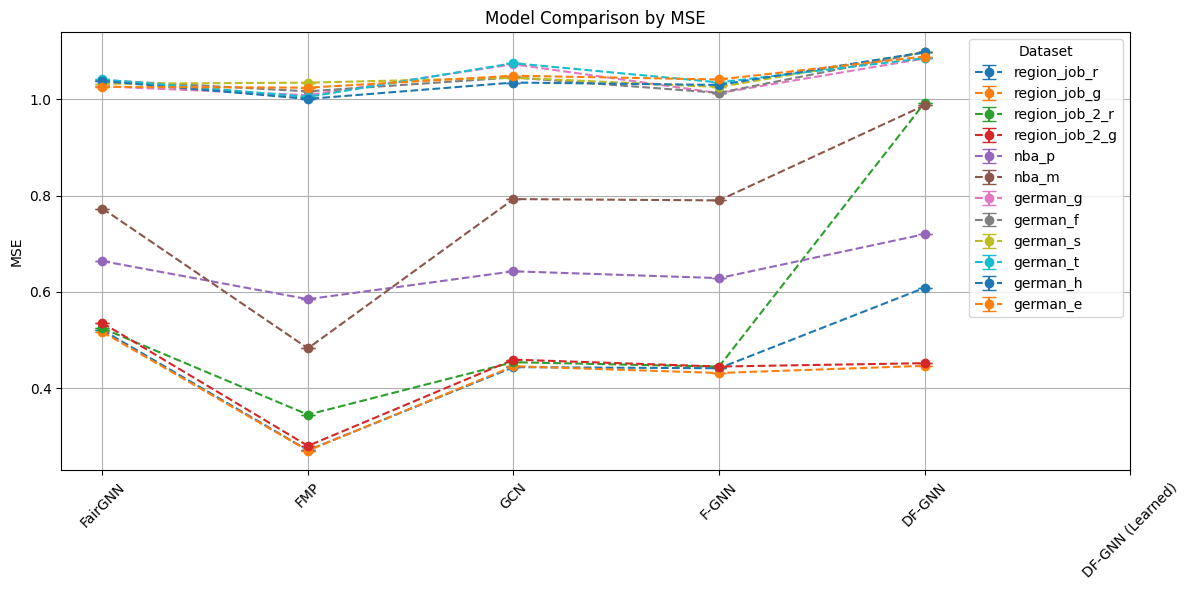

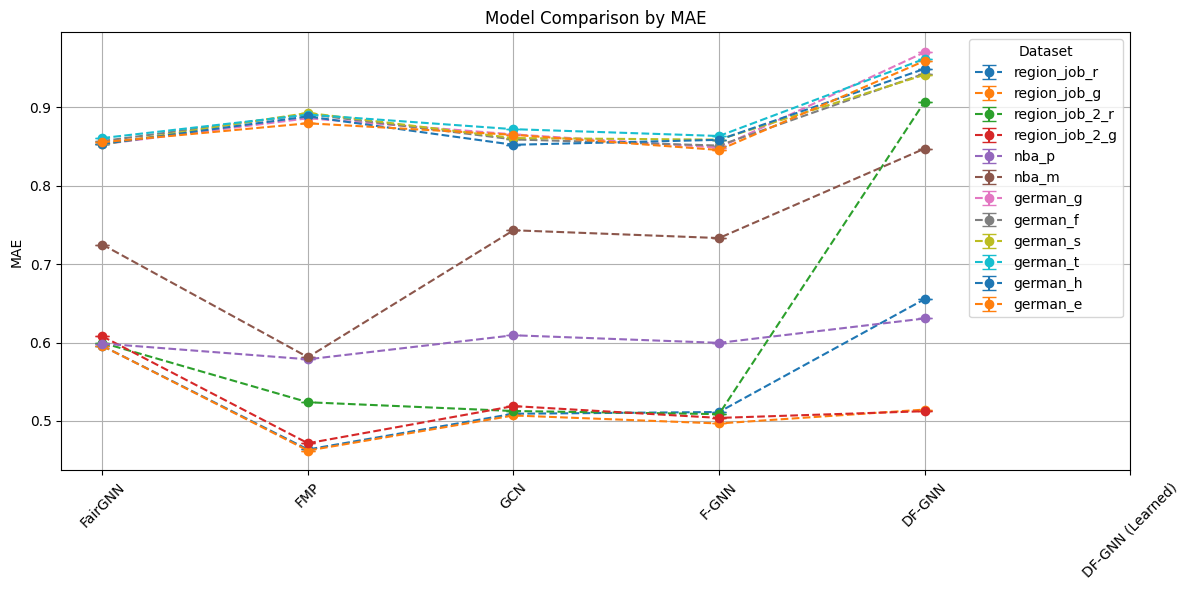

KeyError: 'MSE-diff Mean'

<Figure size 1200x600 with 0 Axes>

In [197]:
# metric 리스트와 모델, 데이터셋 목록 정의
metric_names = ['MSE', 'MAE', 'MSE-diff', 'Wasserstein', 'KL', 'JS', 'KS', 'CVM', 'TV']
models = ['FairGNN', 'FMP', 'GCN', 'F-GNN', 'DF-GNN', 'DF-GNN (Learned)']
datasets = df['Dataset'].unique()

# 지표별로 모델별 평균 + 표준편차 시각화
for metric in metric_names:
    plt.figure(figsize=(12, 6))
    
    for ds in datasets:
        df_ds = df[df['Dataset'] == ds]
        means, stds = [], []
        
        for model in models:
            row = df_ds[df_ds['Model'] == model]
            if not row.empty:
                means.append(row[f'{metric} Mean'].values[0])
                stds.append(row[f'{metric} Std'].values[0])
            else:
                means.append(np.nan)
                stds.append(0)  # 시각화 시 결측은 0으로 처리
        
        x = np.arange(len(models))
        plt.errorbar(x, means, yerr=stds, label=ds, capsize=5, marker='o', linestyle='--')
    
    plt.xticks(ticks=np.arange(len(models)), labels=models, rotation=45)
    plt.ylabel(metric)
    plt.title(f'Model Comparison by {metric}')
    plt.legend(title='Dataset')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_37120\1514768435.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


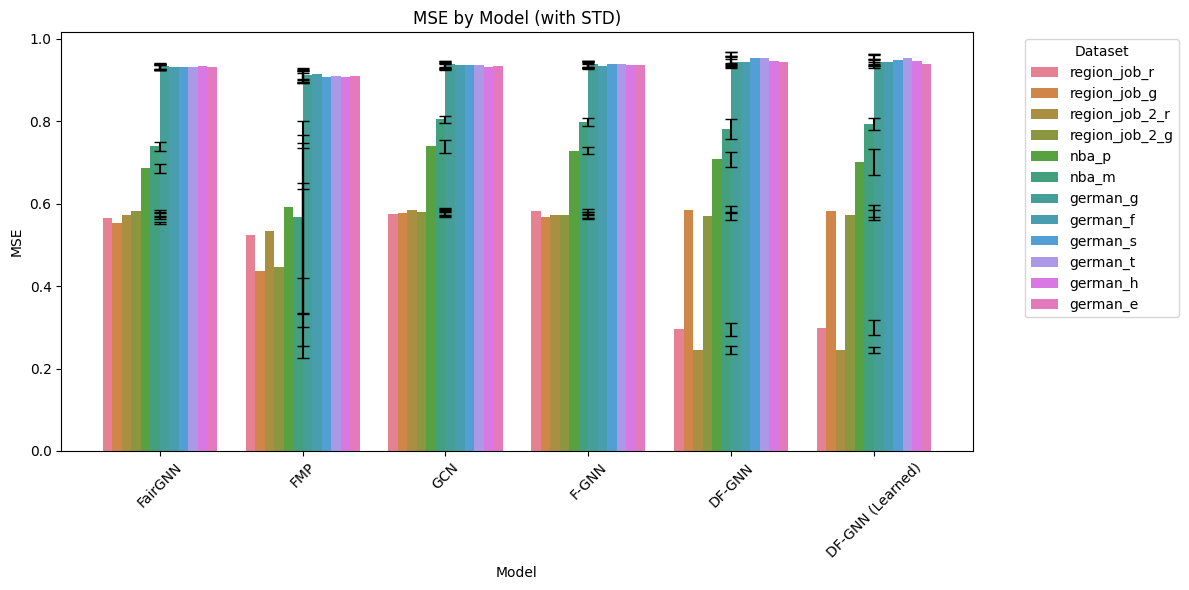

C:\Users\user\AppData\Local\Temp\ipykernel_37120\1514768435.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


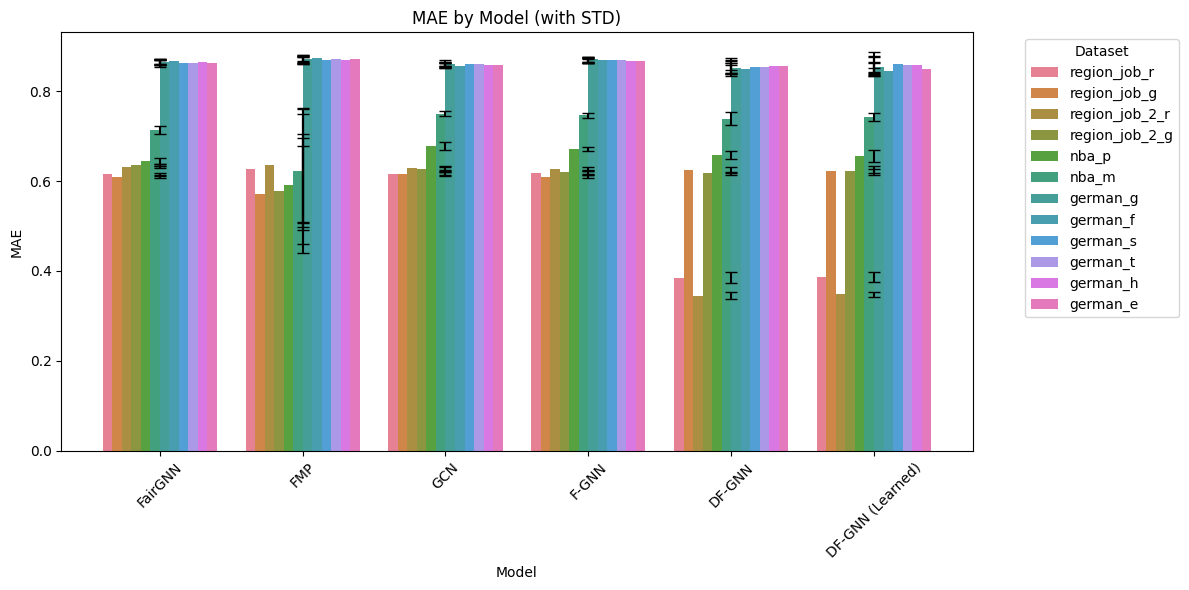

C:\Users\user\AppData\Local\Temp\ipykernel_37120\1514768435.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


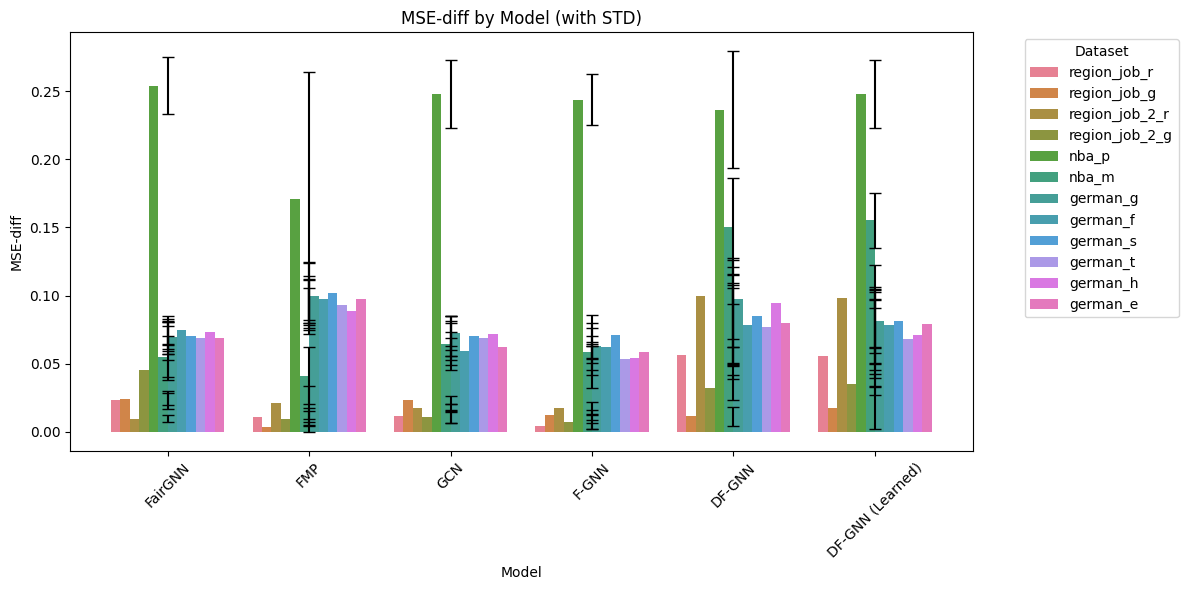

C:\Users\user\AppData\Local\Temp\ipykernel_37120\1514768435.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


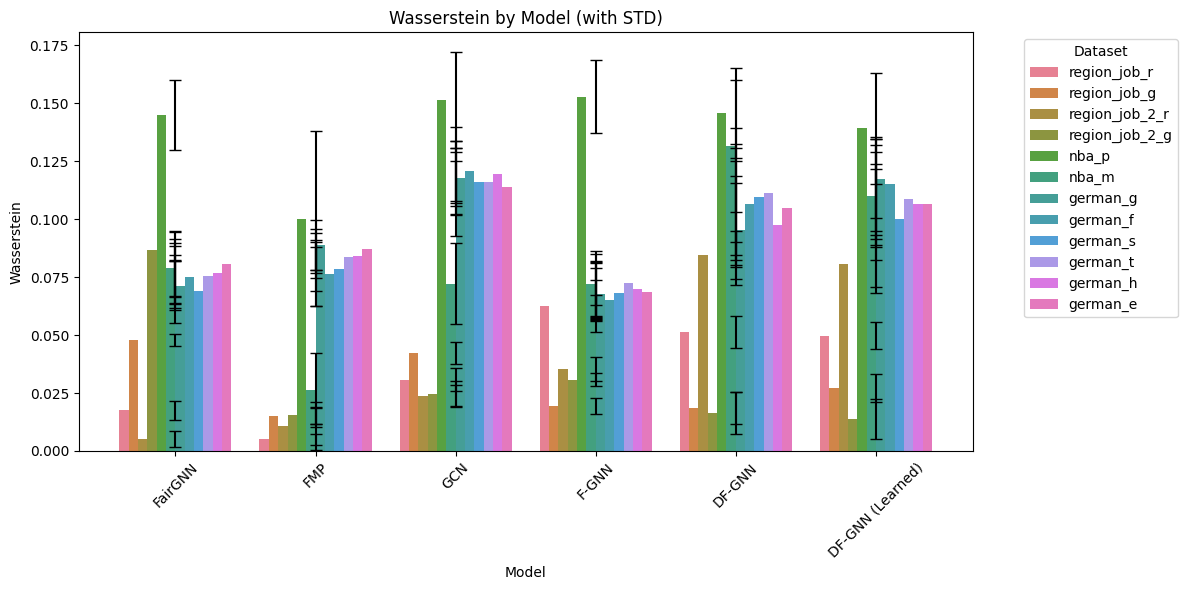

C:\Users\user\AppData\Local\Temp\ipykernel_37120\1514768435.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


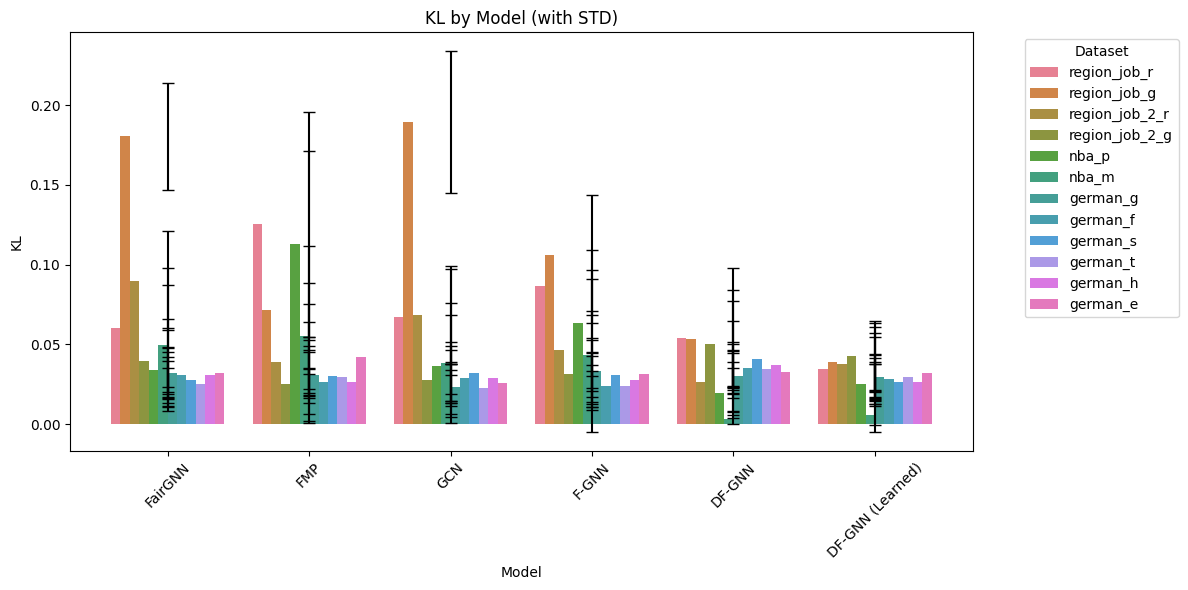

C:\Users\user\AppData\Local\Temp\ipykernel_37120\1514768435.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


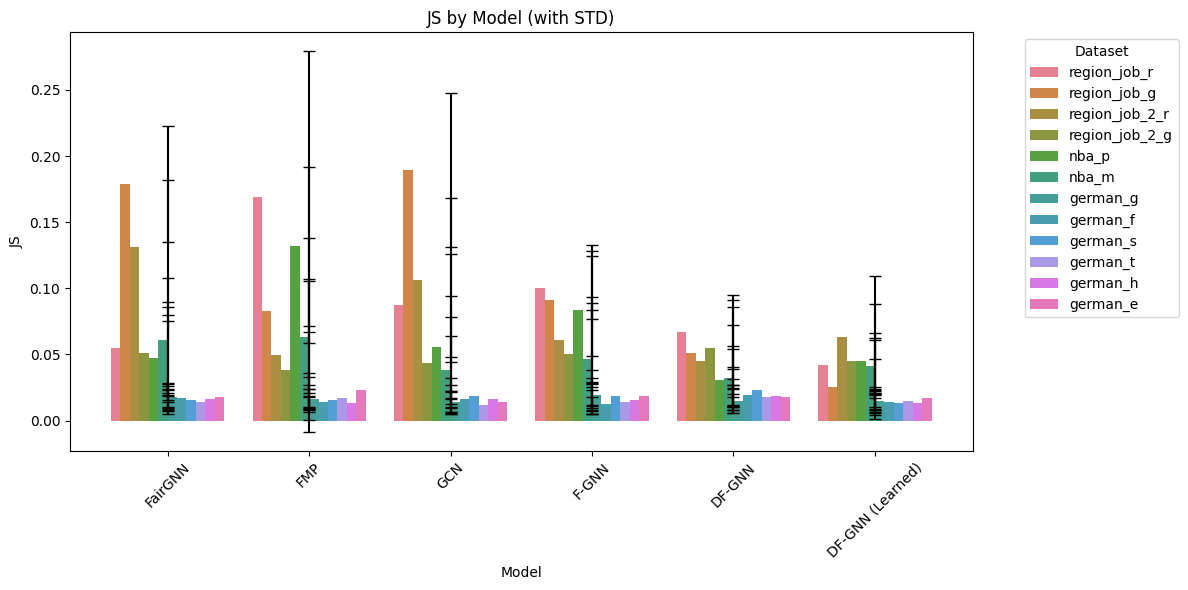

C:\Users\user\AppData\Local\Temp\ipykernel_37120\1514768435.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


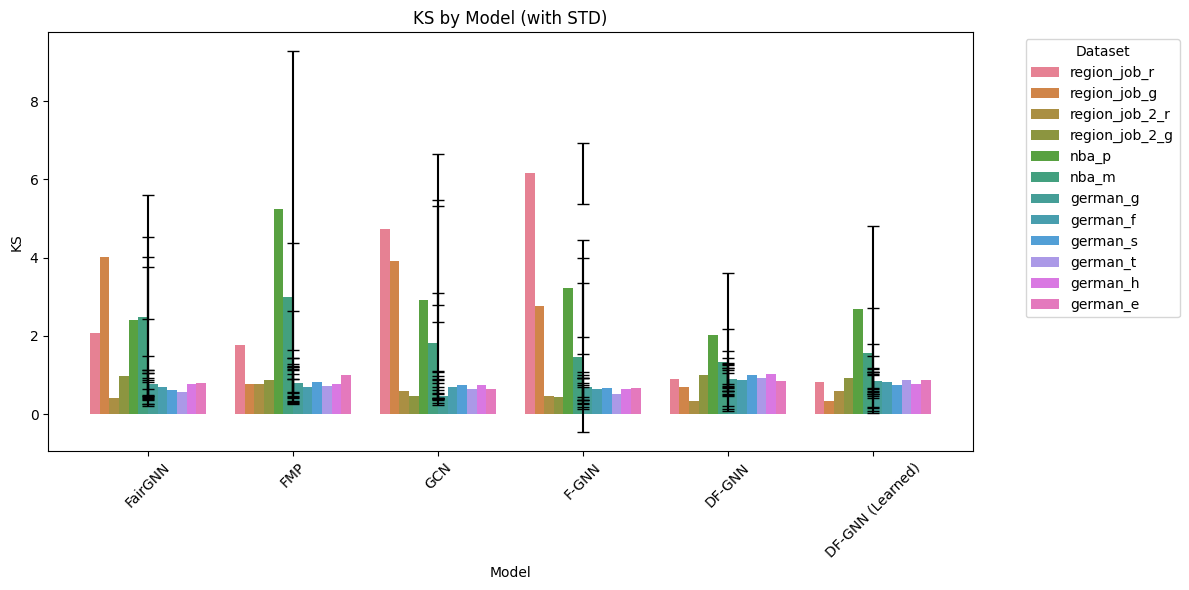

C:\Users\user\AppData\Local\Temp\ipykernel_37120\1514768435.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


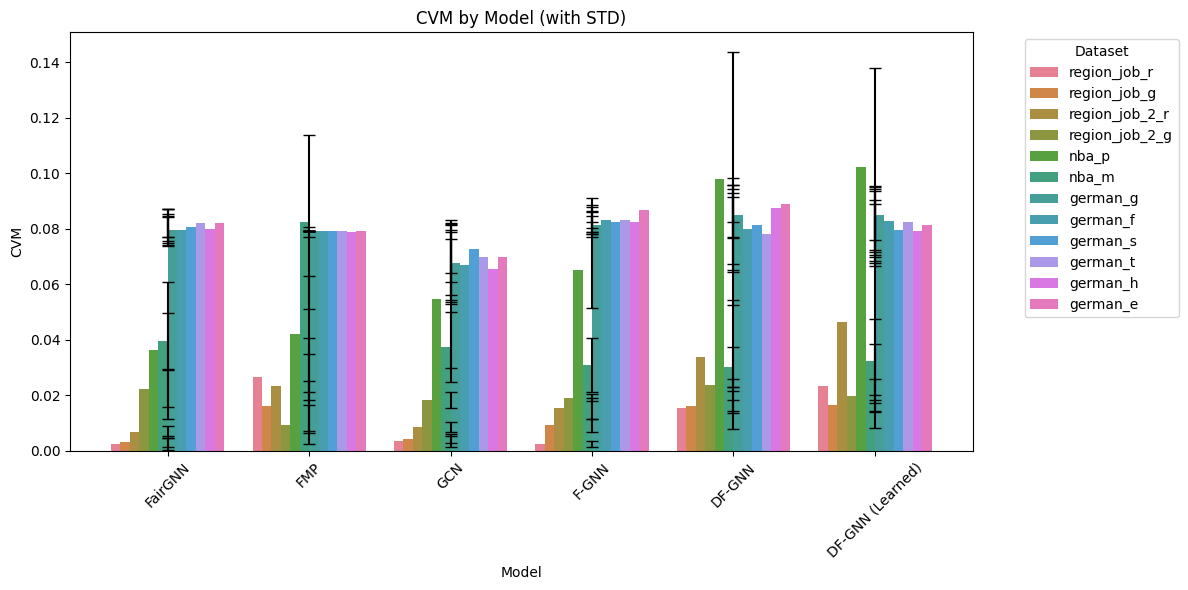

C:\Users\user\AppData\Local\Temp\ipykernel_37120\1514768435.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


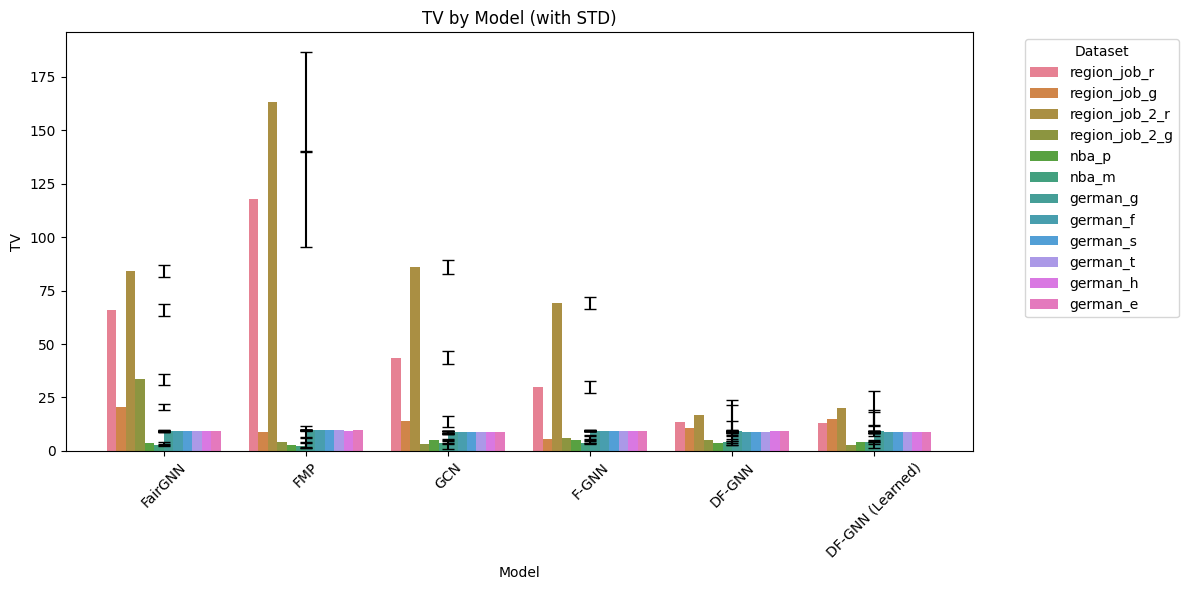

In [77]:
for metric in metric_names:
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=df, x="Model", y=f"{metric} Mean", hue="Dataset",
        ci=None, capsize=0.1
    )
    for i, row in df.iterrows():
        plt.errorbar(
            x=i % len(models), 
            y=row[f"{metric} Mean"], 
            yerr=row[f"{metric} Std"], 
            fmt='none', c='black', capsize=4
        )
    plt.title(f'{metric} by Model (with STD)')
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.legend(title='Dataset', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

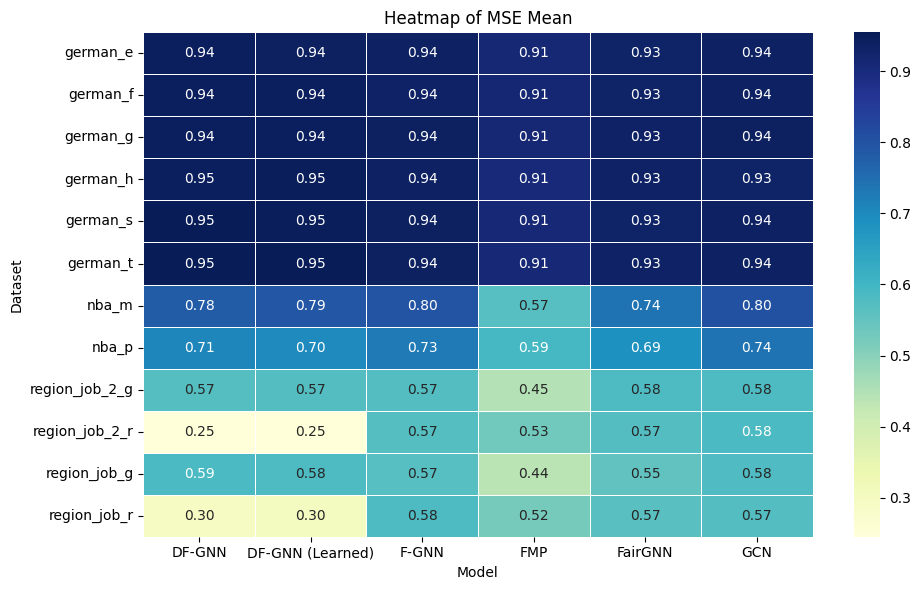

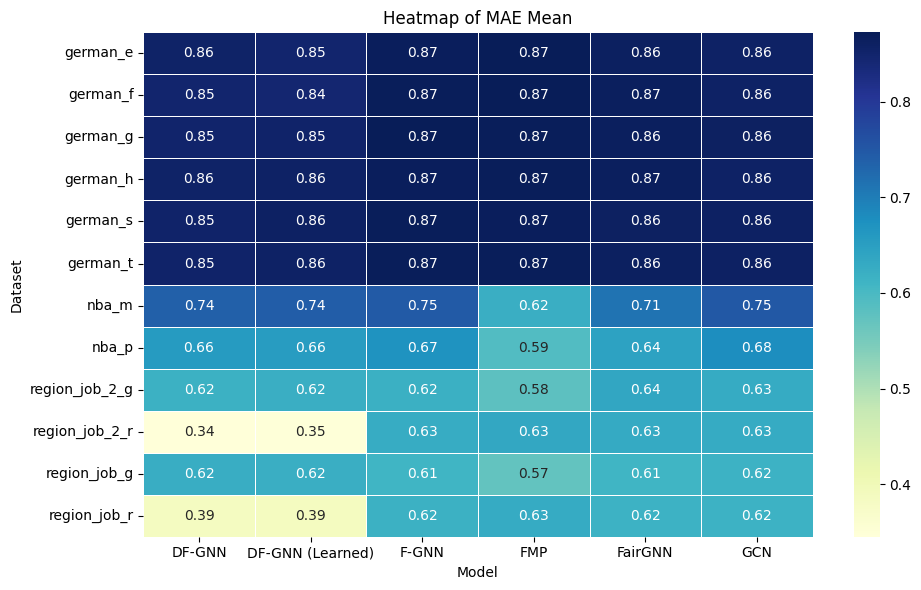

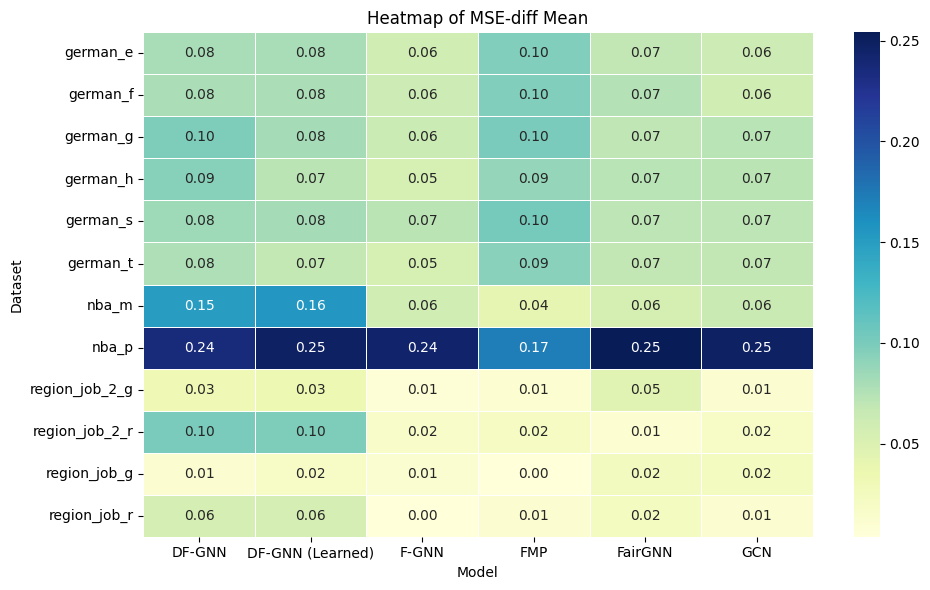

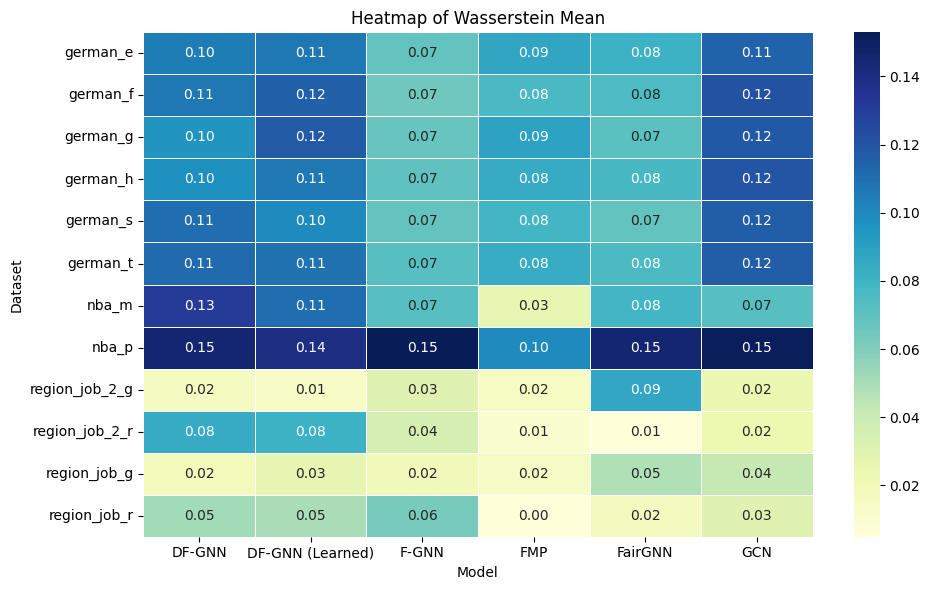

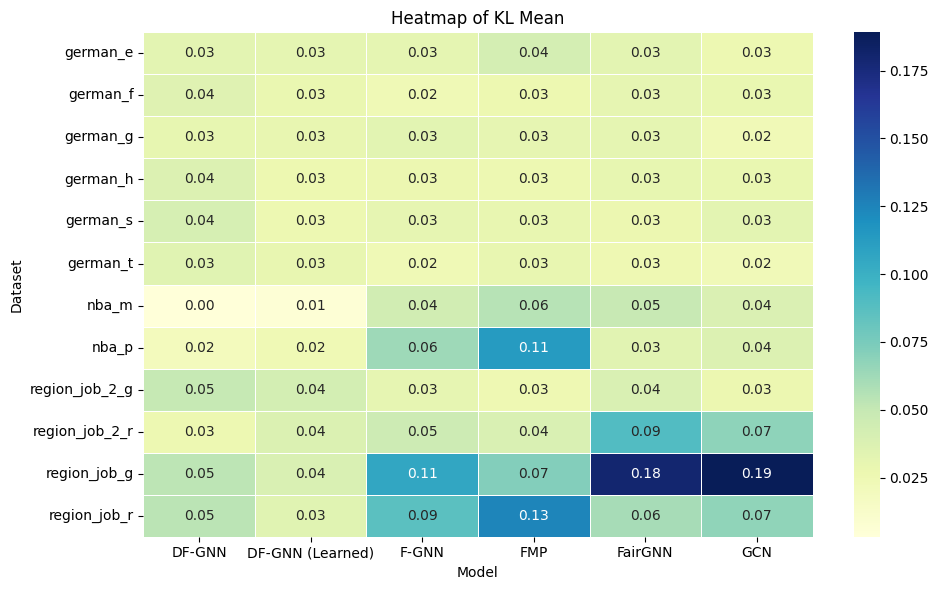

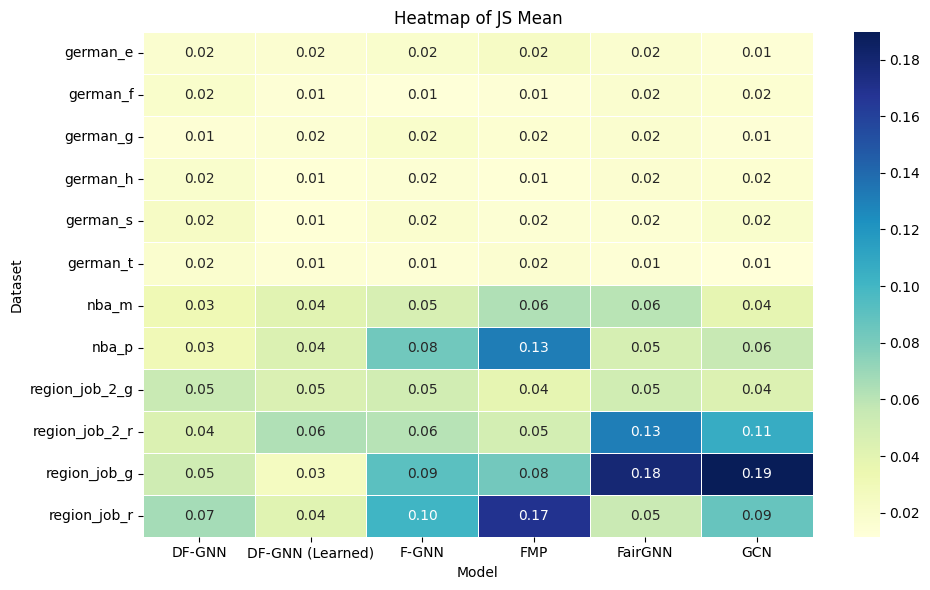

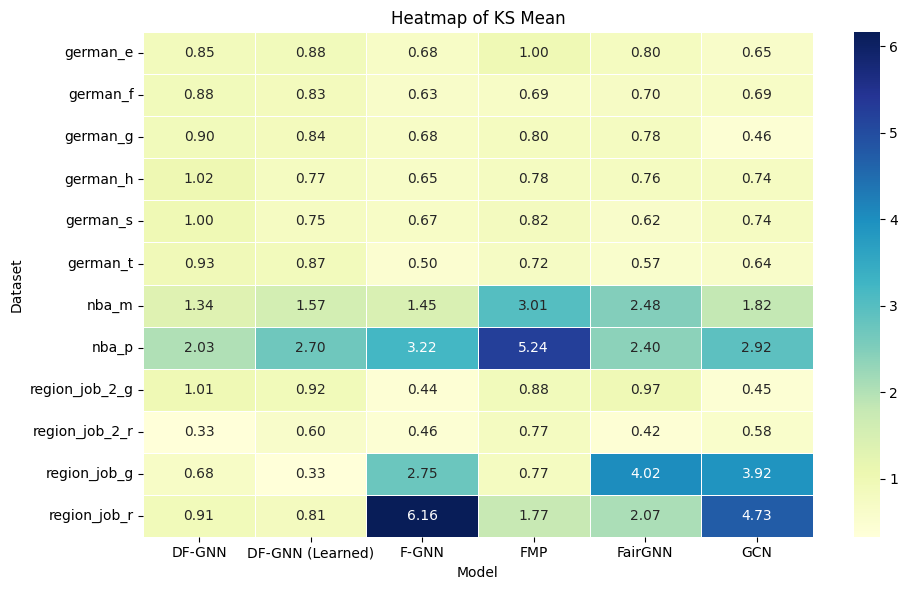

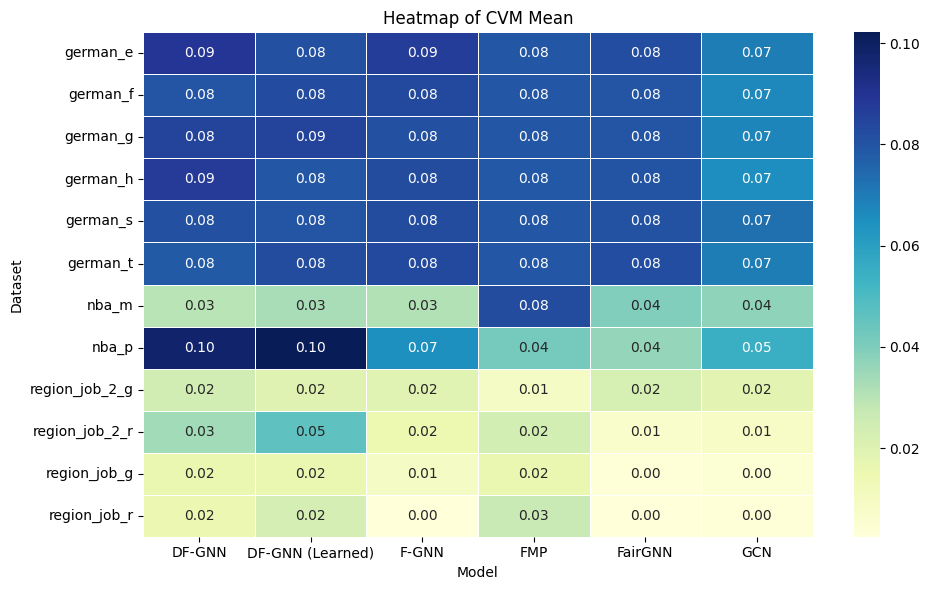

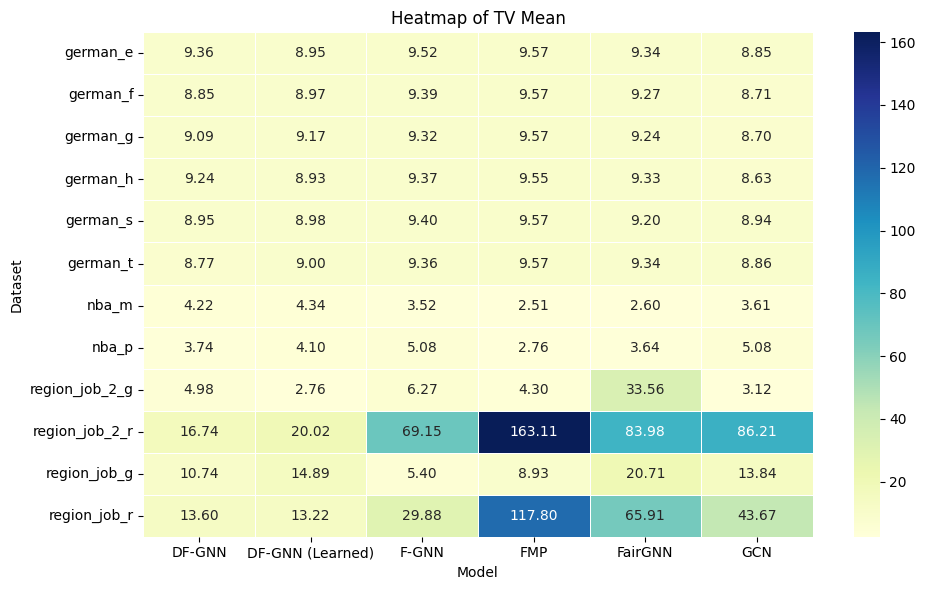

In [78]:
for metric in metric_names:
    pivot_table = df.pivot(index='Dataset', columns='Model', values=f'{metric} Mean')
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=0.5)
    plt.title(f'Heatmap of {metric} Mean')
    plt.ylabel("Dataset")
    plt.xlabel("Model")
    plt.tight_layout()
    plt.show()

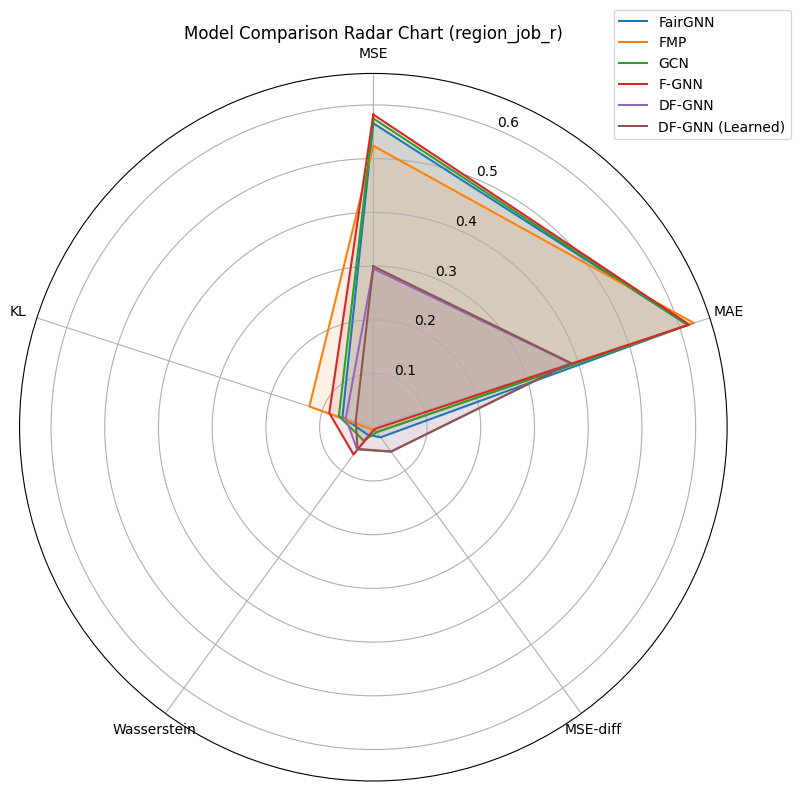

In [79]:
from math import pi

def plot_radar_chart(df, dataset):
    df_ds = df[df['Dataset'] == dataset]
    metrics = metric_names[:5]  # 일부 지표만 보기 좋게 선택
    labels = models
    num_vars = len(metrics)

    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1]  # Loop back to start

    plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, polar=True)

    for model in labels:
        row = df_ds[df_ds['Model'] == model]
        if not row.empty:
            values = [row[f'{m} Mean'].values[0] for m in metrics]
            values += values[:1]  # Loop
            ax.plot(angles, values, label=model)
            ax.fill(angles, values, alpha=0.1)

    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    plt.xticks(angles[:-1], metrics)
    plt.title(f'Model Comparison Radar Chart ({dataset})')
    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
    plt.tight_layout()
    plt.show()

plot_radar_chart(df, dataset="region_job_r")  # 원하는 데이터셋으로 변경
